# Dataset Loading

For the purpose of friend recommendation, we are utilizing the [Facebook social circles](https://snap.stanford.edu/data/ego-Facebook.html) dataset,  which can be found on the Stanford SNAP website.

In [1]:
!wget http://snap.stanford.edu/data/facebook.tar.gz
!tar -xvf "facebook.tar.gz"

--2023-04-23 07:46:05--  http://snap.stanford.edu/data/facebook.tar.gz
Resolving snap.stanford.edu (snap.stanford.edu)... 171.64.75.80
Connecting to snap.stanford.edu (snap.stanford.edu)|171.64.75.80|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 732104 (715K) [application/x-gzip]
Saving to: ‘facebook.tar.gz’

facebook.tar.gz     100%[===================>] 714.95K  1.45MB/s    in 0.5s    

2023-04-23 07:46:05 (1.45 MB/s) - ‘facebook.tar.gz’ saved [732104/732104]

facebook/
facebook/3980.egofeat
facebook/0.featnames
facebook/698.egofeat
facebook/3437.feat
facebook/3980.featnames
facebook/0.edges
facebook/3437.circles
facebook/686.circles
facebook/348.egofeat
facebook/107.feat
facebook/348.feat
facebook/1912.circles
facebook/3437.egofeat
facebook/698.feat
facebook/348.edges
facebook/1912.feat
facebook/414.circles
facebook/1684.egofeat
facebook/1684.featnames
facebook/1684.feat
facebook/107.egofeat
facebook/0.circles
facebook/414.edges
facebook/698.featnames
face

In [ ]:
# !wget http://snap.stanford.edu/data/facebook_combined.txt.gz

# Facebook Social Circle Analysis with NetworkX

In [2]:
import networkx as nx
from networkx.algorithms import approximation
import matplotlib.pyplot as plt
from collections import Counter
import random
from itertools import combinations, groupby

import statistics

%matplotlib inline

In [3]:
def explore_and_summarize_network(edgelist, vertices, subgraph, directed=False):
    """
    Concisely summarizes any induced subgraph of the input network
    """
    G = nx.Graph()
    if subgraph is not None:
        induced_edges = [ edge for edge in edgelist if ((edge[0] in subgraph) and (edge[1] in subgraph)) ]
        G.add_nodes_from(subgraph)
        G.add_edges_from(induced_edges, nodetype=int)
    else :
        G.add_nodes_from(vertices)
        G.add_edges_from(edgelist, nodetype=int)
    
    # (a)
    nx.draw(G,pos=nx.spring_layout(G),node_color='maroon',
        node_size=20,
        edge_color="gray",
        width=0.5)
    plt.show()
    # (b)
    if directed:
        in_degree_sequence = [item[-2] for item in local_summaries(G)]
        in_degree_counts = Counter(degree_sequence)
        fig, ax = plt.subplots()
        ax.bar(in_degree_counts.keys(), in_degree_counts.values())
        ax.set_xlabel('Nodes')
        ax.set_ylabel('In Degrees')
        ax.set_title(r'Histogram of in_degrees')
        fig.tight_layout()
        plt.show()
        
        out_degree_sequence = [item[-1] for item in local_summaries(G)]
        out_degree_counts = Counter(out_degree_sequence)
        fig, ax = plt.subplots()
        ax.bar(out_degree_counts.keys(), out_degree_counts.values())
        ax.set_xlabel('Nodes')
        ax.set_ylabel('out Degrees')
        ax.set_title(r'Histogram of out_degrees')
        fig.tight_layout()
        plt.show() 
    else:
        degree_sequence = [item[-1] for item in local_summaries(G)]
        degree_counts = Counter(degree_sequence)
        fig, ax = plt.subplots()
        ax.bar(degree_counts.keys(), degree_counts.values())
        ax.set_xlabel('Nodes')
        ax.set_ylabel('Degrees')
        ax.set_title(r'Histogram of degrees')
        fig.tight_layout()
        plt.show() 
    # (c)
    betweenness_centrality = [item[0] for item in local_summaries(G)]
    fig1, ax1 = plt.subplots()
    ax1.hist(betweenness_centrality)
    ax1.set_xlabel('Nodes')
    ax1.set_ylabel('Betweenness Centrality')
    ax1.set_title(r'Histogram of Betweenness Centrality')
    fig1.tight_layout()
    plt.show()
    # (d)
    eigenvector_centrality = [item[1] for item in local_summaries(G)]
    fig2, ax2 = plt.subplots()
    ax2.hist(eigenvector_centrality)
    ax2.set_xlabel('Nodes')
    ax2.set_ylabel('Eigenvector Centrality')
    ax2.set_title(r'Histogram of Eigenvector Centrality')
    fig2.tight_layout()
    plt.show()
    # Print Global Summaries
    global_summaries(G)     

In [4]:
def local_summaries(G, directed=False):
    betweenness_centrality = nx.centrality.betweenness_centrality(G)
    eigenvector_centrality = nx.centrality.eigenvector_centrality(G)
    closeness_centrality = nx.centrality.closeness_centrality(G)
    if directed:
        in_degrees = [G.in_degree(n) for n in G.nodes]
        out_degrees = [G.in_degree(n) for n in G.nodes]
        return zip(betweenness_centrality.values(), eigenvector_centrality.values(), closeness_centrality.values(), in_degrees, out_degrees)
    else:
        degrees = [G.degree(n) for n in G.nodes]
        return zip(betweenness_centrality.values(), eigenvector_centrality.values(), closeness_centrality.values(), degrees)

In [5]:
def global_summaries(G):
    try:
        diameter = nx.algorithms.distance_measures.diameter(G)
    except:
        diameter = "Found infinite path length because the graph is not connected !"
    clustering_coefficient = nx.algorithms.approximation.clustering_coefficient.average_clustering(G)
    number_of_nodes = G.number_of_edges()
    number_of_edges = G.number_of_nodes()
    number_of_connected_components = nx.number_connected_components(G)
    largest_connected_component = max([ len(i) for i in list(nx.connected_components(G))])
    print("##### Global Summaries #####")
    print("Diameter : ",diameter)
    print("Number of Nodes : ",number_of_nodes)
    print("Number of Edges : ",number_of_edges)
    print("Number of Connected Components : ",number_of_connected_components)
    print("Size of the Largest Connected Compopnent : ",largest_connected_component)

In [6]:
def read_circles(file_path):
    with open(file_path) as f :
        content = f.readlines()
        content = [line.replace("\n","") for line in content]
        content = [line.split("\t") for line in content]
    return {circle[0]:list(map(int,circle[1:])) for circle in content} # Convert nodes to int and add to dict.

In [7]:
def gnp_random_connected_graph(n, p):
    """
    Generates a random undirected graph, similarly to an Erdős-Rényi 
    graph, but enforcing that the resulting graph is conneted
    """
    edges = combinations(range(n), 2)
    G = nx.Graph()
    G.add_nodes_from(range(n))
    if p <= 0:
        return G
    if p >= 1:
        return nx.complete_graph(n, create_using=G)
    for _, node_edges in groupby(edges, key=lambda x: x[0]):
        node_edges = list(node_edges)
        random_edge = random.choice(node_edges)
        G.add_edge(*random_edge)
        for e in node_edges:
            if random.random() < p:
                G.add_edge(*e)
    return G

In [8]:
G = nx.read_edgelist('/content/facebook/0.edges', nodetype=int)

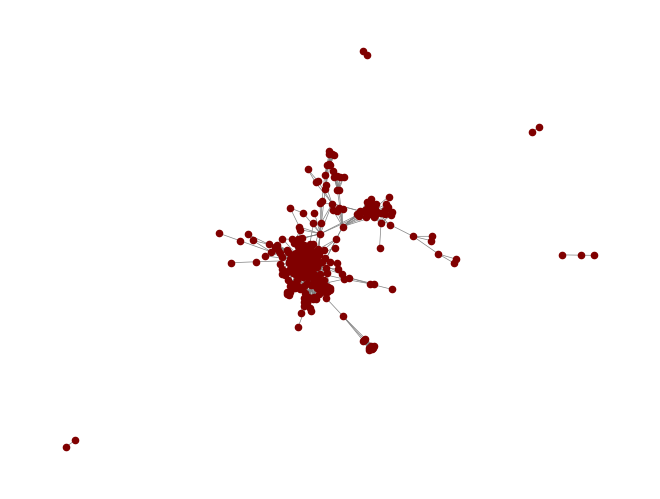

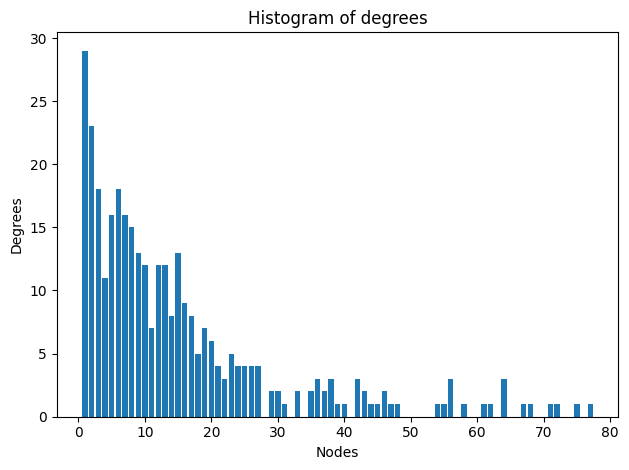

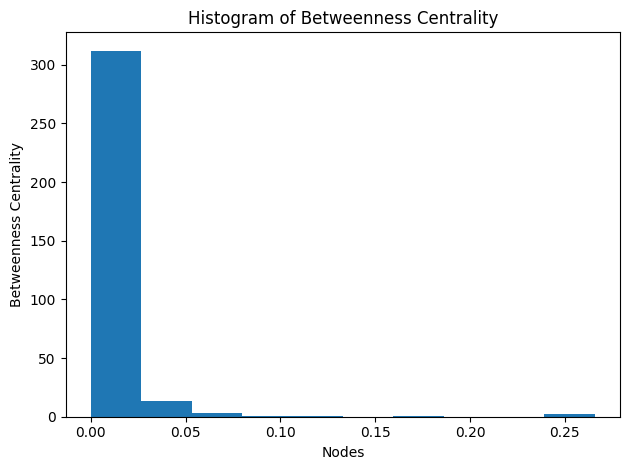

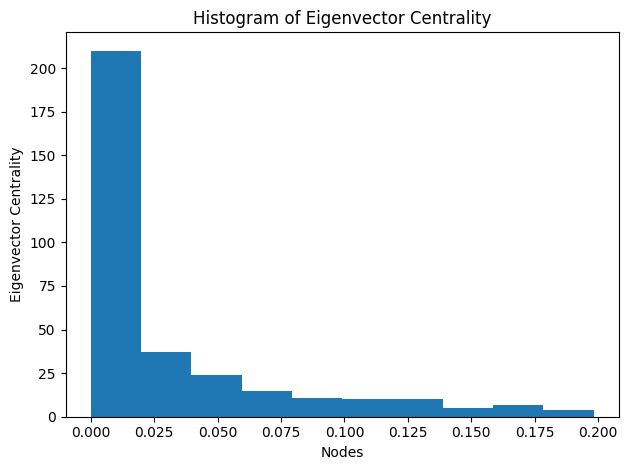

##### Global Summaries #####
Diameter :  Found infinite path length because the graph is not connected !
Number of Nodes :  2519
Number of Edges :  333
Number of Connected Components :  5
Size of the Largest Connected Compopnent :  324


In [ ]:
explore_and_summarize_network(edgelist = G.edges(), vertices=G.nodes(), subgraph=None)

In [9]:
circles = read_circles("/content/facebook/0.circles")


 CIRCLE0 



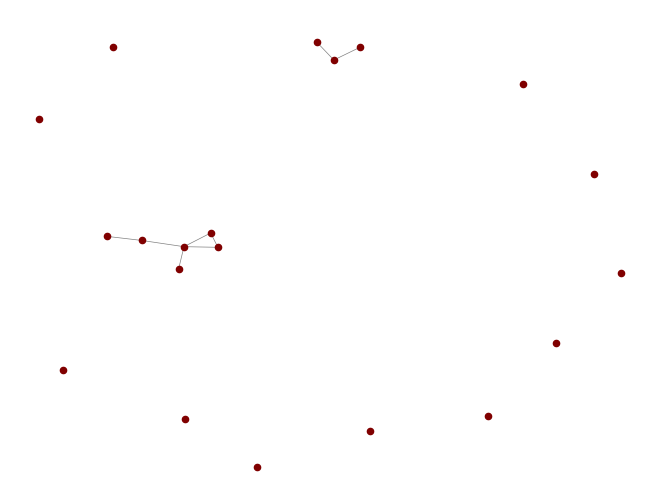

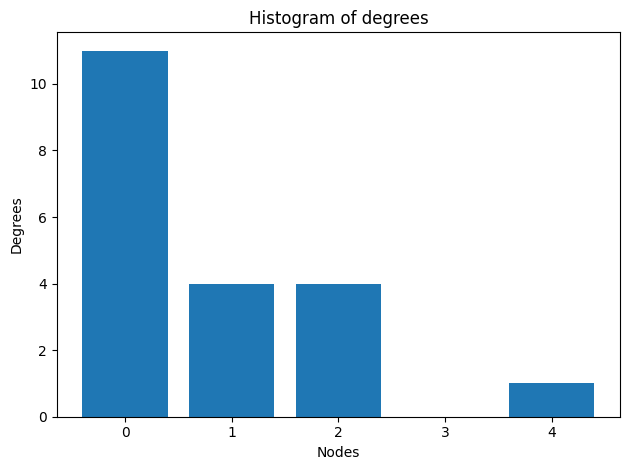

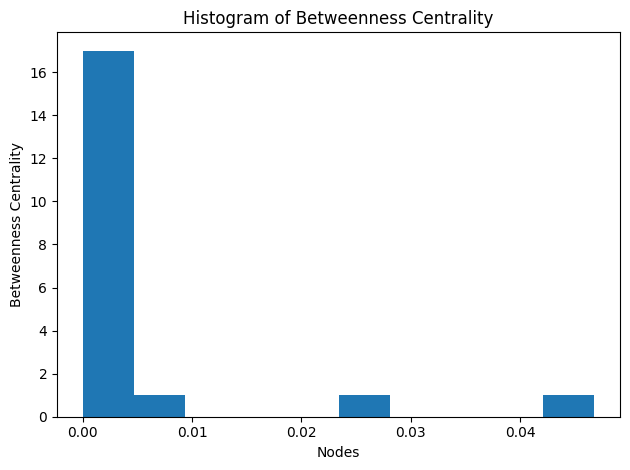

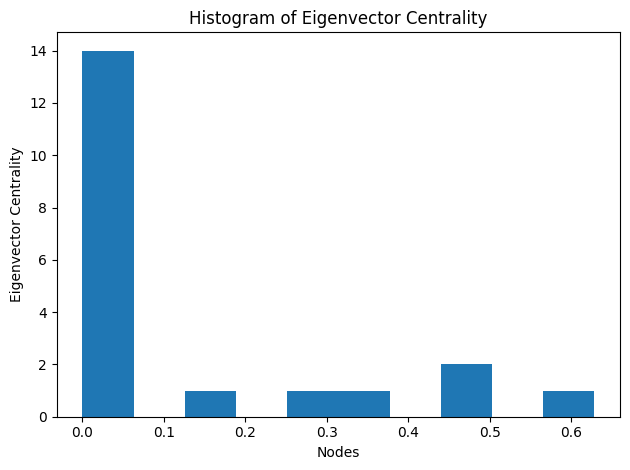

##### Global Summaries #####
Diameter :  Found infinite path length because the graph is not connected !
Number of Nodes :  8
Number of Edges :  20
Number of Connected Components :  13
Size of the Largest Connected Compopnent :  6

 CIRCLE1 



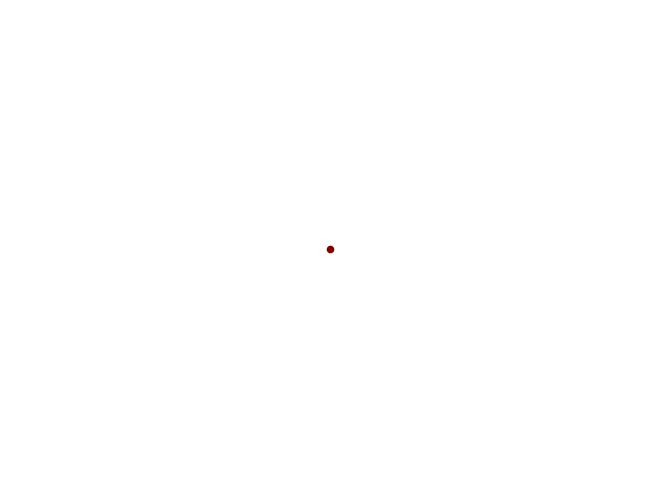

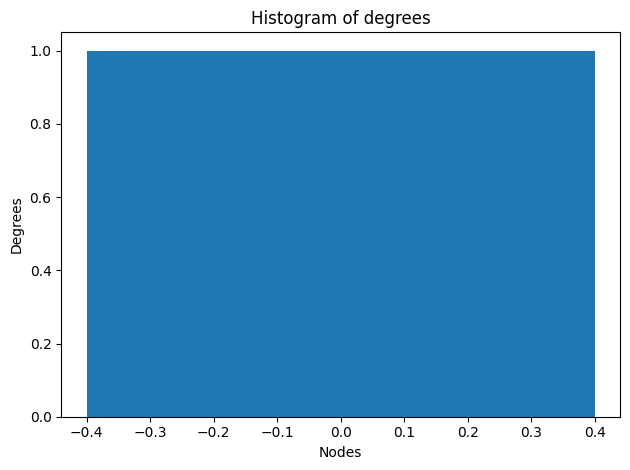

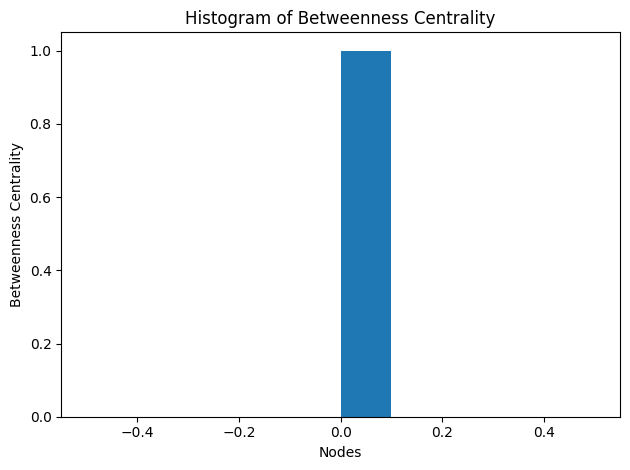

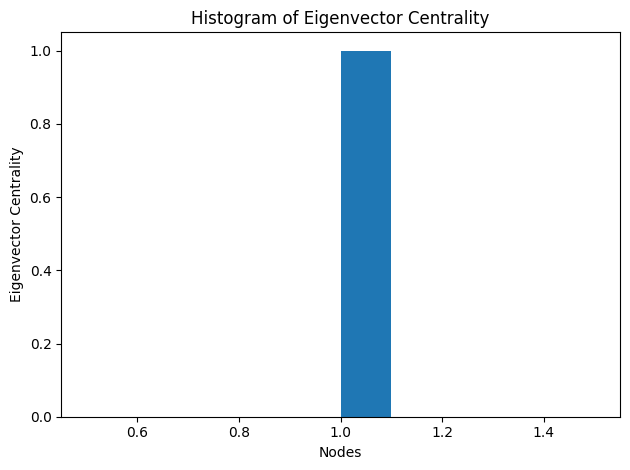

##### Global Summaries #####
Diameter :  0
Number of Nodes :  0
Number of Edges :  1
Number of Connected Components :  1
Size of the Largest Connected Compopnent :  1

 CIRCLE2 



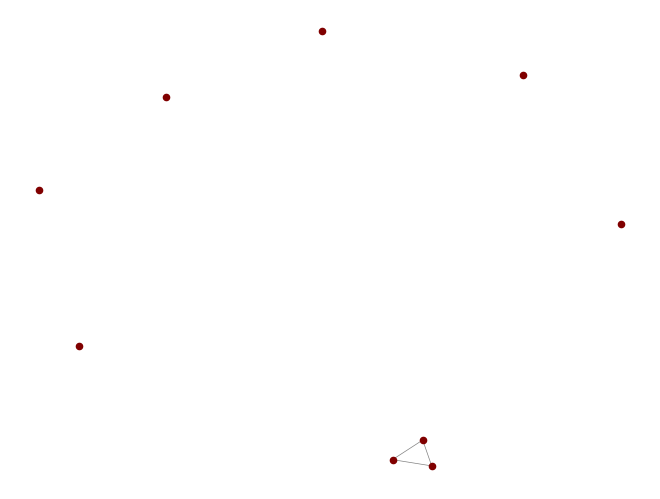

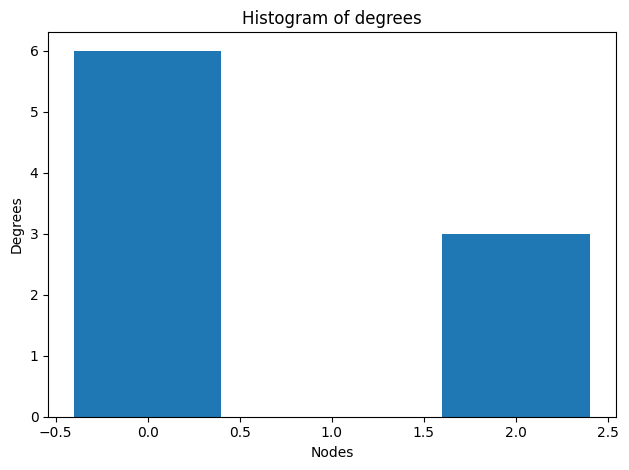

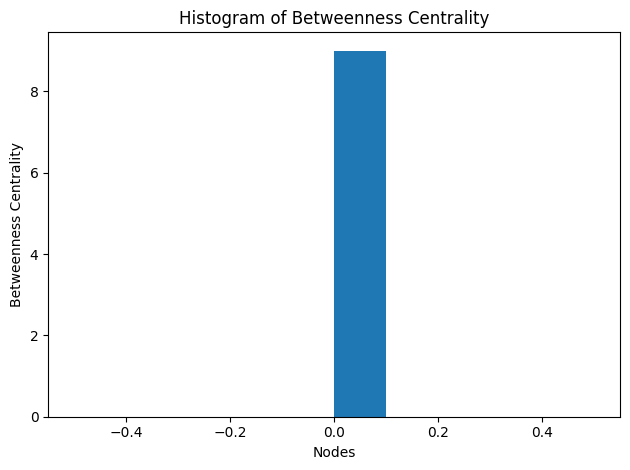

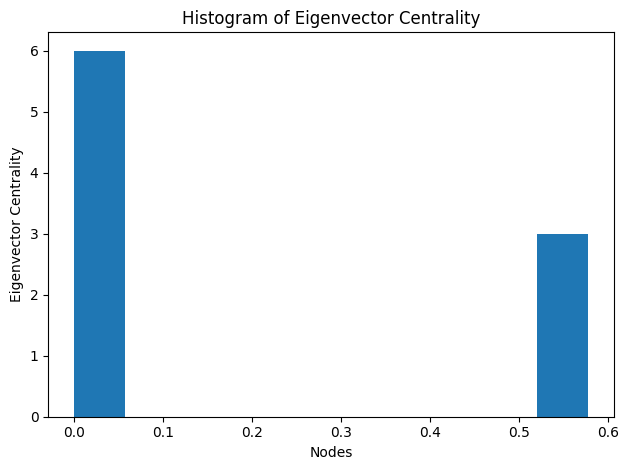

##### Global Summaries #####
Diameter :  Found infinite path length because the graph is not connected !
Number of Nodes :  3
Number of Edges :  9
Number of Connected Components :  7
Size of the Largest Connected Compopnent :  3

 CIRCLE3 



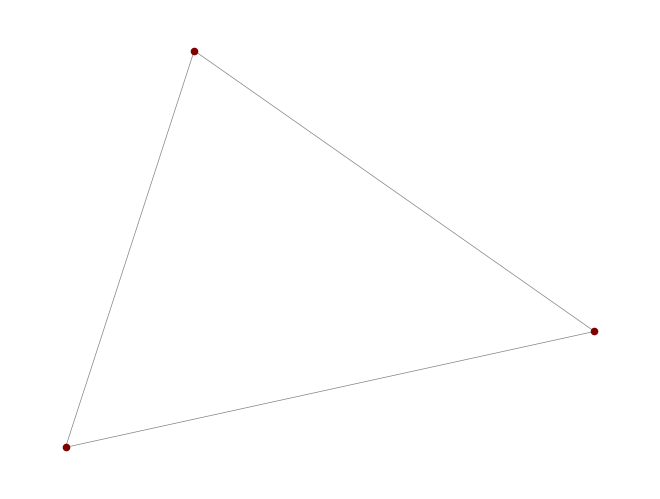

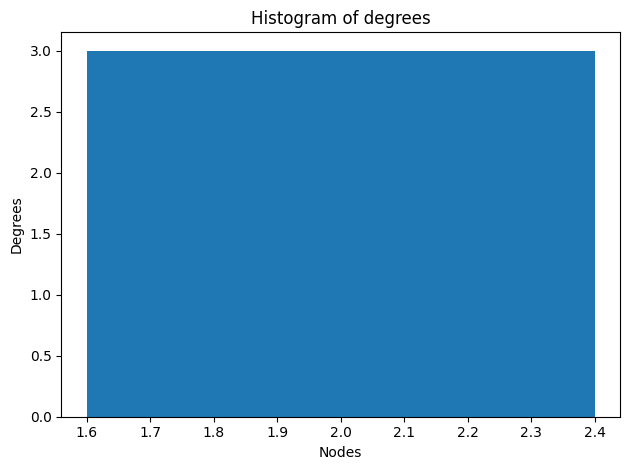

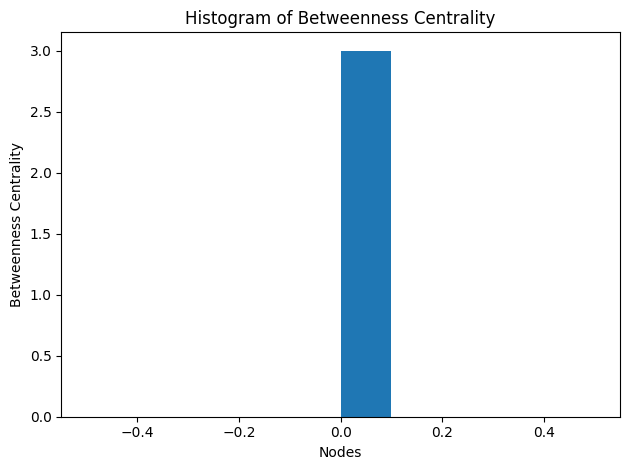

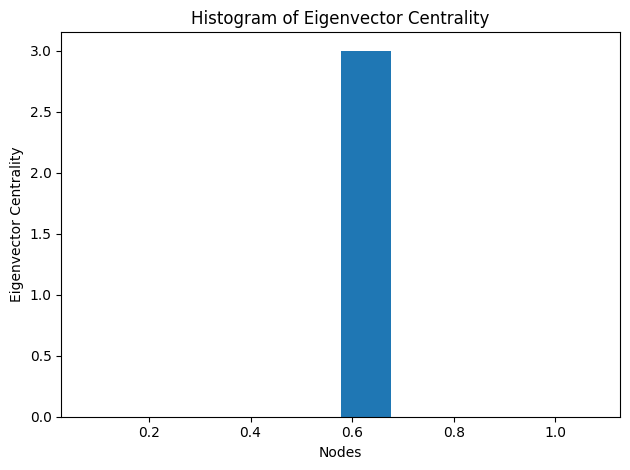

##### Global Summaries #####
Diameter :  1
Number of Nodes :  3
Number of Edges :  3
Number of Connected Components :  1
Size of the Largest Connected Compopnent :  3

 CIRCLE4 



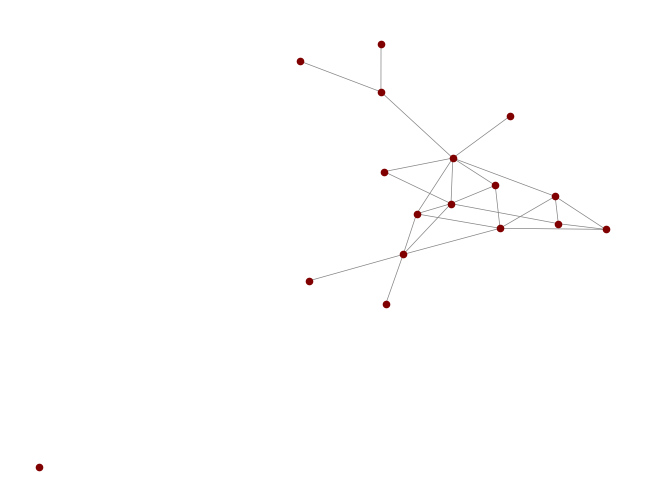

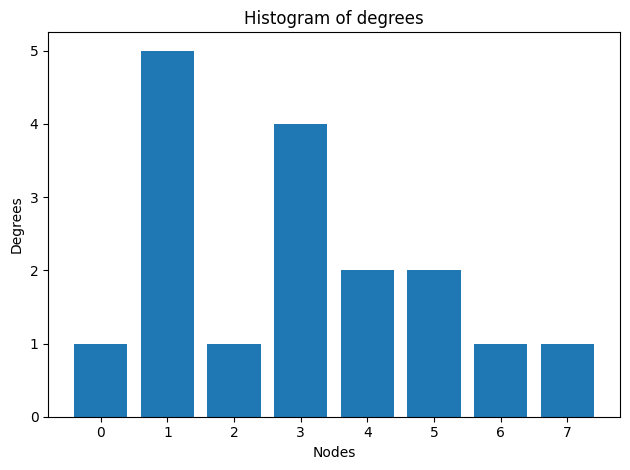

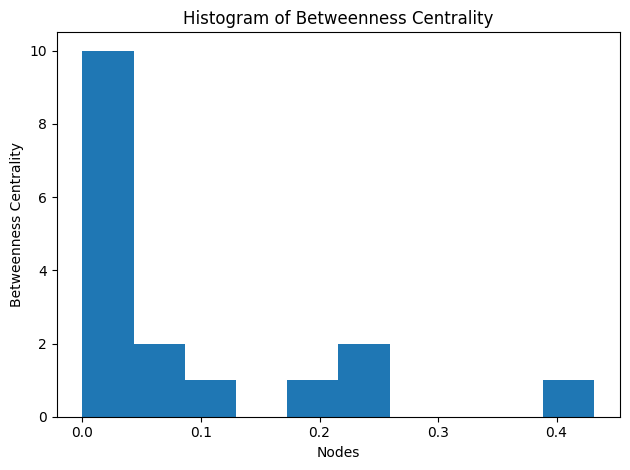

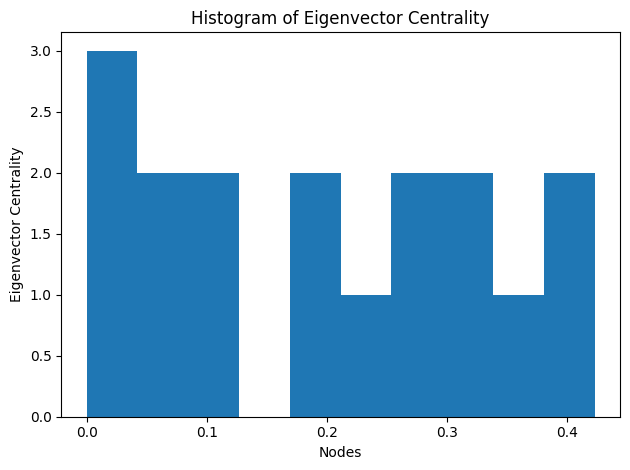

##### Global Summaries #####
Diameter :  Found infinite path length because the graph is not connected !
Number of Nodes :  25
Number of Edges :  17
Number of Connected Components :  2
Size of the Largest Connected Compopnent :  16

 CIRCLE5 



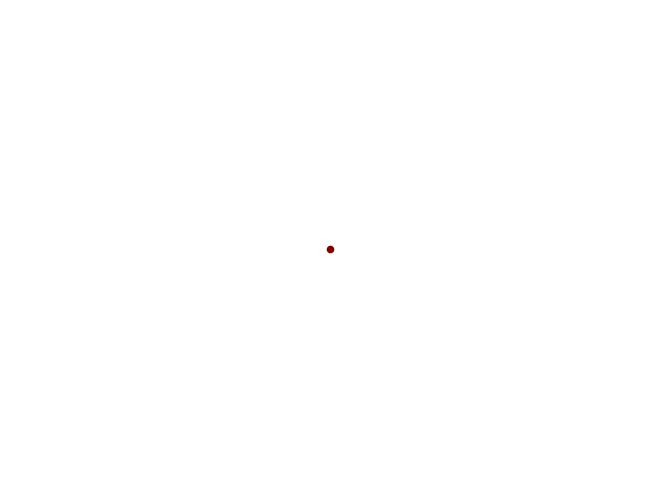

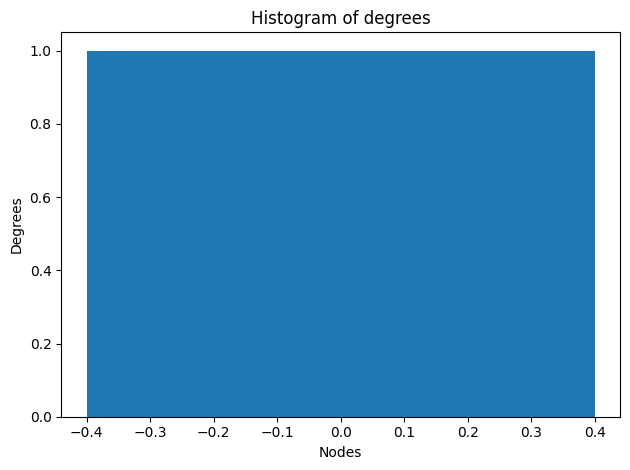

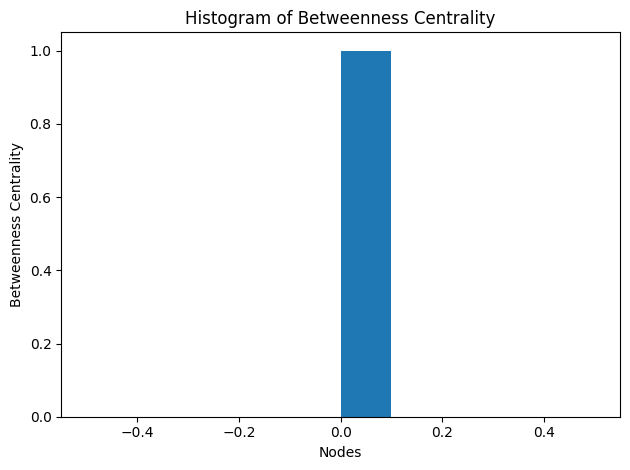

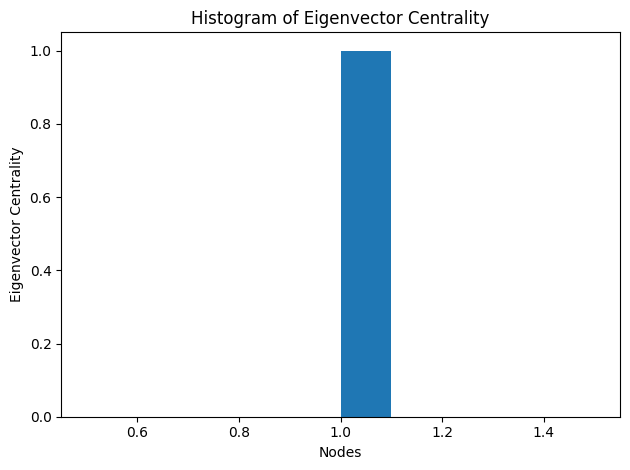

##### Global Summaries #####
Diameter :  0
Number of Nodes :  0
Number of Edges :  1
Number of Connected Components :  1
Size of the Largest Connected Compopnent :  1

 CIRCLE6 



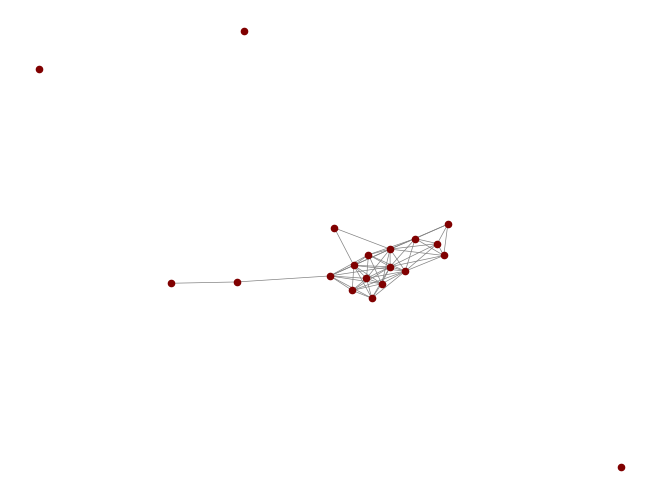

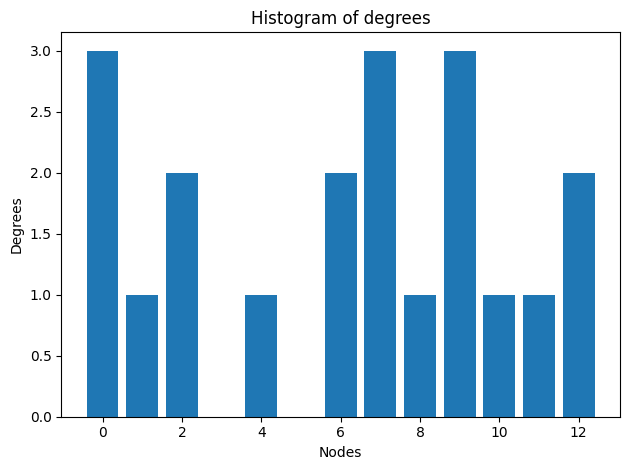

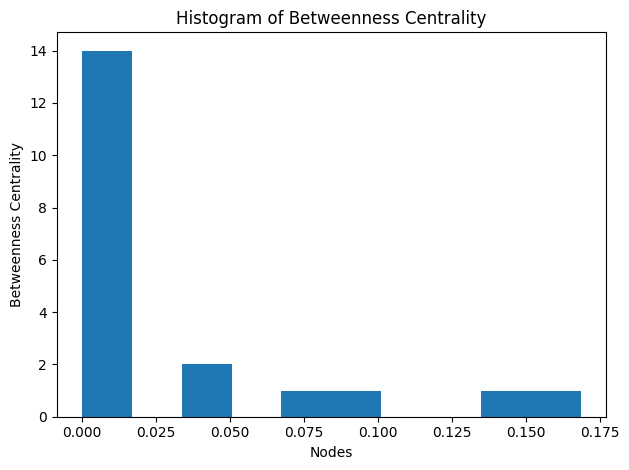

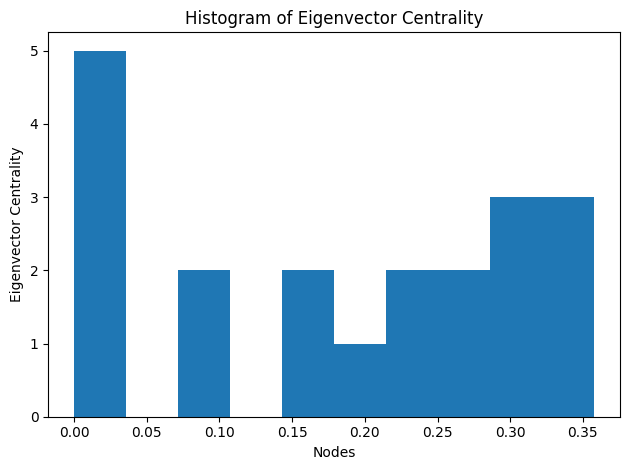

##### Global Summaries #####
Diameter :  Found infinite path length because the graph is not connected !
Number of Nodes :  61
Number of Edges :  20
Number of Connected Components :  4
Size of the Largest Connected Compopnent :  17

 CIRCLE7 



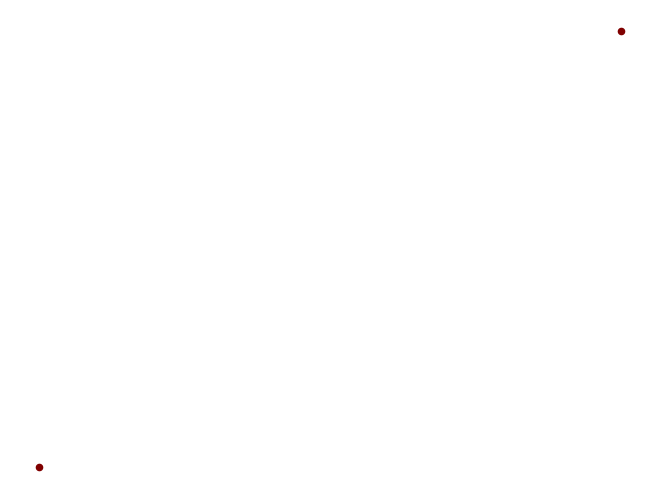

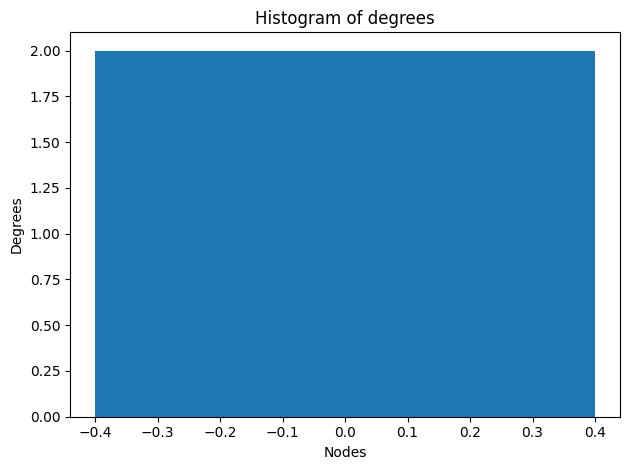

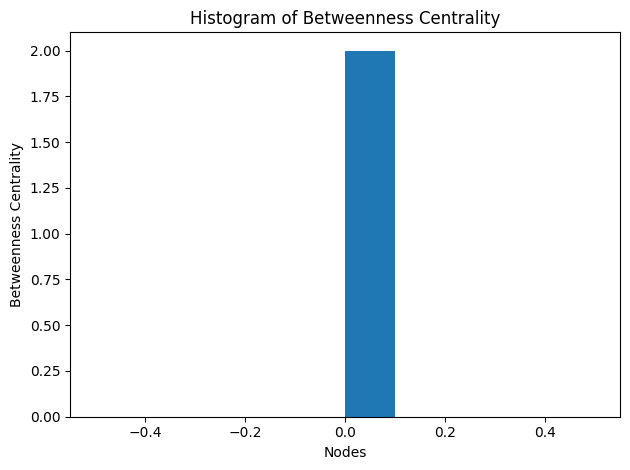

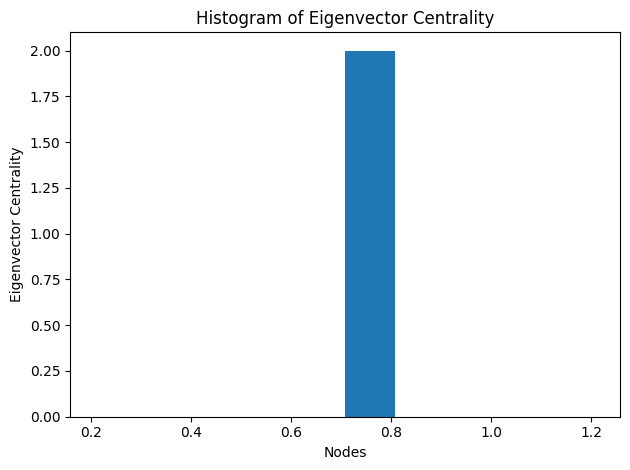

##### Global Summaries #####
Diameter :  Found infinite path length because the graph is not connected !
Number of Nodes :  0
Number of Edges :  2
Number of Connected Components :  2
Size of the Largest Connected Compopnent :  1

 CIRCLE8 



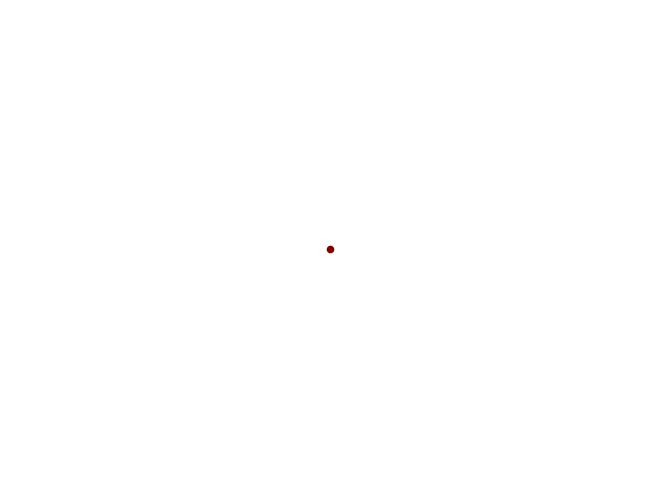

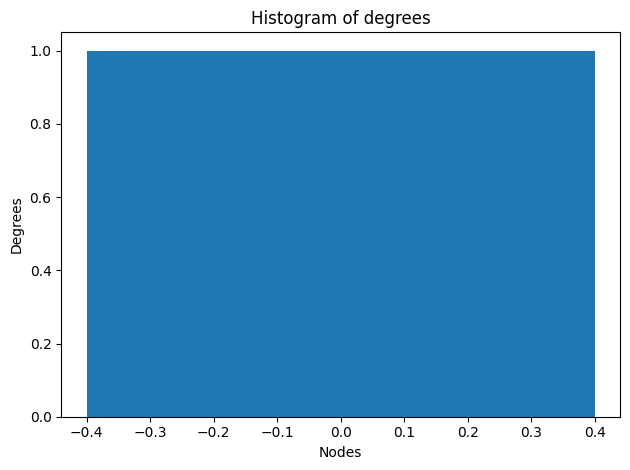

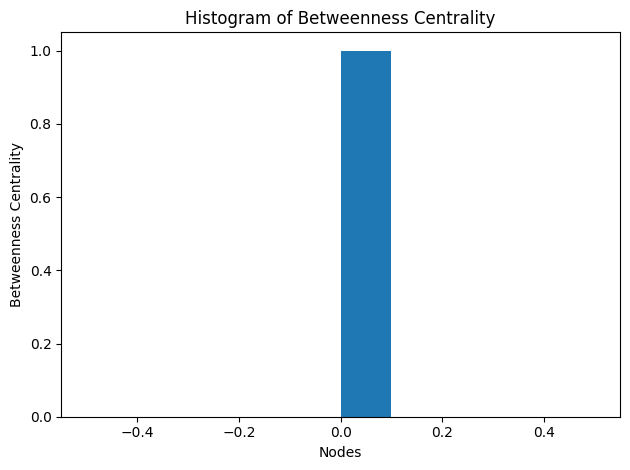

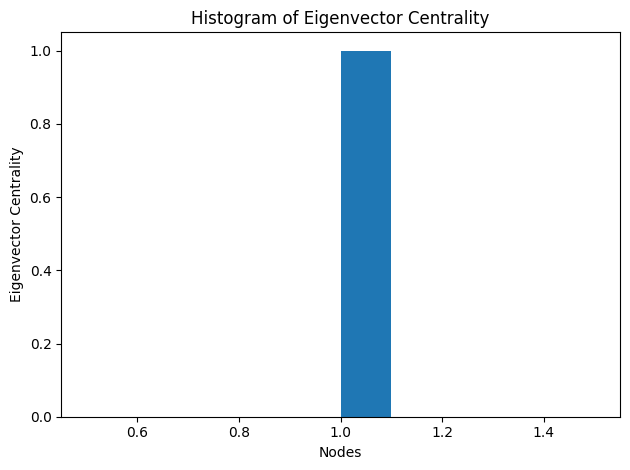

##### Global Summaries #####
Diameter :  0
Number of Nodes :  0
Number of Edges :  1
Number of Connected Components :  1
Size of the Largest Connected Compopnent :  1

 CIRCLE9 



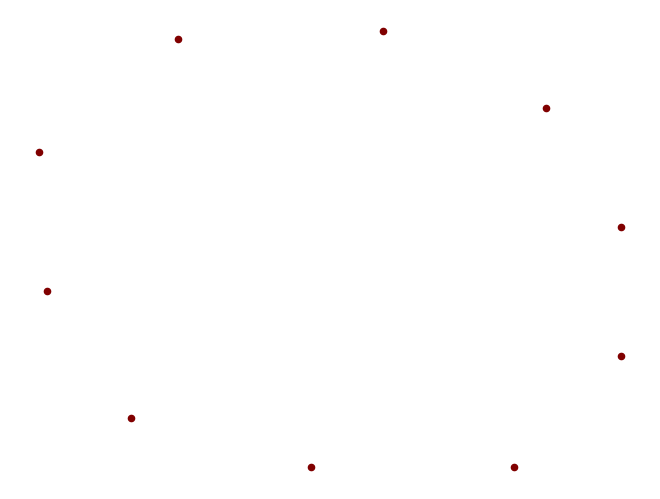

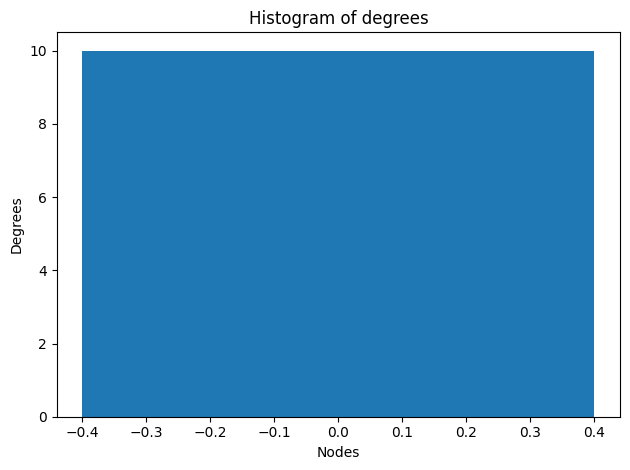

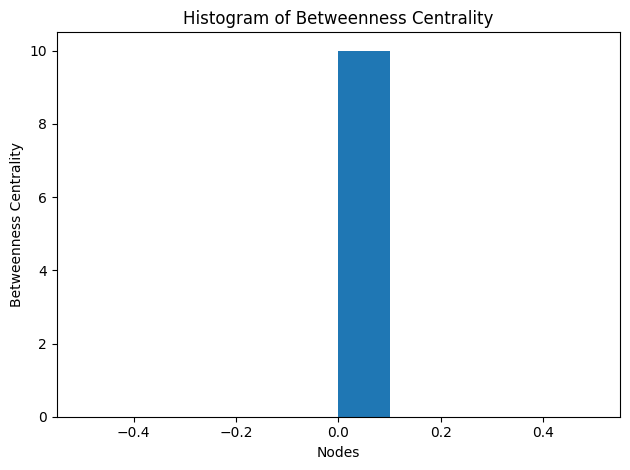

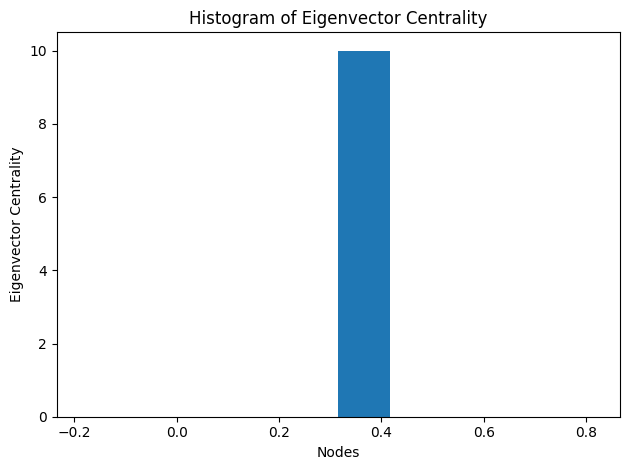

##### Global Summaries #####
Diameter :  Found infinite path length because the graph is not connected !
Number of Nodes :  0
Number of Edges :  10
Number of Connected Components :  10
Size of the Largest Connected Compopnent :  1

 CIRCLE10 



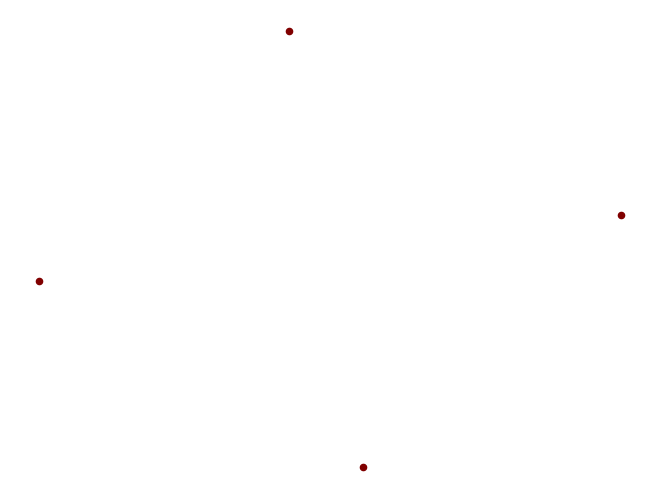

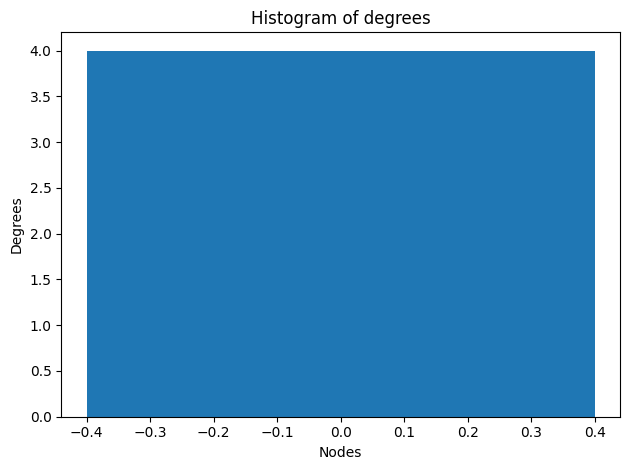

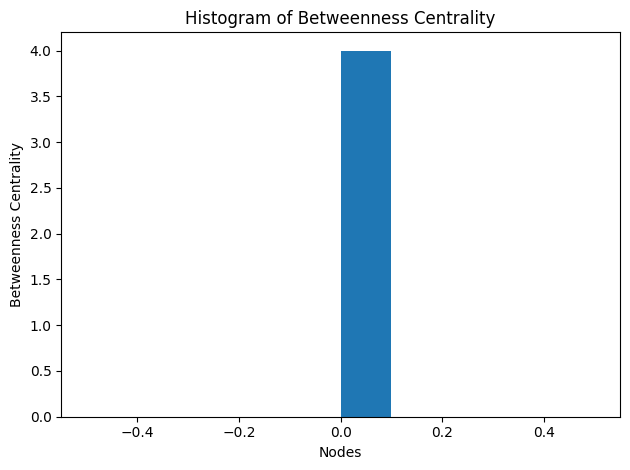

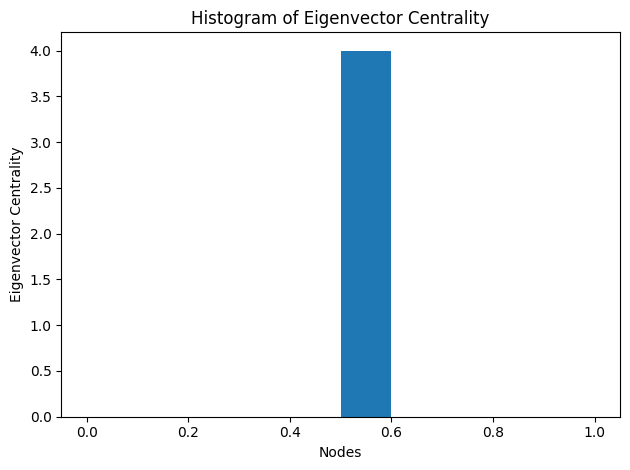

##### Global Summaries #####
Diameter :  Found infinite path length because the graph is not connected !
Number of Nodes :  0
Number of Edges :  4
Number of Connected Components :  4
Size of the Largest Connected Compopnent :  1

 CIRCLE11 



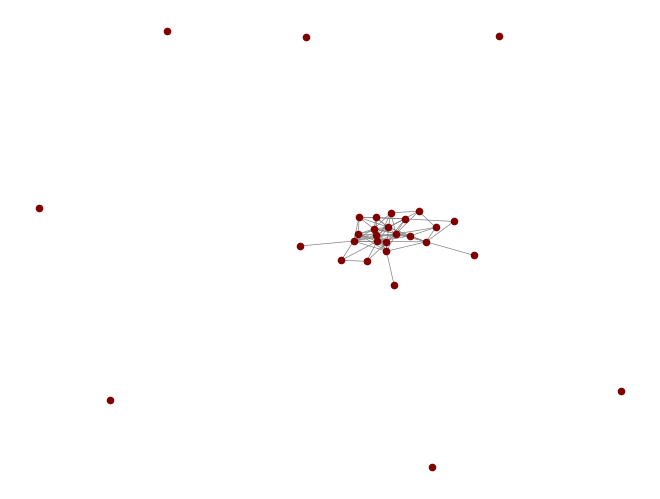

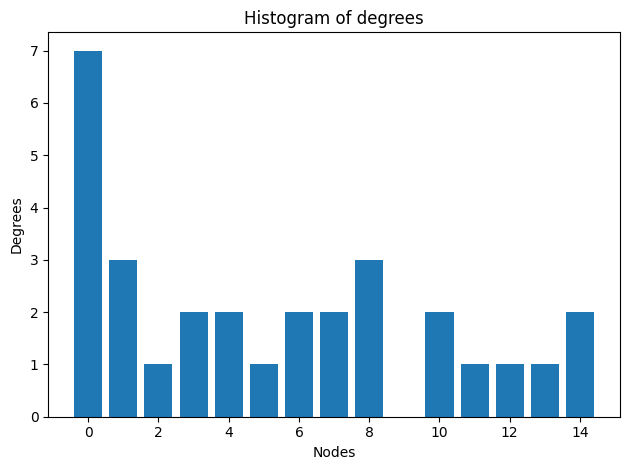

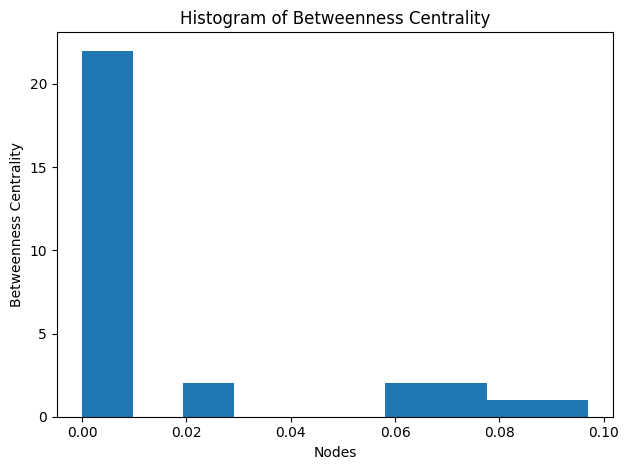

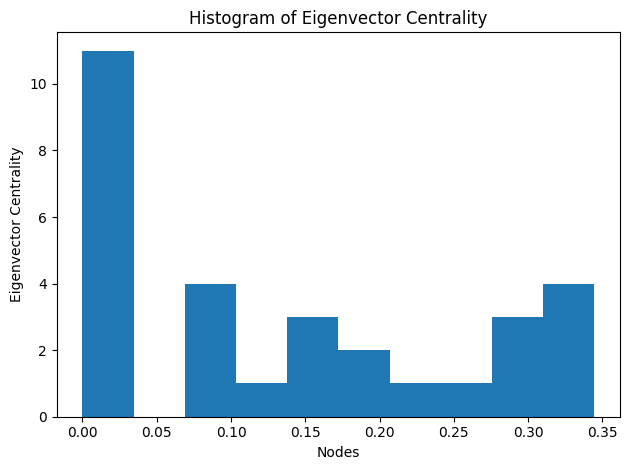

##### Global Summaries #####
Diameter :  Found infinite path length because the graph is not connected !
Number of Nodes :  79
Number of Edges :  30
Number of Connected Components :  8
Size of the Largest Connected Compopnent :  23

 CIRCLE12 



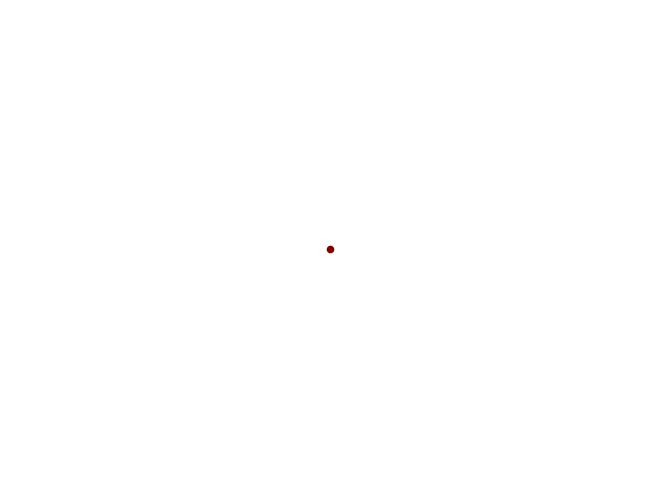

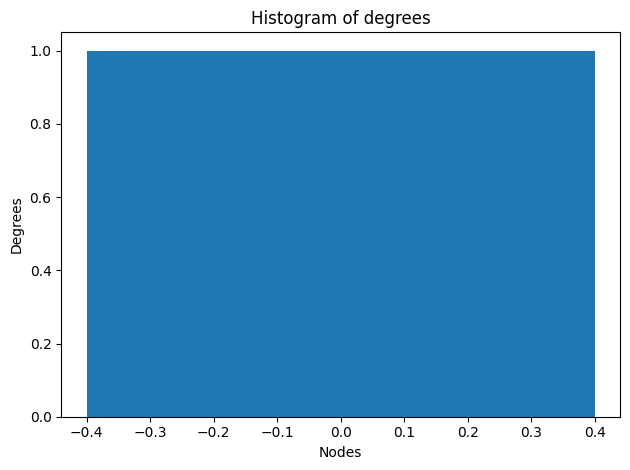

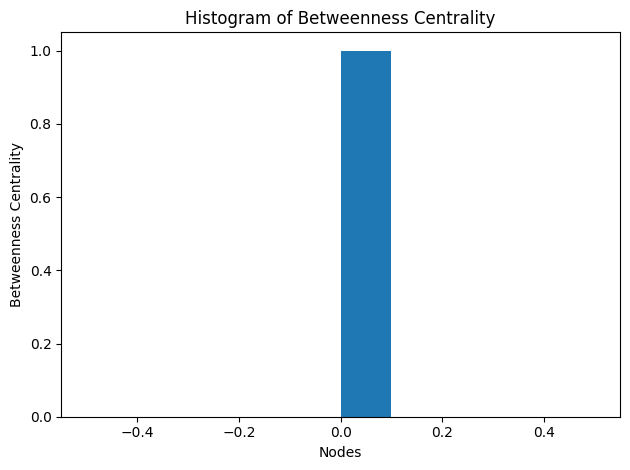

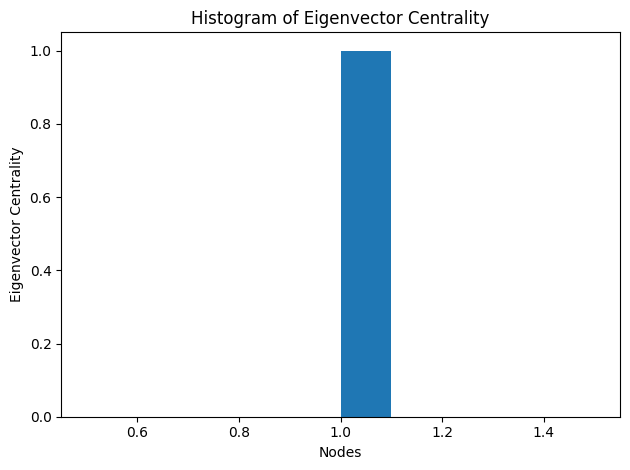

##### Global Summaries #####
Diameter :  0
Number of Nodes :  0
Number of Edges :  1
Number of Connected Components :  1
Size of the Largest Connected Compopnent :  1

 CIRCLE13 



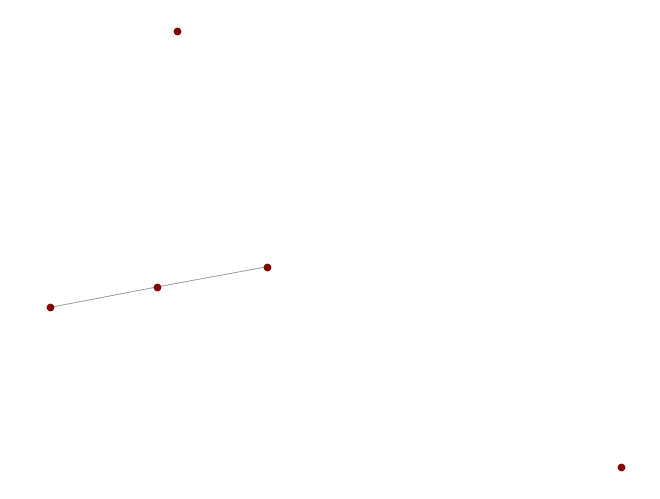

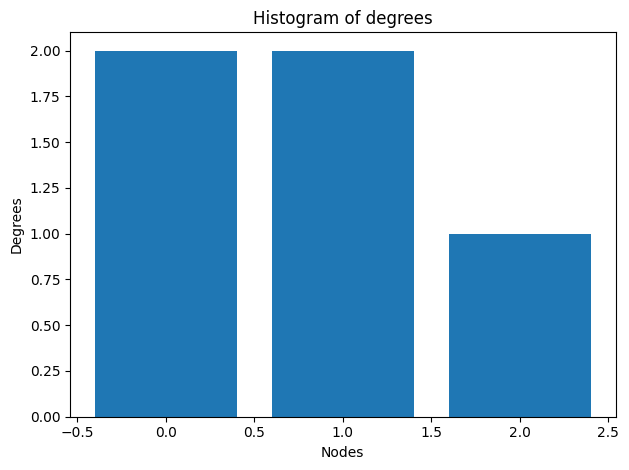

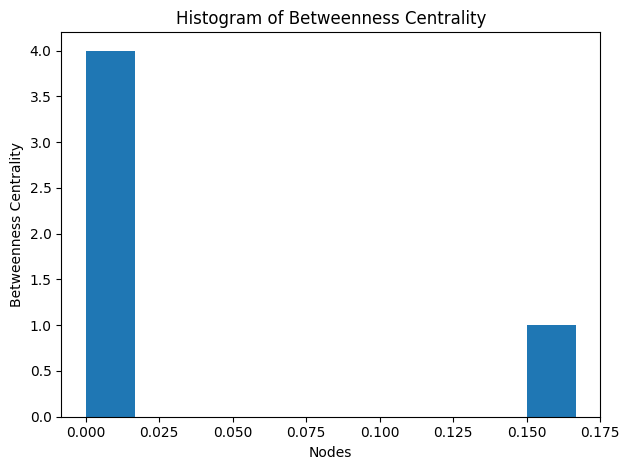

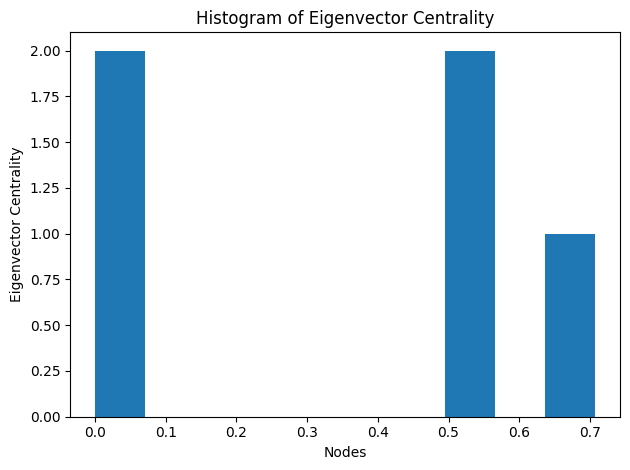

##### Global Summaries #####
Diameter :  Found infinite path length because the graph is not connected !
Number of Nodes :  2
Number of Edges :  5
Number of Connected Components :  3
Size of the Largest Connected Compopnent :  3

 CIRCLE14 



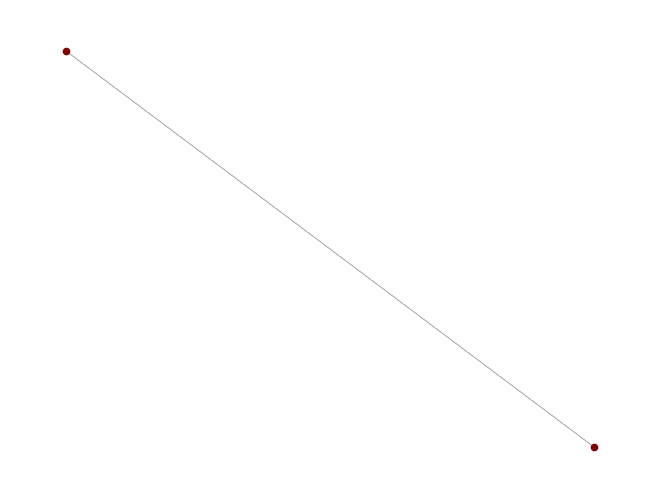

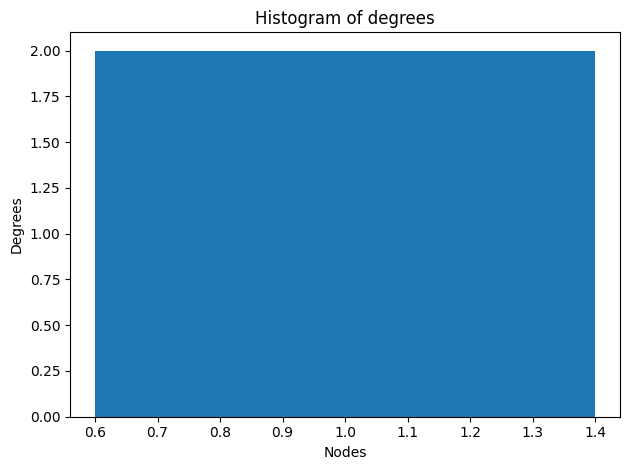

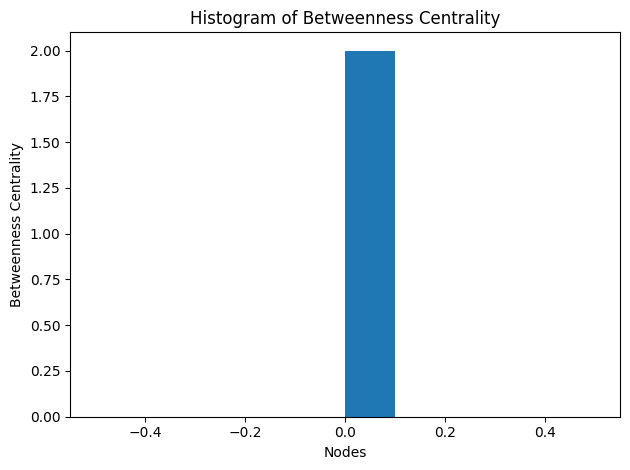

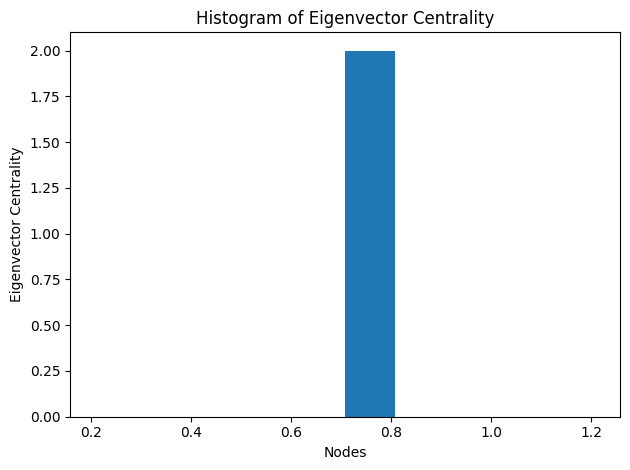

##### Global Summaries #####
Diameter :  1
Number of Nodes :  1
Number of Edges :  2
Number of Connected Components :  1
Size of the Largest Connected Compopnent :  2

 CIRCLE15 



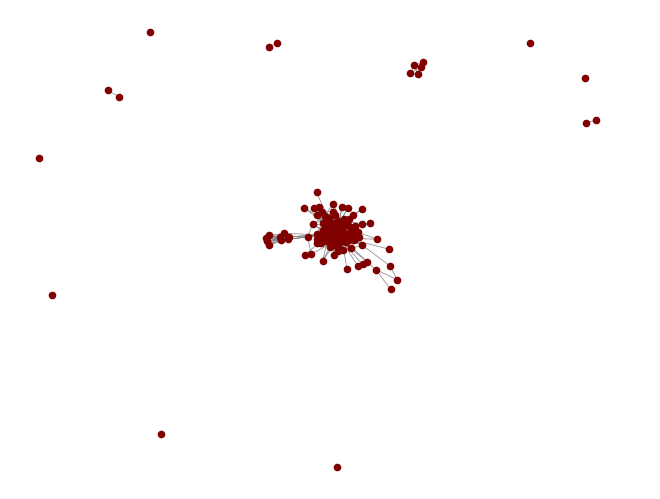

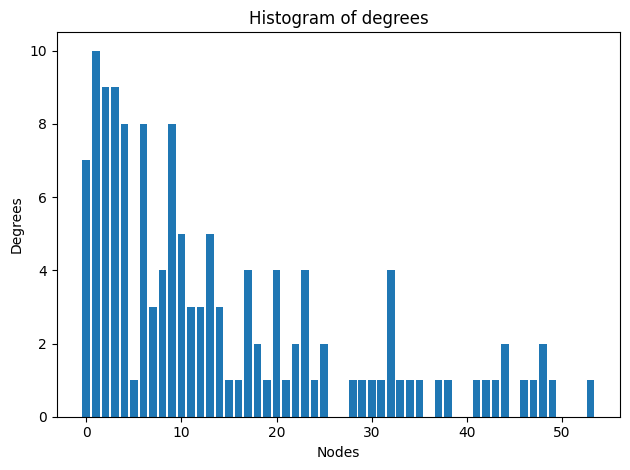

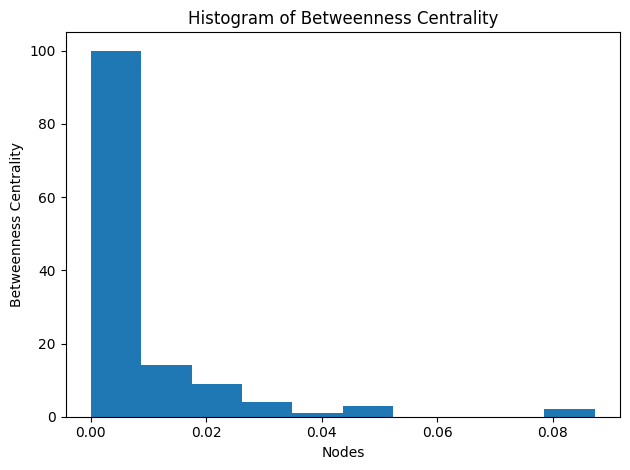

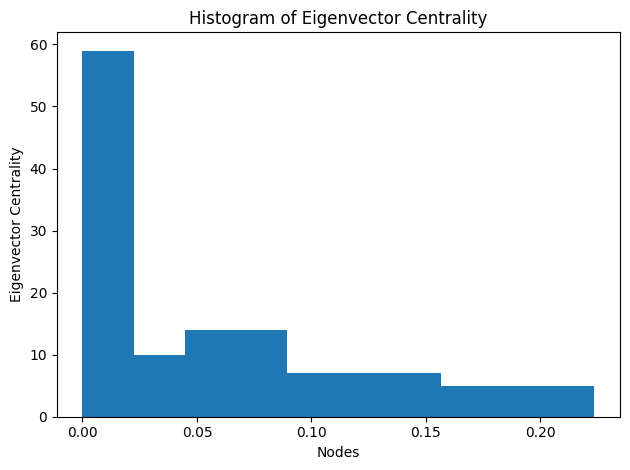

##### Global Summaries #####
Diameter :  Found infinite path length because the graph is not connected !
Number of Nodes :  942
Number of Edges :  133
Number of Connected Components :  12
Size of the Largest Connected Compopnent :  115

 CIRCLE16 



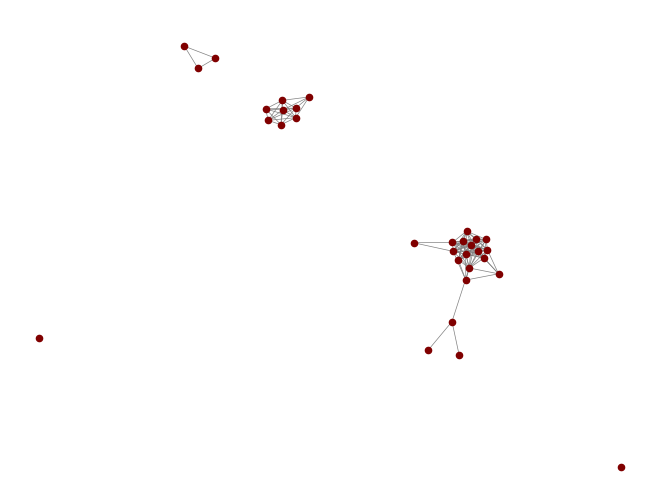

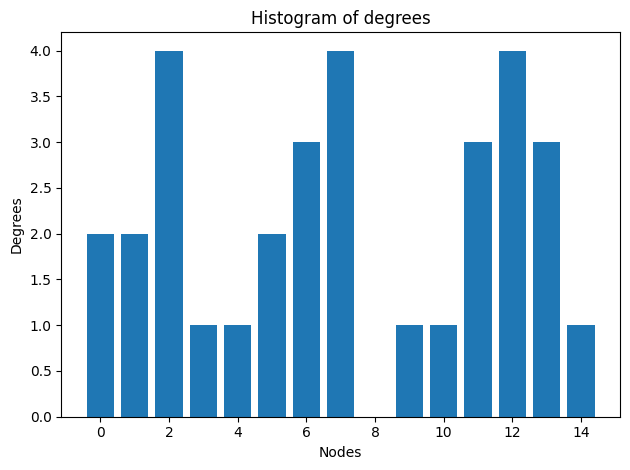

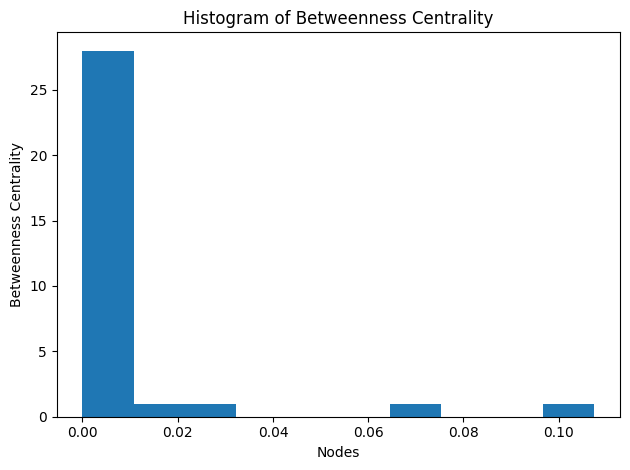

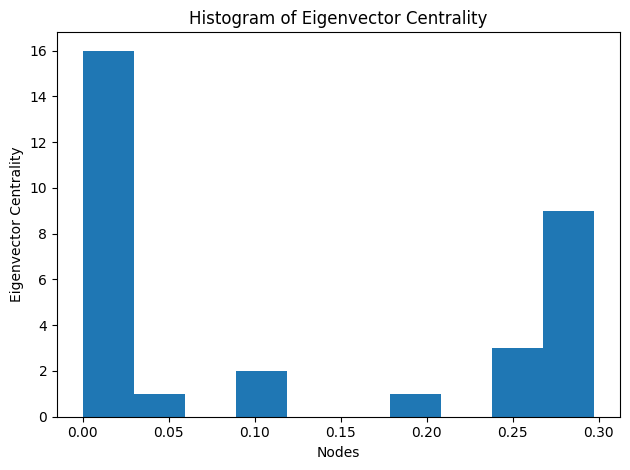

##### Global Summaries #####
Diameter :  Found infinite path length because the graph is not connected !
Number of Nodes :  113
Number of Edges :  32
Number of Connected Components :  5
Size of the Largest Connected Compopnent :  19

 CIRCLE17 



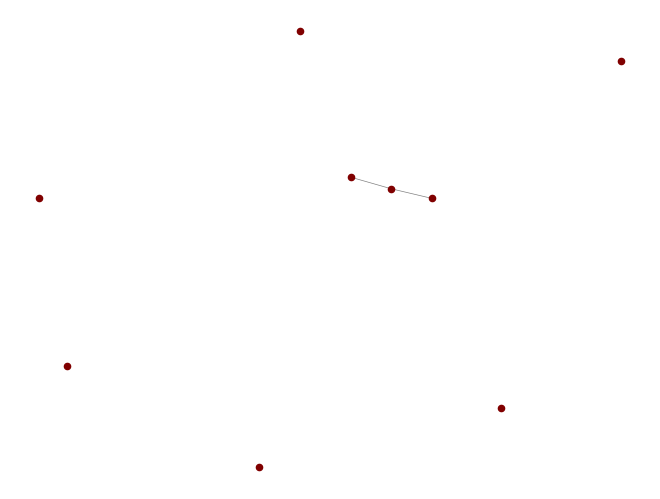

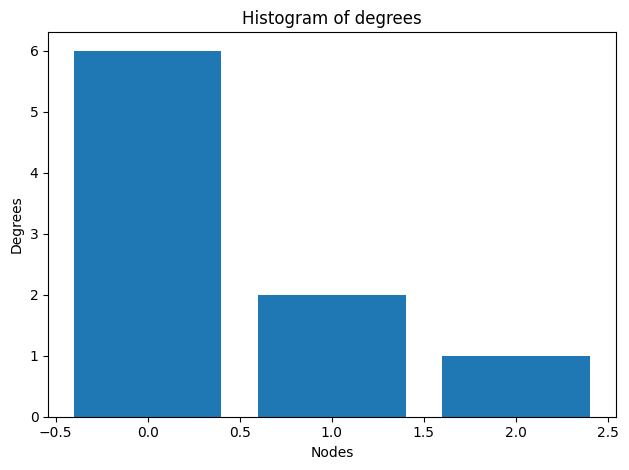

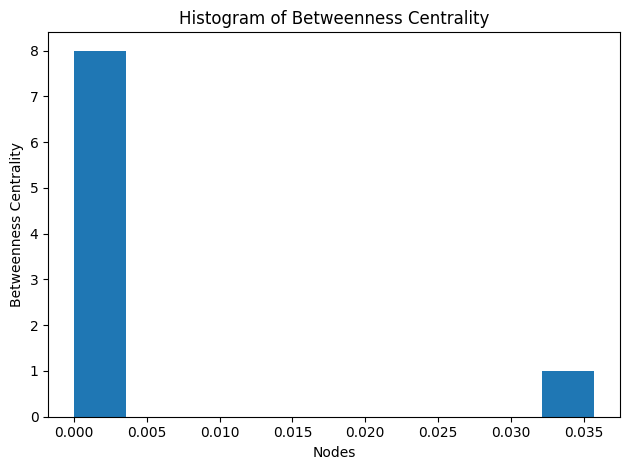

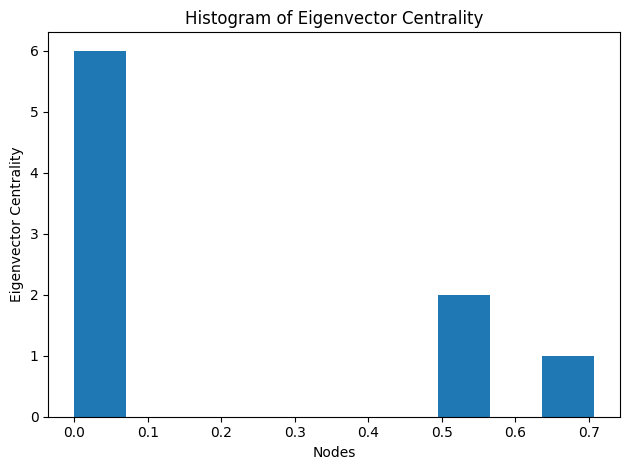

##### Global Summaries #####
Diameter :  Found infinite path length because the graph is not connected !
Number of Nodes :  2
Number of Edges :  9
Number of Connected Components :  7
Size of the Largest Connected Compopnent :  3

 CIRCLE18 



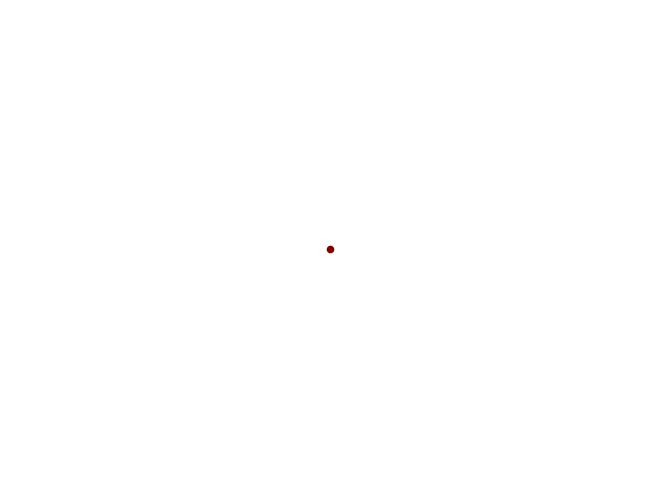

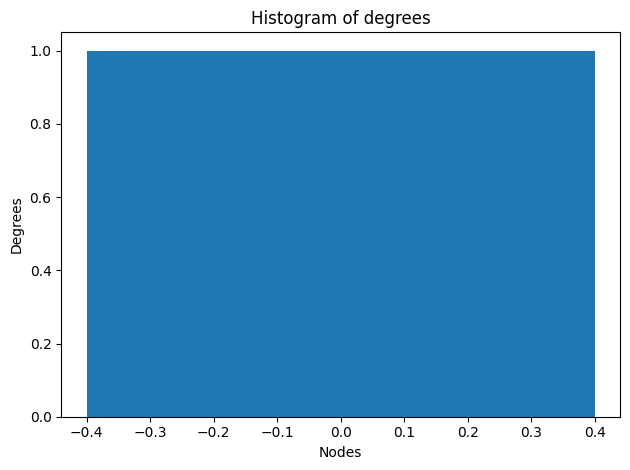

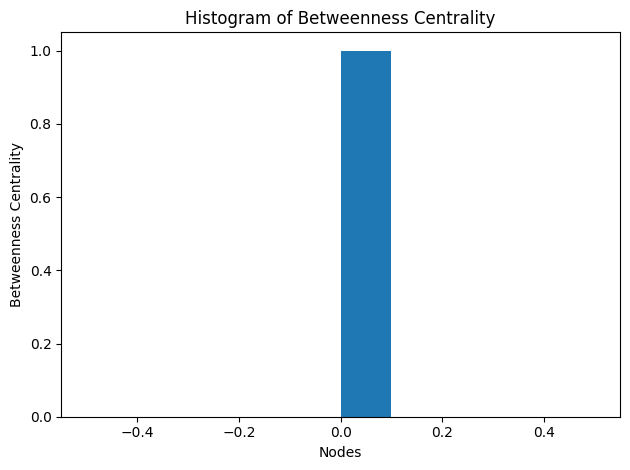

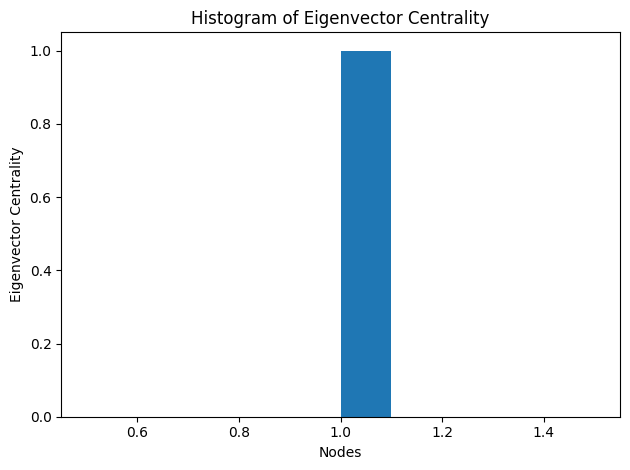

##### Global Summaries #####
Diameter :  0
Number of Nodes :  0
Number of Edges :  1
Number of Connected Components :  1
Size of the Largest Connected Compopnent :  1

 CIRCLE19 



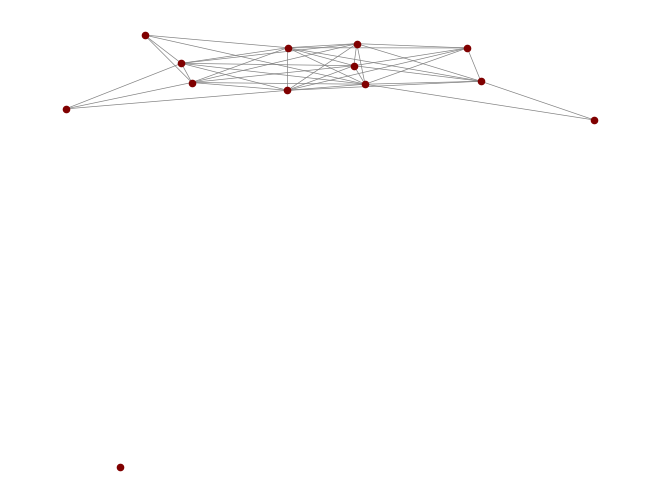

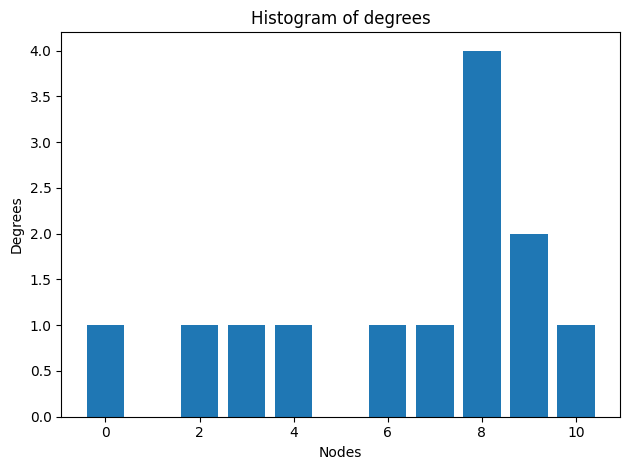

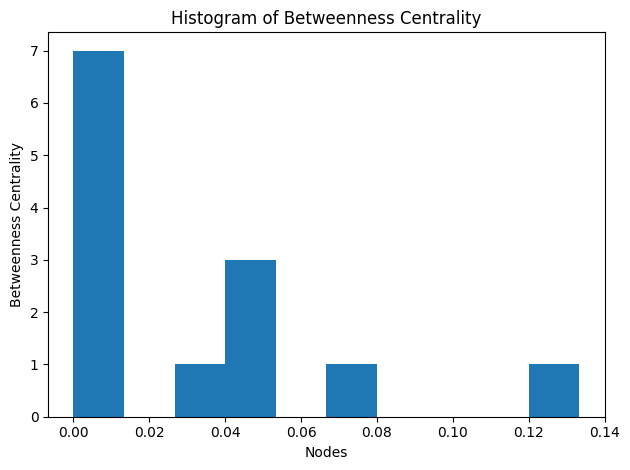

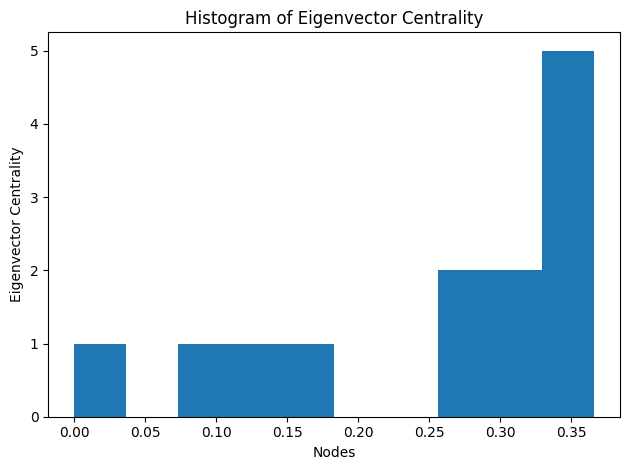

##### Global Summaries #####
Diameter :  Found infinite path length because the graph is not connected !
Number of Nodes :  41
Number of Edges :  13
Number of Connected Components :  2
Size of the Largest Connected Compopnent :  12

 CIRCLE20 



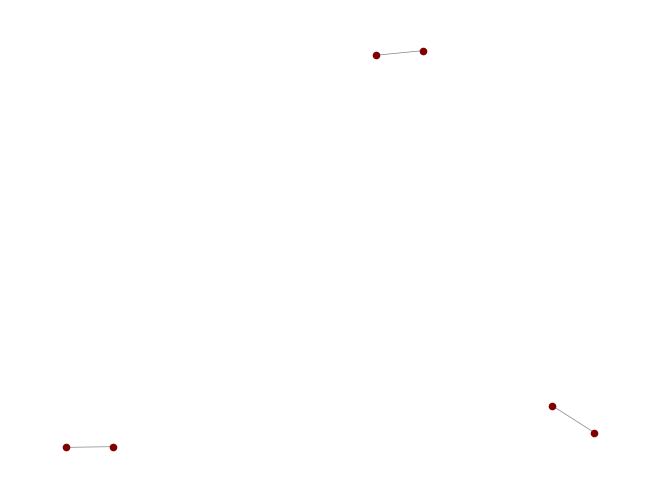

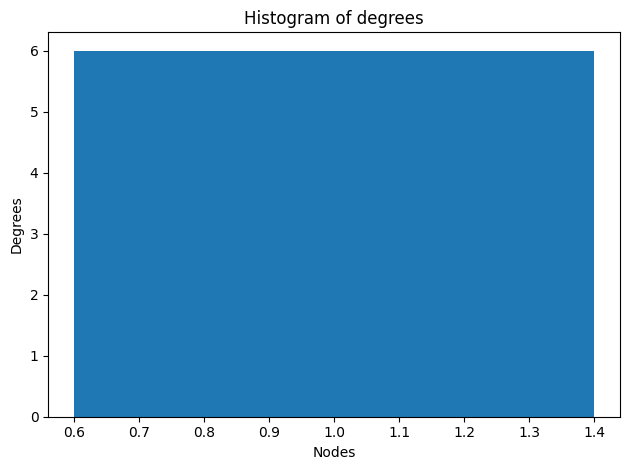

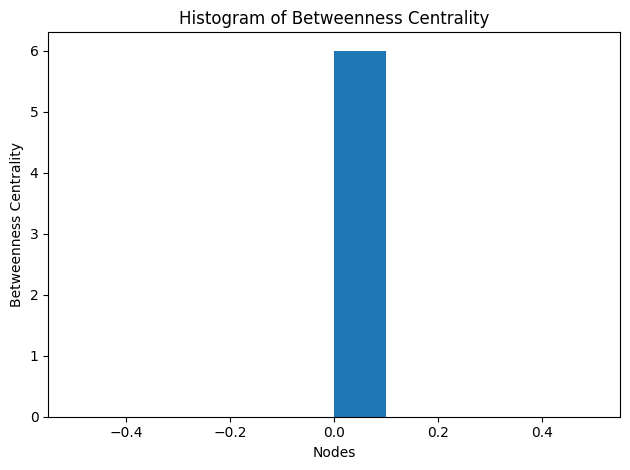

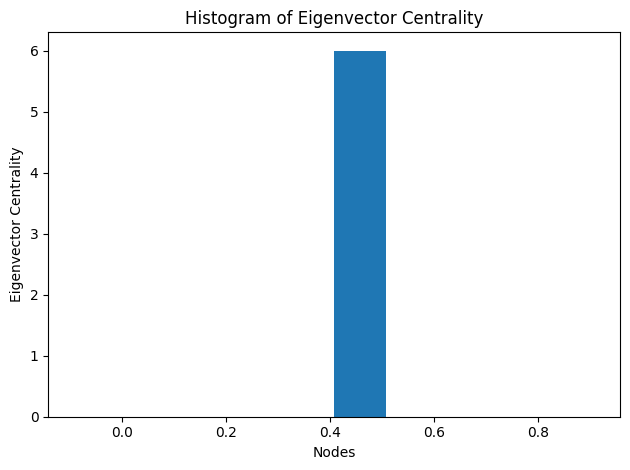

##### Global Summaries #####
Diameter :  Found infinite path length because the graph is not connected !
Number of Nodes :  3
Number of Edges :  6
Number of Connected Components :  3
Size of the Largest Connected Compopnent :  2

 CIRCLE21 



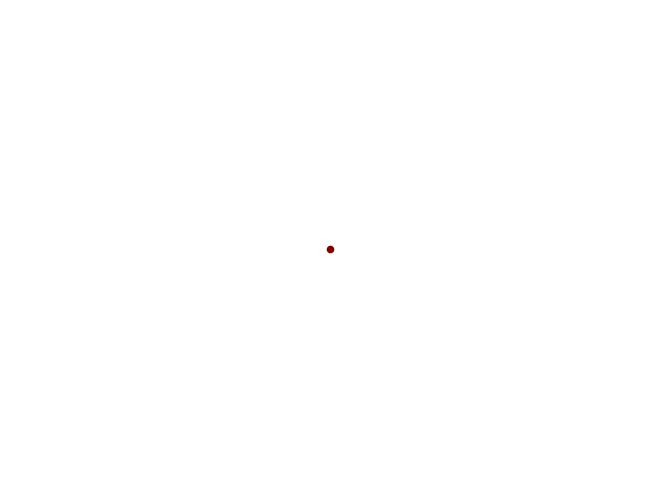

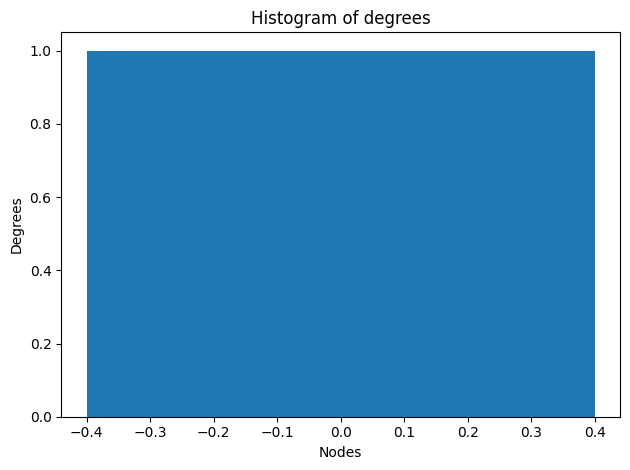

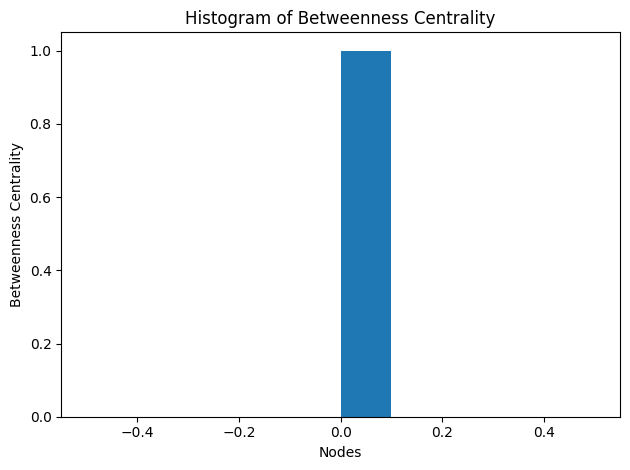

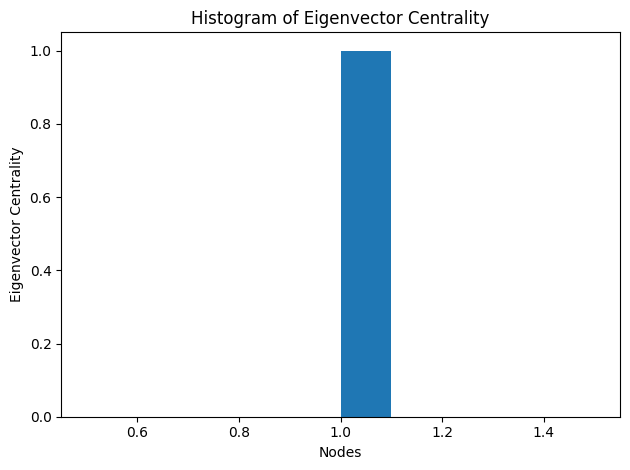

##### Global Summaries #####
Diameter :  0
Number of Nodes :  0
Number of Edges :  1
Number of Connected Components :  1
Size of the Largest Connected Compopnent :  1

 CIRCLE22 



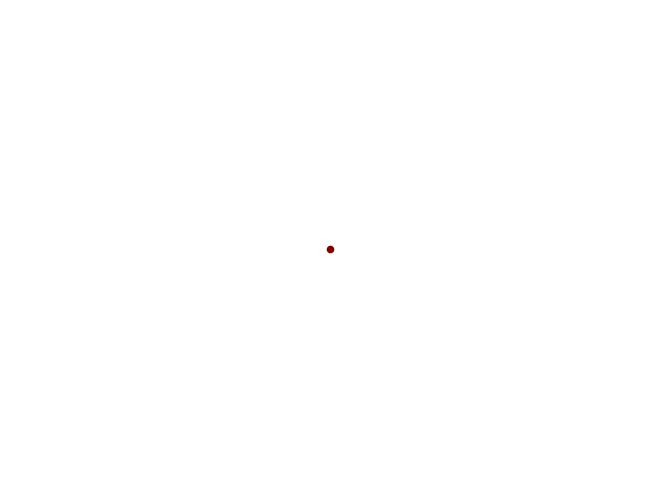

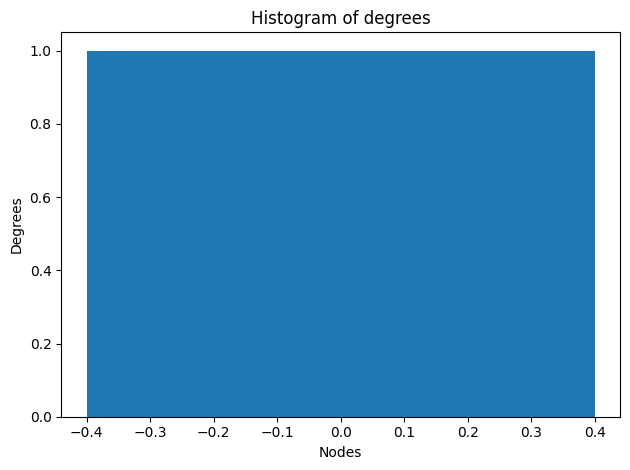

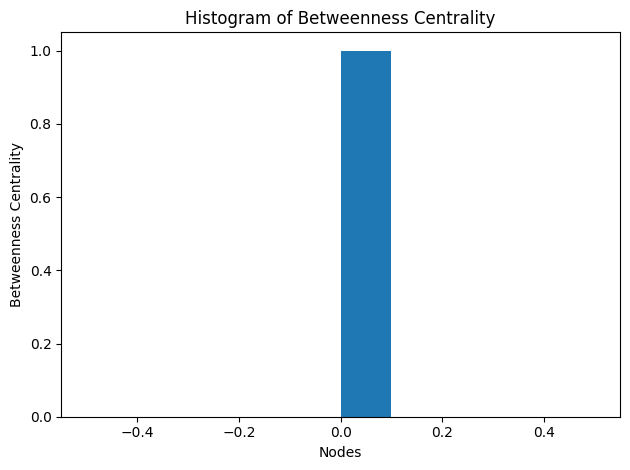

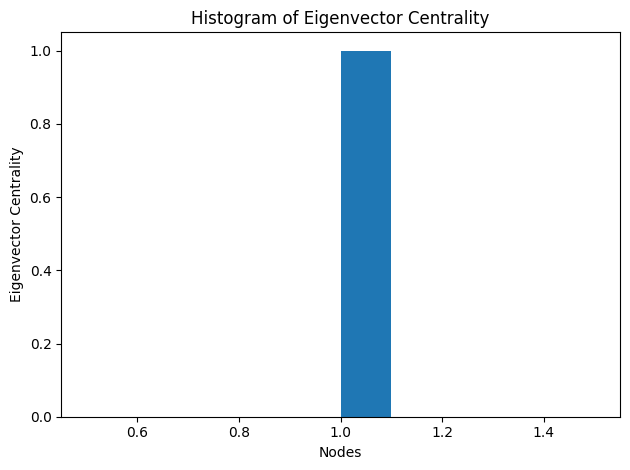

##### Global Summaries #####
Diameter :  0
Number of Nodes :  0
Number of Edges :  1
Number of Connected Components :  1
Size of the Largest Connected Compopnent :  1

 CIRCLE23 



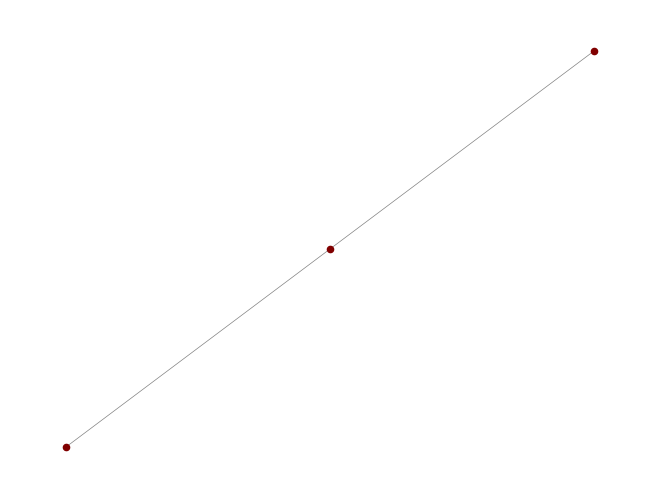

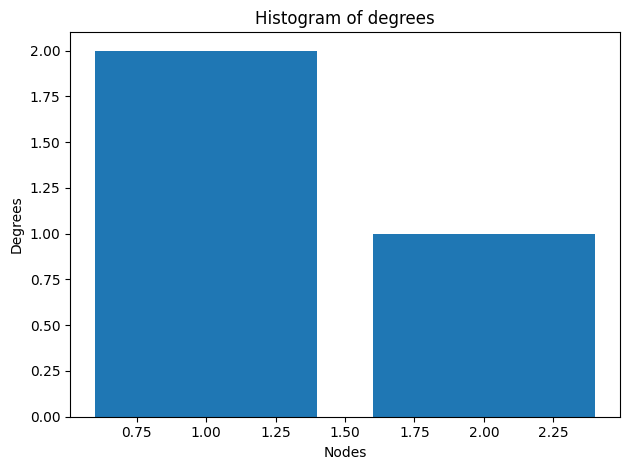

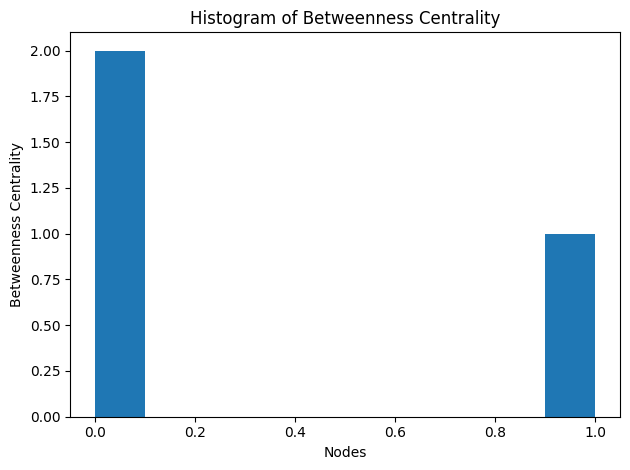

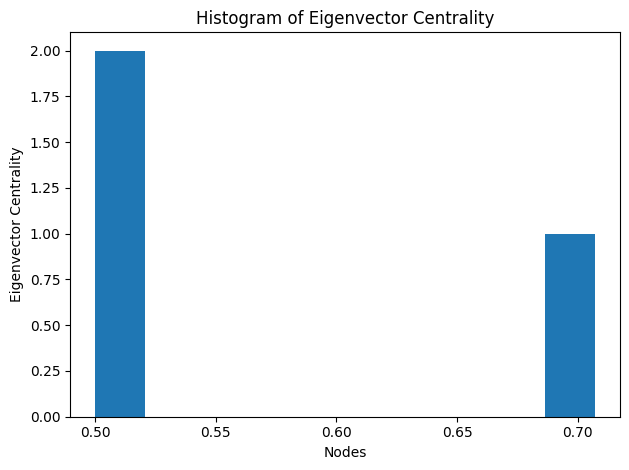

##### Global Summaries #####
Diameter :  2
Number of Nodes :  2
Number of Edges :  3
Number of Connected Components :  1
Size of the Largest Connected Compopnent :  3


In [10]:
for c in circles:
    print("\n",c.upper(),"\n")
    explore_and_summarize_network(edgelist = list(G.edges()), vertices=list(G.nodes()), subgraph=circles[c])

# Link Prediction using DGL

In [11]:
# install DGL in Colab
!pip install dgl -f https://data.dgl.ai/wheels/repo.html

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in links: https://data.dgl.ai/wheels/repo.html
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.6/5.6 MB 51.6 MB/s eta 0:00:00


In [12]:
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import itertools
import numpy as np
import scipy.sparse as sp
import dgl

DGL backend not selected or invalid.  Assuming PyTorch for now.


Setting the default backend to "pytorch". You can change it in the ~/.dgl/config.json file or export the DGLBACKEND environment variable.  Valid options are: pytorch, mxnet, tensorflow (all lowercase)


To proceed with friend recommendations, we must first load the friendship connections (edges) into the graph. Additionally, the files contain information about user features represented by a 224-dimensional vector consisting of 0s and 1s, which we will also load. For the purpose of simplifying the problem, we will only focus on a single ego network, specifically the network belonging to User 0.

In [13]:
# user id, which correspond to file name prefix
USER = 0

file_edges = f'facebook/{USER}.edges'
file_feat = f'facebook/{USER}.feat'

edges_u, edges_v = [], []

with open(file_edges) as f:  # load edges file
    for line in f:
        e1, e2 = tuple(int(x) - 1 for x in line.split())
        edges_u.append(e1)
        edges_v.append(e2)

edges_u, edges_v = np.array(edges_u), np.array(edges_v)

num_nodes = 0  # assumes nodes are sequential
feats = []  # node features

with open(file_feat) as f:  # load node features file
    for line in f:
        num_nodes += 1
        a = [int(x) for x in line.split()[1:]]  # 0th entry is node id
        feats.append(torch.tensor(a, dtype=torch.float))

feats = torch.stack(feats)

g = dgl.graph((edges_u, edges_v))  # construct graph
g.ndata['feat'] = feats

g  # print graph metadata

Graph(num_nodes=347, num_edges=5038,
      ndata_schemes={'feat': Scheme(shape=(224,), dtype=torch.float32)}
      edata_schemes={})

## Training/Test data split

After creating the graph, we need to divide it into two sets - training and testing. To do this, we create a graph of "negative edges" where any missing edges in the original graph are represented as edges in the negative graph. This helps the training algorithm identify negative examples.

We randomly select 30% of the links for testing purposes, and the remaining 70% are kept for training. We are not using a validation set for simplicity.

In [15]:
TEST_RATIO = 0.3  # ratio for splitting the test set

u, v = g.edges()

eids = np.arange(g.number_of_edges())
eids = np.random.permutation(eids)
test_size = int(len(eids) * TEST_RATIO)  # number of edges in test set
train_size = g.number_of_edges() - test_size  # number of edges in train set

# get positive edges for test and train
test_pos_u, test_pos_v = u[eids[:test_size]], v[eids[:test_size]]
train_pos_u, train_pos_v = u[eids[test_size:]], v[eids[test_size:]]

# Find all negative edges
adj = sp.coo_matrix((np.ones(len(u)), (u.numpy(), v.numpy())))
adj_neg = 1 - adj.todense() - np.eye(g.number_of_nodes())
neg_u, neg_v = np.where(adj_neg != 0)

# split the negative edges for training and testing 
neg_eids = np.random.choice(len(neg_u), g.number_of_edges())
test_neg_u, test_neg_v = neg_u[neg_eids[:test_size]], neg_v[neg_eids[:test_size]]
train_neg_u, train_neg_v = neg_u[neg_eids[test_size:]], neg_v[neg_eids[test_size:]]

# construct positive and negative graphs for training and testing
train_pos_g = dgl.graph((train_pos_u, train_pos_v), num_nodes=g.number_of_nodes())
train_neg_g = dgl.graph((train_neg_u, train_neg_v), num_nodes=g.number_of_nodes())

test_pos_g = dgl.graph((test_pos_u, test_pos_v), num_nodes=g.number_of_nodes())
test_neg_g = dgl.graph((test_neg_u, test_neg_v), num_nodes=g.number_of_nodes())

# training graph
train_g = dgl.remove_edges(g, eids[:test_size])
train_g = dgl.add_self_loop(train_g)

In [53]:
train_pos_g

Graph(num_nodes=347, num_edges=3527,
      ndata_schemes={}
      edata_schemes={})

In [54]:
train_neg_g

Graph(num_nodes=347, num_edges=3527,
      ndata_schemes={}
      edata_schemes={})

## Modeling

We are creating two models using the implementation in the DGL library. Both models have two convolutional layers. The first model is GCN, which is a typical graph convolutional network and acts as a baseline. The second model is GraphSAGE, which is a more advanced and powerful network that we want to test.

We also define the DotPredictor, which is used to predict whether an edge exists between two nodes or not. It calculates the likelihood by taking the dot product of the two nodes.

In [16]:
from dgl.nn import SAGEConv
from dgl.nn import GraphConv
from dgl.nn import GATConv
from dgl.nn import GINConv

import dgl.function as fn

# ----------- create model -------------- #
# build an ordinary GCN model
class GCN(nn.Module):
    def __init__(self, in_feats, h_feats):
        super(GCN, self).__init__()
        self.conv1 = GraphConv(in_feats, h_feats)
        self.conv2 = GraphConv(h_feats, h_feats)

    def forward(self, g, in_feat):
        h = self.conv1(g, in_feat)
        h = F.relu(h)
        h = self.conv2(g, h)
        return h


# build a two-layer GraphSAGE model
class GraphSAGE(nn.Module):
    def __init__(self, in_feats, h_feats):
        super(GraphSAGE, self).__init__()
        self.conv1 = SAGEConv(in_feats, h_feats, 'mean')
        self.conv2 = SAGEConv(h_feats, h_feats, 'mean')

    def forward(self, g, in_feat):
        h = self.conv1(g, in_feat)
        h = F.relu(h)
        h = self.conv2(g, h)
        return h

# build a GAT model
class GAT(nn.Module):
    def __init__(self, in_feats, h_feats):
        super(GAT, self).__init__()
        self.conv1 = GATConv(in_feats, h_feats, num_heads=8)
        self.conv2 = GATConv(h_feats * 8, h_feats, num_heads=1)

    def forward(self, g, in_feat):
        h = self.conv1(g, in_feat).flatten(1)
        h = F.elu(h)
        h = self.conv2(g, h).mean(1)
        return h

# build a GIN(Graph Isomorphism Network) model
class GIN(nn.Module):
    def __init__(self, in_feats, h_feats):
        super(GIN, self).__init__()
        self.conv1 = GINConv(nn.Sequential(nn.Linear(in_feats, h_feats), nn.ReLU(), nn.Linear(h_feats, h_feats)))
        self.conv2 = GINConv(nn.Sequential(nn.Linear(h_feats, h_feats), nn.ReLU(), nn.Linear(h_feats, h_feats)))

    def forward(self, g, in_feat):
        h = self.conv1(g, in_feat)
        h = F.relu(h)
        h = self.conv2(g, h)
        return h


class DotPredictor(nn.Module):
    def forward(self, g, h):
        with g.local_scope():
            g.ndata['h'] = h
            # Compute a new edge feature named 'score' by a dot-product between the
            # source node feature 'h' and destination node feature 'h'.
            g.apply_edges(fn.u_dot_v('h', 'h', 'score'))
            # u_dot_v returns a 1-element vector for each edge so you need to squeeze it.
            return g.edata['score'][:, 0]


## Training and testing pipeline

In [90]:
def pipeline(model_name='GCN', hidden_size=16, learning_rate=0.01):
    # model_name can be GCN or SAGE
    # hidden_size is the size of the hidden layer in the neural net
    if model_name == 'GCN':
        model = GCN(train_g.ndata['feat'].shape[1], hidden_size)
    elif model_name == 'SAGE':
        model = GraphSAGE(train_g.ndata['feat'].shape[1], hidden_size)
    elif model_name == 'GAT':
        model = GAT(train_g.ndata['feat'].shape[1], hidden_size)
    elif model_name == 'GIN':
        model = GIN(train_g.ndata['feat'].shape[1], hidden_size)
        
    pred = DotPredictor()

    def compute_loss(pos_score, neg_score):  # computes the loss based on binary cross entropy
        scores = F.sigmoid(torch.cat([pos_score, neg_score]))
        labels = torch.cat([torch.ones(pos_score.shape[0]), torch.zeros(neg_score.shape[0])])
        return F.binary_cross_entropy_with_logits(scores, labels)

    def compute_auc(pos_score, neg_score):  # computes AUC (Area-Under-Curve) score
        scores = F.sigmoid(torch.cat([pos_score, neg_score])).numpy()
        labels = torch.cat([torch.ones(pos_score.shape[0]), torch.zeros(neg_score.shape[0])]).numpy()
        return roc_auc_score(labels, scores)
    
    def compute_acc(pos_score, neg_score):
      scores = F.sigmoid(torch.cat([pos_score, neg_score])).numpy()
      scores = scores>0.5
      labels = torch.cat([torch.ones(pos_score.shape[0]), torch.zeros(neg_score.shape[0])]).numpy()
      return accuracy_score(labels, scores)


    # ----------- set up loss and optimizer -------------- #
    # in this case, loss will in training loop
    optimizer = torch.optim.Adam(itertools.chain(model.parameters(), pred.parameters()), lr=learning_rate)

    # ----------- training -------------------------------- #
    all_logits = []
    best_test_loss = 100

    for e in range(100):
        # forward
        h = model(train_g, train_g.ndata['feat'])  # get node embeddings
        pos_score = pred(train_pos_g, h)
        neg_score = pred(train_neg_g, h)
        #print("pos score: ", pos_score)
        #print("neg score: ", neg_score)
        loss = compute_loss(pos_score, neg_score)
        # backward
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        # test
        test_pos_score = pred(test_pos_g, h)
        test_neg_score = pred(test_neg_g, h)
        test_loss = compute_loss(test_pos_score, test_neg_score)

        if test_loss < best_test_loss:
            best_test_loss = test_loss
            torch.save(model.state_dict(), 'best_model.pth')

        if e % 5 == 0:
            print(f'In epoch {e}, train_loss: {loss:.3f}, test_loss: {test_loss:.3f}')

        

    # ----------- test and check results ---------------- #
    from sklearn.metrics import roc_auc_score, accuracy_score
    model.load_state_dict(torch.load('best_model.pth'))
    h = model(train_g, train_g.ndata['feat'])  # get node embeddings using best model
    with torch.no_grad():
        pos_score = pred(test_pos_g, h)
        neg_score = pred(test_neg_g, h)
        AUC = compute_auc(pos_score, neg_score)
        Acc = compute_acc(pos_score, neg_score)
        print('Acc', Acc)
        print('AUC', AUC)

    
    return h, AUC, Acc # return node embeddings


In [76]:
a = np.array([1,2,3,4])
1/(1+np.exp(-a))

array([0.73105858, 0.88079708, 0.95257413, 0.98201379])

## Hyperparameter tuning & model comparisons

In [96]:
def tuning(model_name:str):
  hidden_size = [8,16,32,64]
  learning_rate = [0.1, 0.01, 0.005, 0.001]
  best_auc = 0
  best_acc = 0
  best_hs = 0
  best_lr = 0
  best_h = None
  for hs in hidden_size:
      for lr in learning_rate:
        print(f'*** hidden size: {hs},learning rate: {lr}***')
        h, auc, acc  = pipeline(model_name,hs,lr)
        if auc > best_auc:
          best_auc = auc
          best_hs = hs
          best_lr = lr
          best_h = h
        if acc > best_acc:
          best_acc = acc
  print(50*"=")
  print(f'Best AUC obtained {best_auc:.3f} at hidden size {best_hs} and learning rate {best_lr}')
  print(f'Best Acc obtained {best_acc:.3f} at hidden size {best_hs} and learning rate {best_lr}')
  return best_h, best_auc, best_acc

In [97]:
h_GCN, AUC_GCN, Acc_GCN = tuning("GCN")

*** hidden size: 8,learning rate: 0.1***
In epoch 0, train_loss: 0.723, test_loss: 0.723
In epoch 5, train_loss: 0.667, test_loss: 0.674
In epoch 10, train_loss: 0.656, test_loss: 0.662
In epoch 15, train_loss: 0.655, test_loss: 0.661
In epoch 20, train_loss: 0.655, test_loss: 0.661


/usr/local/lib/python3.9/dist-packages/dgl/backend/pytorch/tensor.py:445: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  assert input.numel() == input.storage().size(), (


In epoch 25, train_loss: 0.654, test_loss: 0.661
In epoch 30, train_loss: 0.654, test_loss: 0.660
In epoch 35, train_loss: 0.653, test_loss: 0.660
In epoch 40, train_loss: 0.652, test_loss: 0.658
In epoch 45, train_loss: 0.651, test_loss: 0.657
In epoch 50, train_loss: 0.649, test_loss: 0.655
In epoch 55, train_loss: 0.647, test_loss: 0.653
In epoch 60, train_loss: 0.645, test_loss: 0.650
In epoch 65, train_loss: 0.639, test_loss: 0.643
In epoch 70, train_loss: 0.634, test_loss: 0.639
In epoch 75, train_loss: 0.632, test_loss: 0.635
In epoch 80, train_loss: 0.629, test_loss: 0.633
In epoch 85, train_loss: 0.628, test_loss: 0.632
In epoch 90, train_loss: 0.626, test_loss: 0.631
In epoch 95, train_loss: 0.624, test_loss: 0.630
Acc 0.7832561217736598
AUC 0.8159970496526465
*** hidden size: 8,learning rate: 0.01***
In epoch 0, train_loss: 0.720, test_loss: 0.720
In epoch 5, train_loss: 0.690, test_loss: 0.694
In epoch 10, train_loss: 0.667, test_loss: 0.672
In epoch 15, train_loss: 0.658, 

/usr/local/lib/python3.9/dist-packages/dgl/backend/pytorch/tensor.py:445: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  assert input.numel() == input.storage().size(), (


In epoch 25, train_loss: 0.650, test_loss: 0.657
In epoch 30, train_loss: 0.646, test_loss: 0.654
In epoch 35, train_loss: 0.643, test_loss: 0.650
In epoch 40, train_loss: 0.640, test_loss: 0.647
In epoch 45, train_loss: 0.637, test_loss: 0.645
In epoch 50, train_loss: 0.634, test_loss: 0.642
In epoch 55, train_loss: 0.631, test_loss: 0.638
In epoch 60, train_loss: 0.627, test_loss: 0.634
In epoch 65, train_loss: 0.625, test_loss: 0.631
In epoch 70, train_loss: 0.623, test_loss: 0.629
In epoch 75, train_loss: 0.621, test_loss: 0.626
In epoch 80, train_loss: 0.620, test_loss: 0.625
In epoch 85, train_loss: 0.619, test_loss: 0.625
In epoch 90, train_loss: 0.618, test_loss: 0.624
In epoch 95, train_loss: 0.617, test_loss: 0.624
Acc 0.8021178027796162
AUC 0.8523359033533484
*** hidden size: 8,learning rate: 0.005***
In epoch 0, train_loss: 0.721, test_loss: 0.722
In epoch 5, train_loss: 0.704, test_loss: 0.706
In epoch 10, train_loss: 0.685, test_loss: 0.688


/usr/local/lib/python3.9/dist-packages/dgl/backend/pytorch/tensor.py:445: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  assert input.numel() == input.storage().size(), (


In epoch 15, train_loss: 0.668, test_loss: 0.673
In epoch 20, train_loss: 0.659, test_loss: 0.666
In epoch 25, train_loss: 0.656, test_loss: 0.663
In epoch 30, train_loss: 0.654, test_loss: 0.661
In epoch 35, train_loss: 0.653, test_loss: 0.660
In epoch 40, train_loss: 0.652, test_loss: 0.660
In epoch 45, train_loss: 0.652, test_loss: 0.660
In epoch 50, train_loss: 0.652, test_loss: 0.660
In epoch 55, train_loss: 0.651, test_loss: 0.660
In epoch 60, train_loss: 0.651, test_loss: 0.660
In epoch 65, train_loss: 0.651, test_loss: 0.660
In epoch 70, train_loss: 0.650, test_loss: 0.659
In epoch 75, train_loss: 0.650, test_loss: 0.659
In epoch 80, train_loss: 0.649, test_loss: 0.658
In epoch 85, train_loss: 0.648, test_loss: 0.657
In epoch 90, train_loss: 0.647, test_loss: 0.656
In epoch 95, train_loss: 0.645, test_loss: 0.655
Acc 0.7471872931833223
AUC 0.8788818025851455
*** hidden size: 8,learning rate: 0.001***
In epoch 0, train_loss: 0.721, test_loss: 0.722
In epoch 5, train_loss: 0.717,

/usr/local/lib/python3.9/dist-packages/dgl/backend/pytorch/tensor.py:445: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  assert input.numel() == input.storage().size(), (


In epoch 15, train_loss: 0.708, test_loss: 0.710
In epoch 20, train_loss: 0.703, test_loss: 0.706
In epoch 25, train_loss: 0.699, test_loss: 0.702
In epoch 30, train_loss: 0.695, test_loss: 0.699
In epoch 35, train_loss: 0.691, test_loss: 0.695
In epoch 40, train_loss: 0.687, test_loss: 0.692
In epoch 45, train_loss: 0.683, test_loss: 0.689
In epoch 50, train_loss: 0.680, test_loss: 0.686
In epoch 55, train_loss: 0.677, test_loss: 0.683
In epoch 60, train_loss: 0.674, test_loss: 0.680
In epoch 65, train_loss: 0.671, test_loss: 0.677
In epoch 70, train_loss: 0.668, test_loss: 0.675
In epoch 75, train_loss: 0.666, test_loss: 0.673
In epoch 80, train_loss: 0.664, test_loss: 0.671
In epoch 85, train_loss: 0.662, test_loss: 0.669
In epoch 90, train_loss: 0.660, test_loss: 0.668
In epoch 95, train_loss: 0.659, test_loss: 0.667
Acc 0.7336201191264063
AUC 0.8784032909337701
*** hidden size: 16,learning rate: 0.1***
In epoch 0, train_loss: 0.728, test_loss: 0.729
In epoch 5, train_loss: 0.673, 

/usr/local/lib/python3.9/dist-packages/dgl/backend/pytorch/tensor.py:445: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  assert input.numel() == input.storage().size(), (


In epoch 10, train_loss: 0.650, test_loss: 0.661
In epoch 15, train_loss: 0.652, test_loss: 0.664
In epoch 20, train_loss: 0.652, test_loss: 0.664
In epoch 25, train_loss: 0.649, test_loss: 0.660
In epoch 30, train_loss: 0.645, test_loss: 0.655
In epoch 35, train_loss: 0.643, test_loss: 0.653
In epoch 40, train_loss: 0.642, test_loss: 0.652
In epoch 45, train_loss: 0.640, test_loss: 0.651
In epoch 50, train_loss: 0.640, test_loss: 0.651
In epoch 55, train_loss: 0.639, test_loss: 0.651
In epoch 60, train_loss: 0.638, test_loss: 0.650
In epoch 65, train_loss: 0.638, test_loss: 0.650
In epoch 70, train_loss: 0.637, test_loss: 0.649
In epoch 75, train_loss: 0.637, test_loss: 0.649
In epoch 80, train_loss: 0.636, test_loss: 0.648
In epoch 85, train_loss: 0.636, test_loss: 0.648
In epoch 90, train_loss: 0.635, test_loss: 0.648
In epoch 95, train_loss: 0.635, test_loss: 0.648
Acc 0.713765718067505
AUC 0.7932126680977486
*** hidden size: 16,learning rate: 0.01***
In epoch 0, train_loss: 0.721,

/usr/local/lib/python3.9/dist-packages/dgl/backend/pytorch/tensor.py:445: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  assert input.numel() == input.storage().size(), (


In epoch 30, train_loss: 0.635, test_loss: 0.644
In epoch 35, train_loss: 0.631, test_loss: 0.641
In epoch 40, train_loss: 0.626, test_loss: 0.636
In epoch 45, train_loss: 0.621, test_loss: 0.631
In epoch 50, train_loss: 0.617, test_loss: 0.628
In epoch 55, train_loss: 0.615, test_loss: 0.626
In epoch 60, train_loss: 0.612, test_loss: 0.625
In epoch 65, train_loss: 0.610, test_loss: 0.623
In epoch 70, train_loss: 0.607, test_loss: 0.620
In epoch 75, train_loss: 0.606, test_loss: 0.619
In epoch 80, train_loss: 0.605, test_loss: 0.618
In epoch 85, train_loss: 0.604, test_loss: 0.618
In epoch 90, train_loss: 0.602, test_loss: 0.617
In epoch 95, train_loss: 0.602, test_loss: 0.616
Acc 0.8123759099933818
AUC 0.8357831231897039
*** hidden size: 16,learning rate: 0.005***
In epoch 0, train_loss: 0.722, test_loss: 0.722
In epoch 5, train_loss: 0.701, test_loss: 0.704
In epoch 10, train_loss: 0.678, test_loss: 0.683
In epoch 15, train_loss: 0.662, test_loss: 0.668


/usr/local/lib/python3.9/dist-packages/dgl/backend/pytorch/tensor.py:445: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  assert input.numel() == input.storage().size(), (


In epoch 20, train_loss: 0.656, test_loss: 0.663
In epoch 25, train_loss: 0.653, test_loss: 0.661
In epoch 30, train_loss: 0.652, test_loss: 0.660
In epoch 35, train_loss: 0.651, test_loss: 0.659
In epoch 40, train_loss: 0.649, test_loss: 0.658
In epoch 45, train_loss: 0.647, test_loss: 0.657
In epoch 50, train_loss: 0.646, test_loss: 0.655
In epoch 55, train_loss: 0.643, test_loss: 0.654
In epoch 60, train_loss: 0.641, test_loss: 0.652
In epoch 65, train_loss: 0.639, test_loss: 0.650
In epoch 70, train_loss: 0.635, test_loss: 0.647
In epoch 75, train_loss: 0.631, test_loss: 0.643
In epoch 80, train_loss: 0.628, test_loss: 0.640
In epoch 85, train_loss: 0.625, test_loss: 0.637
In epoch 90, train_loss: 0.623, test_loss: 0.635
In epoch 95, train_loss: 0.621, test_loss: 0.634
Acc 0.7878888153540702
AUC 0.8257604393284457
*** hidden size: 16,learning rate: 0.001***
In epoch 0, train_loss: 0.723, test_loss: 0.724
In epoch 5, train_loss: 0.721, test_loss: 0.722


/usr/local/lib/python3.9/dist-packages/dgl/backend/pytorch/tensor.py:445: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  assert input.numel() == input.storage().size(), (


In epoch 10, train_loss: 0.718, test_loss: 0.719
In epoch 15, train_loss: 0.714, test_loss: 0.715
In epoch 20, train_loss: 0.709, test_loss: 0.711
In epoch 25, train_loss: 0.704, test_loss: 0.706
In epoch 30, train_loss: 0.697, test_loss: 0.700
In epoch 35, train_loss: 0.690, test_loss: 0.694
In epoch 40, train_loss: 0.683, test_loss: 0.687
In epoch 45, train_loss: 0.676, test_loss: 0.681
In epoch 50, train_loss: 0.670, test_loss: 0.675
In epoch 55, train_loss: 0.665, test_loss: 0.671
In epoch 60, train_loss: 0.662, test_loss: 0.668
In epoch 65, train_loss: 0.659, test_loss: 0.666
In epoch 70, train_loss: 0.657, test_loss: 0.664
In epoch 75, train_loss: 0.656, test_loss: 0.663
In epoch 80, train_loss: 0.655, test_loss: 0.662
In epoch 85, train_loss: 0.654, test_loss: 0.662
In epoch 90, train_loss: 0.653, test_loss: 0.661
In epoch 95, train_loss: 0.653, test_loss: 0.661
Acc 0.7365982792852416
AUC 0.8849739019526341
*** hidden size: 32,learning rate: 0.1***
In epoch 0, train_loss: 0.721,

/usr/local/lib/python3.9/dist-packages/dgl/backend/pytorch/tensor.py:445: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  assert input.numel() == input.storage().size(), (


In epoch 30, train_loss: 0.813, test_loss: 0.813
In epoch 35, train_loss: 0.813, test_loss: 0.813
In epoch 40, train_loss: 0.813, test_loss: 0.813
In epoch 45, train_loss: 0.813, test_loss: 0.813
In epoch 50, train_loss: 0.813, test_loss: 0.813
In epoch 55, train_loss: 0.813, test_loss: 0.813
In epoch 60, train_loss: 0.813, test_loss: 0.813
In epoch 65, train_loss: 0.813, test_loss: 0.813
In epoch 70, train_loss: 0.813, test_loss: 0.813
In epoch 75, train_loss: 0.813, test_loss: 0.813
In epoch 80, train_loss: 0.813, test_loss: 0.813
In epoch 85, train_loss: 0.813, test_loss: 0.813
In epoch 90, train_loss: 0.813, test_loss: 0.813
In epoch 95, train_loss: 0.813, test_loss: 0.813
Acc 0.5
AUC 0.6479693805102751
*** hidden size: 32,learning rate: 0.01***
In epoch 0, train_loss: 0.726, test_loss: 0.726
In epoch 5, train_loss: 0.674, test_loss: 0.678
In epoch 10, train_loss: 0.652, test_loss: 0.658


/usr/local/lib/python3.9/dist-packages/dgl/backend/pytorch/tensor.py:445: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  assert input.numel() == input.storage().size(), (


In epoch 15, train_loss: 0.645, test_loss: 0.653
In epoch 20, train_loss: 0.638, test_loss: 0.647
In epoch 25, train_loss: 0.631, test_loss: 0.639
In epoch 30, train_loss: 0.624, test_loss: 0.631
In epoch 35, train_loss: 0.620, test_loss: 0.627
In epoch 40, train_loss: 0.618, test_loss: 0.625
In epoch 45, train_loss: 0.616, test_loss: 0.623
In epoch 50, train_loss: 0.615, test_loss: 0.622
In epoch 55, train_loss: 0.614, test_loss: 0.622
In epoch 60, train_loss: 0.613, test_loss: 0.621
In epoch 65, train_loss: 0.612, test_loss: 0.621
In epoch 70, train_loss: 0.611, test_loss: 0.620
In epoch 75, train_loss: 0.609, test_loss: 0.618
In epoch 80, train_loss: 0.604, test_loss: 0.615
In epoch 85, train_loss: 0.601, test_loss: 0.611
In epoch 90, train_loss: 0.599, test_loss: 0.611
In epoch 95, train_loss: 0.598, test_loss: 0.610
Acc 0.8232958305757776
AUC 0.8337733742539271
*** hidden size: 32,learning rate: 0.005***
In epoch 0, train_loss: 0.720, test_loss: 0.721
In epoch 5, train_loss: 0.689

/usr/local/lib/python3.9/dist-packages/dgl/backend/pytorch/tensor.py:445: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  assert input.numel() == input.storage().size(), (


In epoch 20, train_loss: 0.647, test_loss: 0.653
In epoch 25, train_loss: 0.643, test_loss: 0.650
In epoch 30, train_loss: 0.639, test_loss: 0.646
In epoch 35, train_loss: 0.634, test_loss: 0.643
In epoch 40, train_loss: 0.630, test_loss: 0.638
In epoch 45, train_loss: 0.627, test_loss: 0.636
In epoch 50, train_loss: 0.626, test_loss: 0.635
In epoch 55, train_loss: 0.625, test_loss: 0.634
In epoch 60, train_loss: 0.624, test_loss: 0.633
In epoch 65, train_loss: 0.622, test_loss: 0.632
In epoch 70, train_loss: 0.620, test_loss: 0.631
In epoch 75, train_loss: 0.620, test_loss: 0.630
In epoch 80, train_loss: 0.619, test_loss: 0.630
In epoch 85, train_loss: 0.619, test_loss: 0.630
In epoch 90, train_loss: 0.618, test_loss: 0.630
In epoch 95, train_loss: 0.618, test_loss: 0.629
Acc 0.7895433487756452
AUC 0.8254168307330185
*** hidden size: 32,learning rate: 0.001***
In epoch 0, train_loss: 0.722, test_loss: 0.722
In epoch 5, train_loss: 0.716, test_loss: 0.717
In epoch 10, train_loss: 0.709

/usr/local/lib/python3.9/dist-packages/dgl/backend/pytorch/tensor.py:445: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  assert input.numel() == input.storage().size(), (


In epoch 25, train_loss: 0.685, test_loss: 0.689
In epoch 30, train_loss: 0.676, test_loss: 0.680
In epoch 35, train_loss: 0.668, test_loss: 0.673
In epoch 40, train_loss: 0.662, test_loss: 0.667
In epoch 45, train_loss: 0.658, test_loss: 0.664
In epoch 50, train_loss: 0.655, test_loss: 0.661
In epoch 55, train_loss: 0.653, test_loss: 0.660
In epoch 60, train_loss: 0.651, test_loss: 0.658
In epoch 65, train_loss: 0.649, test_loss: 0.656
In epoch 70, train_loss: 0.647, test_loss: 0.654
In epoch 75, train_loss: 0.645, test_loss: 0.652
In epoch 80, train_loss: 0.644, test_loss: 0.651
In epoch 85, train_loss: 0.642, test_loss: 0.650
In epoch 90, train_loss: 0.641, test_loss: 0.648
In epoch 95, train_loss: 0.639, test_loss: 0.647
Acc 0.772005294506949
AUC 0.8922866987776821
*** hidden size: 64,learning rate: 0.1***
In epoch 0, train_loss: 0.728, test_loss: 0.729
In epoch 5, train_loss: 0.813, test_loss: 0.813


/usr/local/lib/python3.9/dist-packages/dgl/backend/pytorch/tensor.py:445: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  assert input.numel() == input.storage().size(), (


In epoch 10, train_loss: 0.813, test_loss: 0.813
In epoch 15, train_loss: 0.813, test_loss: 0.813
In epoch 20, train_loss: 0.813, test_loss: 0.813
In epoch 25, train_loss: 0.813, test_loss: 0.813
In epoch 30, train_loss: 0.813, test_loss: 0.813
In epoch 35, train_loss: 0.813, test_loss: 0.813
In epoch 40, train_loss: 0.813, test_loss: 0.813
In epoch 45, train_loss: 0.813, test_loss: 0.813
In epoch 50, train_loss: 0.813, test_loss: 0.813
In epoch 55, train_loss: 0.813, test_loss: 0.813
In epoch 60, train_loss: 0.813, test_loss: 0.813
In epoch 65, train_loss: 0.813, test_loss: 0.813
In epoch 70, train_loss: 0.813, test_loss: 0.813
In epoch 75, train_loss: 0.813, test_loss: 0.813
In epoch 80, train_loss: 0.813, test_loss: 0.813
In epoch 85, train_loss: 0.813, test_loss: 0.813
In epoch 90, train_loss: 0.813, test_loss: 0.813
In epoch 95, train_loss: 0.813, test_loss: 0.813
Acc 0.5
AUC 0.5
*** hidden size: 64,learning rate: 0.01***
In epoch 0, train_loss: 0.725, test_loss: 0.725
In epoch 5,

/usr/local/lib/python3.9/dist-packages/dgl/backend/pytorch/tensor.py:445: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  assert input.numel() == input.storage().size(), (


In epoch 15, train_loss: 0.642, test_loss: 0.651
In epoch 20, train_loss: 0.638, test_loss: 0.647
In epoch 25, train_loss: 0.634, test_loss: 0.643
In epoch 30, train_loss: 0.630, test_loss: 0.639
In epoch 35, train_loss: 0.624, test_loss: 0.633
In epoch 40, train_loss: 0.621, test_loss: 0.630
In epoch 45, train_loss: 0.619, test_loss: 0.628
In epoch 50, train_loss: 0.618, test_loss: 0.628
In epoch 55, train_loss: 0.617, test_loss: 0.627
In epoch 60, train_loss: 0.617, test_loss: 0.627
In epoch 65, train_loss: 0.616, test_loss: 0.626
In epoch 70, train_loss: 0.615, test_loss: 0.625
In epoch 75, train_loss: 0.615, test_loss: 0.625
In epoch 80, train_loss: 0.615, test_loss: 0.625
In epoch 85, train_loss: 0.614, test_loss: 0.625
In epoch 90, train_loss: 0.614, test_loss: 0.625
In epoch 95, train_loss: 0.613, test_loss: 0.625
Acc 0.7968232958305758
AUC 0.8153781599836363
*** hidden size: 64,learning rate: 0.005***
In epoch 0, train_loss: 0.732, test_loss: 0.733
In epoch 5, train_loss: 0.690

/usr/local/lib/python3.9/dist-packages/dgl/backend/pytorch/tensor.py:445: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  assert input.numel() == input.storage().size(), (


In epoch 15, train_loss: 0.649, test_loss: 0.657
In epoch 20, train_loss: 0.644, test_loss: 0.652
In epoch 25, train_loss: 0.640, test_loss: 0.648
In epoch 30, train_loss: 0.636, test_loss: 0.646
In epoch 35, train_loss: 0.632, test_loss: 0.643
In epoch 40, train_loss: 0.626, test_loss: 0.637
In epoch 45, train_loss: 0.621, test_loss: 0.632
In epoch 50, train_loss: 0.617, test_loss: 0.628
In epoch 55, train_loss: 0.613, test_loss: 0.625
In epoch 60, train_loss: 0.607, test_loss: 0.619
In epoch 65, train_loss: 0.602, test_loss: 0.614
In epoch 70, train_loss: 0.599, test_loss: 0.610
In epoch 75, train_loss: 0.597, test_loss: 0.608
In epoch 80, train_loss: 0.596, test_loss: 0.607
In epoch 85, train_loss: 0.595, test_loss: 0.607
In epoch 90, train_loss: 0.595, test_loss: 0.607
In epoch 95, train_loss: 0.594, test_loss: 0.606
Acc 0.827928524156188
AUC 0.8435715846860503
*** hidden size: 64,learning rate: 0.001***
In epoch 0, train_loss: 0.728, test_loss: 0.729
In epoch 5, train_loss: 0.714,

/usr/local/lib/python3.9/dist-packages/dgl/backend/pytorch/tensor.py:445: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  assert input.numel() == input.storage().size(), (


In epoch 15, train_loss: 0.693, test_loss: 0.696
In epoch 20, train_loss: 0.681, test_loss: 0.685
In epoch 25, train_loss: 0.670, test_loss: 0.675
In epoch 30, train_loss: 0.661, test_loss: 0.666
In epoch 35, train_loss: 0.656, test_loss: 0.662
In epoch 40, train_loss: 0.654, test_loss: 0.660
In epoch 45, train_loss: 0.652, test_loss: 0.659
In epoch 50, train_loss: 0.652, test_loss: 0.659
In epoch 55, train_loss: 0.651, test_loss: 0.658
In epoch 60, train_loss: 0.650, test_loss: 0.658
In epoch 65, train_loss: 0.649, test_loss: 0.657
In epoch 70, train_loss: 0.645, test_loss: 0.652
In epoch 75, train_loss: 0.643, test_loss: 0.650
In epoch 80, train_loss: 0.640, test_loss: 0.649
In epoch 85, train_loss: 0.638, test_loss: 0.647
In epoch 90, train_loss: 0.636, test_loss: 0.645
In epoch 95, train_loss: 0.635, test_loss: 0.644
Acc 0.7690271343481139
AUC 0.890257896975237
Best AUC obtained 0.892 at hidden size 32 and learning rate 0.001
Best Acc obtained 0.828 at hidden size 32 and learning r

In [99]:
h_SAGE, AUC_SAGE, Acc_SAGE = tuning("SAGE")

*** hidden size: 8,learning rate: 0.1***
In epoch 0, train_loss: 0.758, test_loss: 0.761
In epoch 5, train_loss: 0.813, test_loss: 0.813
In epoch 10, train_loss: 0.813, test_loss: 0.813
In epoch 15, train_loss: 0.813, test_loss: 0.813
In epoch 20, train_loss: 0.813, test_loss: 0.813
In epoch 25, train_loss: 0.813, test_loss: 0.813
In epoch 30, train_loss: 0.813, test_loss: 0.813


/usr/local/lib/python3.9/dist-packages/dgl/backend/pytorch/tensor.py:445: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  assert input.numel() == input.storage().size(), (


In epoch 35, train_loss: 0.813, test_loss: 0.813
In epoch 40, train_loss: 0.813, test_loss: 0.813
In epoch 45, train_loss: 0.813, test_loss: 0.813
In epoch 50, train_loss: 0.813, test_loss: 0.813
In epoch 55, train_loss: 0.813, test_loss: 0.813
In epoch 60, train_loss: 0.813, test_loss: 0.813
In epoch 65, train_loss: 0.813, test_loss: 0.813
In epoch 70, train_loss: 0.813, test_loss: 0.813
In epoch 75, train_loss: 0.813, test_loss: 0.813
In epoch 80, train_loss: 0.813, test_loss: 0.813
In epoch 85, train_loss: 0.813, test_loss: 0.813
In epoch 90, train_loss: 0.813, test_loss: 0.813
In epoch 95, train_loss: 0.813, test_loss: 0.813
Acc 0.5
AUC 0.5273301327437311
*** hidden size: 8,learning rate: 0.01***
In epoch 0, train_loss: 0.762, test_loss: 0.763


/usr/local/lib/python3.9/dist-packages/dgl/backend/pytorch/tensor.py:445: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  assert input.numel() == input.storage().size(), (


In epoch 5, train_loss: 0.666, test_loss: 0.673
In epoch 10, train_loss: 0.657, test_loss: 0.664
In epoch 15, train_loss: 0.651, test_loss: 0.658
In epoch 20, train_loss: 0.643, test_loss: 0.651
In epoch 25, train_loss: 0.636, test_loss: 0.645
In epoch 30, train_loss: 0.631, test_loss: 0.639
In epoch 35, train_loss: 0.625, test_loss: 0.634
In epoch 40, train_loss: 0.622, test_loss: 0.631
In epoch 45, train_loss: 0.619, test_loss: 0.629
In epoch 50, train_loss: 0.618, test_loss: 0.627
In epoch 55, train_loss: 0.617, test_loss: 0.626
In epoch 60, train_loss: 0.615, test_loss: 0.625
In epoch 65, train_loss: 0.615, test_loss: 0.625
In epoch 70, train_loss: 0.614, test_loss: 0.625
In epoch 75, train_loss: 0.614, test_loss: 0.624
In epoch 80, train_loss: 0.614, test_loss: 0.624
In epoch 85, train_loss: 0.613, test_loss: 0.624
In epoch 90, train_loss: 0.613, test_loss: 0.623
In epoch 95, train_loss: 0.613, test_loss: 0.624
Acc 0.801125082726671
AUC 0.8203137284445283
*** hidden size: 8,learni

/usr/local/lib/python3.9/dist-packages/dgl/backend/pytorch/tensor.py:445: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  assert input.numel() == input.storage().size(), (


In epoch 0, train_loss: 0.768, test_loss: 0.770
In epoch 5, train_loss: 0.718, test_loss: 0.720
In epoch 10, train_loss: 0.692, test_loss: 0.697
In epoch 15, train_loss: 0.665, test_loss: 0.672
In epoch 20, train_loss: 0.658, test_loss: 0.665
In epoch 25, train_loss: 0.654, test_loss: 0.663
In epoch 30, train_loss: 0.650, test_loss: 0.662
In epoch 35, train_loss: 0.647, test_loss: 0.660
In epoch 40, train_loss: 0.644, test_loss: 0.658
In epoch 45, train_loss: 0.640, test_loss: 0.654
In epoch 50, train_loss: 0.635, test_loss: 0.649
In epoch 55, train_loss: 0.630, test_loss: 0.644
In epoch 60, train_loss: 0.625, test_loss: 0.640
In epoch 65, train_loss: 0.622, test_loss: 0.637
In epoch 70, train_loss: 0.620, test_loss: 0.634
In epoch 75, train_loss: 0.618, test_loss: 0.632
In epoch 80, train_loss: 0.616, test_loss: 0.631
In epoch 85, train_loss: 0.614, test_loss: 0.630
In epoch 90, train_loss: 0.612, test_loss: 0.628
In epoch 95, train_loss: 0.611, test_loss: 0.628
Acc 0.7918596955658505

/usr/local/lib/python3.9/dist-packages/dgl/backend/pytorch/tensor.py:445: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  assert input.numel() == input.storage().size(), (


In epoch 30, train_loss: 0.685, test_loss: 0.691
In epoch 35, train_loss: 0.674, test_loss: 0.681
In epoch 40, train_loss: 0.666, test_loss: 0.674
In epoch 45, train_loss: 0.660, test_loss: 0.668
In epoch 50, train_loss: 0.656, test_loss: 0.664
In epoch 55, train_loss: 0.653, test_loss: 0.661
In epoch 60, train_loss: 0.650, test_loss: 0.659
In epoch 65, train_loss: 0.648, test_loss: 0.658
In epoch 70, train_loss: 0.646, test_loss: 0.656
In epoch 75, train_loss: 0.645, test_loss: 0.655
In epoch 80, train_loss: 0.643, test_loss: 0.654
In epoch 85, train_loss: 0.642, test_loss: 0.652
In epoch 90, train_loss: 0.640, test_loss: 0.651
In epoch 95, train_loss: 0.639, test_loss: 0.650
Acc 0.7561217736598279
AUC 0.8535340439687602
*** hidden size: 16,learning rate: 0.1***
In epoch 0, train_loss: 0.803, test_loss: 0.803
In epoch 5, train_loss: 0.813, test_loss: 0.813
In epoch 10, train_loss: 0.813, test_loss: 0.813
In epoch 15, train_loss: 0.813, test_loss: 0.813
In epoch 20, train_loss: 0.813, 

/usr/local/lib/python3.9/dist-packages/dgl/backend/pytorch/tensor.py:445: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  assert input.numel() == input.storage().size(), (


In epoch 30, train_loss: 0.813, test_loss: 0.813
In epoch 35, train_loss: 0.813, test_loss: 0.813
In epoch 40, train_loss: 0.813, test_loss: 0.813
In epoch 45, train_loss: 0.813, test_loss: 0.813
In epoch 50, train_loss: 0.813, test_loss: 0.813
In epoch 55, train_loss: 0.813, test_loss: 0.813
In epoch 60, train_loss: 0.813, test_loss: 0.813
In epoch 65, train_loss: 0.813, test_loss: 0.813
In epoch 70, train_loss: 0.813, test_loss: 0.813
In epoch 75, train_loss: 0.813, test_loss: 0.813
In epoch 80, train_loss: 0.813, test_loss: 0.813
In epoch 85, train_loss: 0.813, test_loss: 0.813
In epoch 90, train_loss: 0.813, test_loss: 0.813
In epoch 95, train_loss: 0.813, test_loss: 0.813
Acc 0.5
AUC 0.5387272509866975
*** hidden size: 16,learning rate: 0.01***
In epoch 0, train_loss: 0.785, test_loss: 0.784
In epoch 5, train_loss: 0.658, test_loss: 0.668
In epoch 10, train_loss: 0.645, test_loss: 0.657
In epoch 15, train_loss: 0.633, test_loss: 0.647


/usr/local/lib/python3.9/dist-packages/dgl/backend/pytorch/tensor.py:445: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  assert input.numel() == input.storage().size(), (


In epoch 20, train_loss: 0.624, test_loss: 0.640
In epoch 25, train_loss: 0.617, test_loss: 0.634
In epoch 30, train_loss: 0.613, test_loss: 0.630
In epoch 35, train_loss: 0.609, test_loss: 0.627
In epoch 40, train_loss: 0.606, test_loss: 0.625
In epoch 45, train_loss: 0.604, test_loss: 0.624
In epoch 50, train_loss: 0.602, test_loss: 0.622
In epoch 55, train_loss: 0.601, test_loss: 0.621
In epoch 60, train_loss: 0.599, test_loss: 0.620
In epoch 65, train_loss: 0.598, test_loss: 0.619
In epoch 70, train_loss: 0.597, test_loss: 0.619
In epoch 75, train_loss: 0.596, test_loss: 0.617
In epoch 80, train_loss: 0.596, test_loss: 0.617
In epoch 85, train_loss: 0.595, test_loss: 0.617
In epoch 90, train_loss: 0.595, test_loss: 0.617
In epoch 95, train_loss: 0.594, test_loss: 0.617
Acc 0.8110522832561218
AUC 0.8291971822781184
*** hidden size: 16,learning rate: 0.005***
In epoch 0, train_loss: 0.812, test_loss: 0.812
In epoch 5, train_loss: 0.705, test_loss: 0.715


/usr/local/lib/python3.9/dist-packages/dgl/backend/pytorch/tensor.py:445: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  assert input.numel() == input.storage().size(), (


In epoch 10, train_loss: 0.663, test_loss: 0.673
In epoch 15, train_loss: 0.654, test_loss: 0.664
In epoch 20, train_loss: 0.648, test_loss: 0.659
In epoch 25, train_loss: 0.643, test_loss: 0.654
In epoch 30, train_loss: 0.639, test_loss: 0.651
In epoch 35, train_loss: 0.635, test_loss: 0.647
In epoch 40, train_loss: 0.631, test_loss: 0.645
In epoch 45, train_loss: 0.628, test_loss: 0.642
In epoch 50, train_loss: 0.624, test_loss: 0.640
In epoch 55, train_loss: 0.622, test_loss: 0.637
In epoch 60, train_loss: 0.619, test_loss: 0.636
In epoch 65, train_loss: 0.616, test_loss: 0.635
In epoch 70, train_loss: 0.612, test_loss: 0.633
In epoch 75, train_loss: 0.610, test_loss: 0.631
In epoch 80, train_loss: 0.607, test_loss: 0.629
In epoch 85, train_loss: 0.605, test_loss: 0.628
In epoch 90, train_loss: 0.602, test_loss: 0.626
In epoch 95, train_loss: 0.600, test_loss: 0.624
Acc 0.8021178027796162
AUC 0.8325224550078598
*** hidden size: 16,learning rate: 0.001***


/usr/local/lib/python3.9/dist-packages/dgl/backend/pytorch/tensor.py:445: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  assert input.numel() == input.storage().size(), (


In epoch 0, train_loss: 0.805, test_loss: 0.805
In epoch 5, train_loss: 0.782, test_loss: 0.782
In epoch 10, train_loss: 0.744, test_loss: 0.745
In epoch 15, train_loss: 0.710, test_loss: 0.713
In epoch 20, train_loss: 0.690, test_loss: 0.695
In epoch 25, train_loss: 0.677, test_loss: 0.685
In epoch 30, train_loss: 0.666, test_loss: 0.676
In epoch 35, train_loss: 0.659, test_loss: 0.669
In epoch 40, train_loss: 0.653, test_loss: 0.664
In epoch 45, train_loss: 0.650, test_loss: 0.661
In epoch 50, train_loss: 0.647, test_loss: 0.659
In epoch 55, train_loss: 0.644, test_loss: 0.657
In epoch 60, train_loss: 0.641, test_loss: 0.656
In epoch 65, train_loss: 0.638, test_loss: 0.654
In epoch 70, train_loss: 0.636, test_loss: 0.652
In epoch 75, train_loss: 0.633, test_loss: 0.650
In epoch 80, train_loss: 0.631, test_loss: 0.648
In epoch 85, train_loss: 0.628, test_loss: 0.646
In epoch 90, train_loss: 0.626, test_loss: 0.644
In epoch 95, train_loss: 0.624, test_loss: 0.643
Acc 0.7756452680344142

/usr/local/lib/python3.9/dist-packages/dgl/backend/pytorch/tensor.py:445: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  assert input.numel() == input.storage().size(), (


In epoch 10, train_loss: 0.813, test_loss: 0.813
In epoch 15, train_loss: 0.813, test_loss: 0.813
In epoch 20, train_loss: 0.813, test_loss: 0.813
In epoch 25, train_loss: 0.813, test_loss: 0.813
In epoch 30, train_loss: 0.813, test_loss: 0.813
In epoch 35, train_loss: 0.813, test_loss: 0.813
In epoch 40, train_loss: 0.813, test_loss: 0.813
In epoch 45, train_loss: 0.813, test_loss: 0.813
In epoch 50, train_loss: 0.813, test_loss: 0.813
In epoch 55, train_loss: 0.813, test_loss: 0.813
In epoch 60, train_loss: 0.813, test_loss: 0.813
In epoch 65, train_loss: 0.813, test_loss: 0.813
In epoch 70, train_loss: 0.813, test_loss: 0.813
In epoch 75, train_loss: 0.813, test_loss: 0.813
In epoch 80, train_loss: 0.813, test_loss: 0.813
In epoch 85, train_loss: 0.813, test_loss: 0.813
In epoch 90, train_loss: 0.813, test_loss: 0.813
In epoch 95, train_loss: 0.813, test_loss: 0.813
Acc 0.5
AUC 0.5
*** hidden size: 32,learning rate: 0.01***
In epoch 0, train_loss: 0.813, test_loss: 0.813
In epoch 5,

/usr/local/lib/python3.9/dist-packages/dgl/backend/pytorch/tensor.py:445: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  assert input.numel() == input.storage().size(), (


In epoch 25, train_loss: 0.608, test_loss: 0.623
In epoch 30, train_loss: 0.601, test_loss: 0.617
In epoch 35, train_loss: 0.597, test_loss: 0.614
In epoch 40, train_loss: 0.594, test_loss: 0.611
In epoch 45, train_loss: 0.592, test_loss: 0.610
In epoch 50, train_loss: 0.591, test_loss: 0.609
In epoch 55, train_loss: 0.590, test_loss: 0.609
In epoch 60, train_loss: 0.589, test_loss: 0.608
In epoch 65, train_loss: 0.588, test_loss: 0.608
In epoch 70, train_loss: 0.587, test_loss: 0.607
In epoch 75, train_loss: 0.587, test_loss: 0.607
In epoch 80, train_loss: 0.587, test_loss: 0.607
In epoch 85, train_loss: 0.586, test_loss: 0.607
In epoch 90, train_loss: 0.586, test_loss: 0.606
In epoch 95, train_loss: 0.586, test_loss: 0.607
Acc 0.8302448709463931
AUC 0.8453047385574397
*** hidden size: 32,learning rate: 0.005***
In epoch 0, train_loss: 0.813, test_loss: 0.813
In epoch 5, train_loss: 0.705, test_loss: 0.708
In epoch 10, train_loss: 0.666, test_loss: 0.676
In epoch 15, train_loss: 0.651

/usr/local/lib/python3.9/dist-packages/dgl/backend/pytorch/tensor.py:445: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  assert input.numel() == input.storage().size(), (


In epoch 25, train_loss: 0.635, test_loss: 0.648
In epoch 30, train_loss: 0.627, test_loss: 0.641
In epoch 35, train_loss: 0.620, test_loss: 0.635
In epoch 40, train_loss: 0.613, test_loss: 0.631
In epoch 45, train_loss: 0.609, test_loss: 0.627
In epoch 50, train_loss: 0.605, test_loss: 0.624
In epoch 55, train_loss: 0.602, test_loss: 0.623
In epoch 60, train_loss: 0.601, test_loss: 0.622
In epoch 65, train_loss: 0.599, test_loss: 0.621
In epoch 70, train_loss: 0.598, test_loss: 0.620
In epoch 75, train_loss: 0.597, test_loss: 0.619
In epoch 80, train_loss: 0.596, test_loss: 0.619
In epoch 85, train_loss: 0.595, test_loss: 0.618
In epoch 90, train_loss: 0.595, test_loss: 0.618
In epoch 95, train_loss: 0.594, test_loss: 0.618
Acc 0.813037723362012
AUC 0.8337442474577563
*** hidden size: 32,learning rate: 0.001***
In epoch 0, train_loss: 0.811, test_loss: 0.811
In epoch 5, train_loss: 0.795, test_loss: 0.797
In epoch 10, train_loss: 0.757, test_loss: 0.761
In epoch 15, train_loss: 0.718,

/usr/local/lib/python3.9/dist-packages/dgl/backend/pytorch/tensor.py:445: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  assert input.numel() == input.storage().size(), (


In epoch 25, train_loss: 0.672, test_loss: 0.680
In epoch 30, train_loss: 0.661, test_loss: 0.671
In epoch 35, train_loss: 0.654, test_loss: 0.665
In epoch 40, train_loss: 0.650, test_loss: 0.661
In epoch 45, train_loss: 0.646, test_loss: 0.658
In epoch 50, train_loss: 0.642, test_loss: 0.656
In epoch 55, train_loss: 0.638, test_loss: 0.654
In epoch 60, train_loss: 0.635, test_loss: 0.653
In epoch 65, train_loss: 0.631, test_loss: 0.651
In epoch 70, train_loss: 0.627, test_loss: 0.648
In epoch 75, train_loss: 0.624, test_loss: 0.646
In epoch 80, train_loss: 0.620, test_loss: 0.643
In epoch 85, train_loss: 0.617, test_loss: 0.640
In epoch 90, train_loss: 0.614, test_loss: 0.638
In epoch 95, train_loss: 0.611, test_loss: 0.636
Acc 0.7819324950363997
AUC 0.8743662731848202
*** hidden size: 64,learning rate: 0.1***
In epoch 0, train_loss: 0.813, test_loss: 0.813
In epoch 5, train_loss: 0.813, test_loss: 0.813
In epoch 10, train_loss: 0.813, test_loss: 0.813


/usr/local/lib/python3.9/dist-packages/dgl/backend/pytorch/tensor.py:445: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  assert input.numel() == input.storage().size(), (


In epoch 15, train_loss: 0.813, test_loss: 0.813
In epoch 20, train_loss: 0.813, test_loss: 0.813
In epoch 25, train_loss: 0.813, test_loss: 0.813
In epoch 30, train_loss: 0.813, test_loss: 0.813
In epoch 35, train_loss: 0.813, test_loss: 0.813
In epoch 40, train_loss: 0.813, test_loss: 0.813
In epoch 45, train_loss: 0.813, test_loss: 0.813
In epoch 50, train_loss: 0.813, test_loss: 0.813
In epoch 55, train_loss: 0.813, test_loss: 0.813
In epoch 60, train_loss: 0.813, test_loss: 0.813
In epoch 65, train_loss: 0.813, test_loss: 0.813
In epoch 70, train_loss: 0.813, test_loss: 0.813
In epoch 75, train_loss: 0.813, test_loss: 0.813
In epoch 80, train_loss: 0.813, test_loss: 0.813
In epoch 85, train_loss: 0.813, test_loss: 0.813
In epoch 90, train_loss: 0.813, test_loss: 0.813
In epoch 95, train_loss: 0.813, test_loss: 0.813
Acc 0.5
AUC 0.5
*** hidden size: 64,learning rate: 0.01***
In epoch 0, train_loss: 0.813, test_loss: 0.813
In epoch 5, train_loss: 0.661, test_loss: 0.671


/usr/local/lib/python3.9/dist-packages/dgl/backend/pytorch/tensor.py:445: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  assert input.numel() == input.storage().size(), (


In epoch 10, train_loss: 0.651, test_loss: 0.664
In epoch 15, train_loss: 0.645, test_loss: 0.660
In epoch 20, train_loss: 0.637, test_loss: 0.655
In epoch 25, train_loss: 0.628, test_loss: 0.647
In epoch 30, train_loss: 0.621, test_loss: 0.640
In epoch 35, train_loss: 0.614, test_loss: 0.636
In epoch 40, train_loss: 0.610, test_loss: 0.631
In epoch 45, train_loss: 0.607, test_loss: 0.630
In epoch 50, train_loss: 0.605, test_loss: 0.627
In epoch 55, train_loss: 0.603, test_loss: 0.624
In epoch 60, train_loss: 0.602, test_loss: 0.624
In epoch 65, train_loss: 0.600, test_loss: 0.623
In epoch 70, train_loss: 0.600, test_loss: 0.622
In epoch 75, train_loss: 0.599, test_loss: 0.622
In epoch 80, train_loss: 0.599, test_loss: 0.622
In epoch 85, train_loss: 0.599, test_loss: 0.622
In epoch 90, train_loss: 0.599, test_loss: 0.622
In epoch 95, train_loss: 0.599, test_loss: 0.621
Acc 0.8080741230972865
AUC 0.8182207600911208
*** hidden size: 64,learning rate: 0.005***
In epoch 0, train_loss: 0.81

/usr/local/lib/python3.9/dist-packages/dgl/backend/pytorch/tensor.py:445: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  assert input.numel() == input.storage().size(), (


In epoch 15, train_loss: 0.646, test_loss: 0.659
In epoch 20, train_loss: 0.638, test_loss: 0.654
In epoch 25, train_loss: 0.630, test_loss: 0.644
In epoch 30, train_loss: 0.624, test_loss: 0.639
In epoch 35, train_loss: 0.618, test_loss: 0.636
In epoch 40, train_loss: 0.614, test_loss: 0.632
In epoch 45, train_loss: 0.609, test_loss: 0.630
In epoch 50, train_loss: 0.606, test_loss: 0.630
In epoch 55, train_loss: 0.602, test_loss: 0.628
In epoch 60, train_loss: 0.600, test_loss: 0.626
In epoch 65, train_loss: 0.599, test_loss: 0.624
In epoch 70, train_loss: 0.598, test_loss: 0.623
In epoch 75, train_loss: 0.597, test_loss: 0.622
In epoch 80, train_loss: 0.596, test_loss: 0.622
In epoch 85, train_loss: 0.596, test_loss: 0.622
In epoch 90, train_loss: 0.596, test_loss: 0.621
In epoch 95, train_loss: 0.595, test_loss: 0.620
Acc 0.8047650562541363
AUC 0.8208191769073999
*** hidden size: 64,learning rate: 0.001***
In epoch 0, train_loss: 0.813, test_loss: 0.813
In epoch 5, train_loss: 0.793

/usr/local/lib/python3.9/dist-packages/dgl/backend/pytorch/tensor.py:445: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  assert input.numel() == input.storage().size(), (


In epoch 15, train_loss: 0.668, test_loss: 0.674
In epoch 20, train_loss: 0.658, test_loss: 0.667
In epoch 25, train_loss: 0.654, test_loss: 0.664
In epoch 30, train_loss: 0.651, test_loss: 0.662
In epoch 35, train_loss: 0.647, test_loss: 0.659
In epoch 40, train_loss: 0.642, test_loss: 0.655
In epoch 45, train_loss: 0.637, test_loss: 0.651
In epoch 50, train_loss: 0.632, test_loss: 0.647
In epoch 55, train_loss: 0.628, test_loss: 0.645
In epoch 60, train_loss: 0.625, test_loss: 0.643
In epoch 65, train_loss: 0.622, test_loss: 0.641
In epoch 70, train_loss: 0.618, test_loss: 0.640
In epoch 75, train_loss: 0.615, test_loss: 0.638
In epoch 80, train_loss: 0.612, test_loss: 0.637
In epoch 85, train_loss: 0.609, test_loss: 0.636
In epoch 90, train_loss: 0.607, test_loss: 0.634
In epoch 95, train_loss: 0.605, test_loss: 0.632
Acc 0.7911978821972204
AUC 0.8748382148821723
Best AUC obtained 0.875 at hidden size 64 and learning rate 0.001
Best Acc obtained 0.830 at hidden size 64 and learning 

In [98]:
h_GAT, AUC_GAT, Acc_GAT = tuning("GAT")

*** hidden size: 8,learning rate: 0.1***
In epoch 0, train_loss: 0.735, test_loss: 0.736
In epoch 5, train_loss: 0.813, test_loss: 0.813
In epoch 10, train_loss: 0.813, test_loss: 0.813
In epoch 15, train_loss: 0.680, test_loss: 0.684


/usr/local/lib/python3.9/dist-packages/dgl/backend/pytorch/tensor.py:445: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  assert input.numel() == input.storage().size(), (


In epoch 20, train_loss: 0.813, test_loss: 0.813
In epoch 25, train_loss: 0.813, test_loss: 0.813
In epoch 30, train_loss: 0.813, test_loss: 0.813
In epoch 35, train_loss: 0.813, test_loss: 0.813
In epoch 40, train_loss: 0.813, test_loss: 0.813
In epoch 45, train_loss: 0.813, test_loss: 0.813
In epoch 50, train_loss: 0.813, test_loss: 0.813
In epoch 55, train_loss: 0.813, test_loss: 0.813
In epoch 60, train_loss: 0.813, test_loss: 0.813
In epoch 65, train_loss: 0.813, test_loss: 0.813
In epoch 70, train_loss: 0.813, test_loss: 0.813
In epoch 75, train_loss: 0.813, test_loss: 0.813
In epoch 80, train_loss: 0.813, test_loss: 0.813
In epoch 85, train_loss: 0.813, test_loss: 0.813
In epoch 90, train_loss: 0.813, test_loss: 0.813
In epoch 95, train_loss: 0.813, test_loss: 0.813
Acc 0.699867637326274
AUC 0.7013714998022443
*** hidden size: 8,learning rate: 0.01***
In epoch 0, train_loss: 0.751, test_loss: 0.754
In epoch 5, train_loss: 0.658, test_loss: 0.663
In epoch 10, train_loss: 0.654, t

/usr/local/lib/python3.9/dist-packages/dgl/backend/pytorch/tensor.py:445: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  assert input.numel() == input.storage().size(), (


In epoch 20, train_loss: 0.645, test_loss: 0.654
In epoch 25, train_loss: 0.640, test_loss: 0.649
In epoch 30, train_loss: 0.634, test_loss: 0.643
In epoch 35, train_loss: 0.630, test_loss: 0.639
In epoch 40, train_loss: 0.626, test_loss: 0.635
In epoch 45, train_loss: 0.623, test_loss: 0.631
In epoch 50, train_loss: 0.619, test_loss: 0.629
In epoch 55, train_loss: 0.616, test_loss: 0.628
In epoch 60, train_loss: 0.613, test_loss: 0.625
In epoch 65, train_loss: 0.611, test_loss: 0.623
In epoch 70, train_loss: 0.609, test_loss: 0.621
In epoch 75, train_loss: 0.608, test_loss: 0.620
In epoch 80, train_loss: 0.607, test_loss: 0.619
In epoch 85, train_loss: 0.606, test_loss: 0.619
In epoch 90, train_loss: 0.606, test_loss: 0.618
In epoch 95, train_loss: 0.606, test_loss: 0.618
Acc 0.813037723362012
AUC 0.8233218913934042
*** hidden size: 8,learning rate: 0.005***
In epoch 0, train_loss: 0.753, test_loss: 0.755
In epoch 5, train_loss: 0.682, test_loss: 0.687
In epoch 10, train_loss: 0.653, 

/usr/local/lib/python3.9/dist-packages/dgl/backend/pytorch/tensor.py:445: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  assert input.numel() == input.storage().size(), (


In epoch 20, train_loss: 0.640, test_loss: 0.646
In epoch 25, train_loss: 0.637, test_loss: 0.643
In epoch 30, train_loss: 0.633, test_loss: 0.639
In epoch 35, train_loss: 0.627, test_loss: 0.634
In epoch 40, train_loss: 0.623, test_loss: 0.630
In epoch 45, train_loss: 0.621, test_loss: 0.629
In epoch 50, train_loss: 0.619, test_loss: 0.628
In epoch 55, train_loss: 0.618, test_loss: 0.627
In epoch 60, train_loss: 0.616, test_loss: 0.624
In epoch 65, train_loss: 0.614, test_loss: 0.622
In epoch 70, train_loss: 0.612, test_loss: 0.620
In epoch 75, train_loss: 0.609, test_loss: 0.618
In epoch 80, train_loss: 0.606, test_loss: 0.615
In epoch 85, train_loss: 0.603, test_loss: 0.613
In epoch 90, train_loss: 0.601, test_loss: 0.611
In epoch 95, train_loss: 0.599, test_loss: 0.610
Acc 0.8259430840502978
AUC 0.8535990865135926
*** hidden size: 8,learning rate: 0.001***
In epoch 0, train_loss: 0.733, test_loss: 0.734
In epoch 5, train_loss: 0.707, test_loss: 0.709
In epoch 10, train_loss: 0.690,

/usr/local/lib/python3.9/dist-packages/dgl/backend/pytorch/tensor.py:445: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  assert input.numel() == input.storage().size(), (


In epoch 20, train_loss: 0.664, test_loss: 0.669
In epoch 25, train_loss: 0.660, test_loss: 0.665
In epoch 30, train_loss: 0.657, test_loss: 0.663
In epoch 35, train_loss: 0.655, test_loss: 0.661
In epoch 40, train_loss: 0.653, test_loss: 0.659
In epoch 45, train_loss: 0.652, test_loss: 0.658
In epoch 50, train_loss: 0.650, test_loss: 0.657
In epoch 55, train_loss: 0.649, test_loss: 0.656
In epoch 60, train_loss: 0.647, test_loss: 0.654
In epoch 65, train_loss: 0.645, test_loss: 0.653
In epoch 70, train_loss: 0.643, test_loss: 0.651
In epoch 75, train_loss: 0.641, test_loss: 0.649
In epoch 80, train_loss: 0.639, test_loss: 0.647
In epoch 85, train_loss: 0.637, test_loss: 0.645
In epoch 90, train_loss: 0.635, test_loss: 0.643
In epoch 95, train_loss: 0.633, test_loss: 0.642
Acc 0.7756452680344142
AUC 0.823697692763546
*** hidden size: 16,learning rate: 0.1***
In epoch 0, train_loss: 0.724, test_loss: 0.724
In epoch 5, train_loss: 0.699, test_loss: 0.710
In epoch 10, train_loss: 0.687, t

/usr/local/lib/python3.9/dist-packages/dgl/backend/pytorch/tensor.py:445: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  assert input.numel() == input.storage().size(), (


In epoch 15, train_loss: 0.687, test_loss: 0.697
In epoch 20, train_loss: 0.696, test_loss: 0.707
In epoch 25, train_loss: 0.712, test_loss: 0.724
In epoch 30, train_loss: 0.722, test_loss: 0.731
In epoch 35, train_loss: 0.710, test_loss: 0.719
In epoch 40, train_loss: 0.705, test_loss: 0.718
In epoch 45, train_loss: 0.699, test_loss: 0.712
In epoch 50, train_loss: 0.694, test_loss: 0.708
In epoch 55, train_loss: 0.691, test_loss: 0.705
In epoch 60, train_loss: 0.697, test_loss: 0.706
In epoch 65, train_loss: 0.707, test_loss: 0.719
In epoch 70, train_loss: 0.727, test_loss: 0.740
In epoch 75, train_loss: 0.734, test_loss: 0.748
In epoch 80, train_loss: 0.736, test_loss: 0.749
In epoch 85, train_loss: 0.740, test_loss: 0.752
In epoch 90, train_loss: 0.741, test_loss: 0.754
In epoch 95, train_loss: 0.744, test_loss: 0.756
Acc 0.6601588352084712
AUC 0.6604426572222848
*** hidden size: 16,learning rate: 0.01***
In epoch 0, train_loss: 0.802, test_loss: 0.802


/usr/local/lib/python3.9/dist-packages/dgl/backend/pytorch/tensor.py:445: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  assert input.numel() == input.storage().size(), (


In epoch 5, train_loss: 0.659, test_loss: 0.667
In epoch 10, train_loss: 0.649, test_loss: 0.658
In epoch 15, train_loss: 0.642, test_loss: 0.650
In epoch 20, train_loss: 0.637, test_loss: 0.646
In epoch 25, train_loss: 0.636, test_loss: 0.645
In epoch 30, train_loss: 0.635, test_loss: 0.644
In epoch 35, train_loss: 0.634, test_loss: 0.644
In epoch 40, train_loss: 0.635, test_loss: 0.643
In epoch 45, train_loss: 0.634, test_loss: 0.643
In epoch 50, train_loss: 0.632, test_loss: 0.641
In epoch 55, train_loss: 0.630, test_loss: 0.638
In epoch 60, train_loss: 0.628, test_loss: 0.637
In epoch 65, train_loss: 0.626, test_loss: 0.636
In epoch 70, train_loss: 0.626, test_loss: 0.636
In epoch 75, train_loss: 0.626, test_loss: 0.636
In epoch 80, train_loss: 0.625, test_loss: 0.636
In epoch 85, train_loss: 0.626, test_loss: 0.636
In epoch 90, train_loss: 0.626, test_loss: 0.636
In epoch 95, train_loss: 0.625, test_loss: 0.635
Acc 0.7812706816677697
AUC 0.7892522998124059
*** hidden size: 16,lear

/usr/local/lib/python3.9/dist-packages/dgl/backend/pytorch/tensor.py:445: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  assert input.numel() == input.storage().size(), (


In epoch 10, train_loss: 0.652, test_loss: 0.658
In epoch 15, train_loss: 0.643, test_loss: 0.650
In epoch 20, train_loss: 0.638, test_loss: 0.647
In epoch 25, train_loss: 0.634, test_loss: 0.643
In epoch 30, train_loss: 0.627, test_loss: 0.636
In epoch 35, train_loss: 0.623, test_loss: 0.632
In epoch 40, train_loss: 0.621, test_loss: 0.630
In epoch 45, train_loss: 0.619, test_loss: 0.628
In epoch 50, train_loss: 0.618, test_loss: 0.627
In epoch 55, train_loss: 0.617, test_loss: 0.626
In epoch 60, train_loss: 0.616, test_loss: 0.625
In epoch 65, train_loss: 0.615, test_loss: 0.625
In epoch 70, train_loss: 0.613, test_loss: 0.624
In epoch 75, train_loss: 0.612, test_loss: 0.623
In epoch 80, train_loss: 0.611, test_loss: 0.622
In epoch 85, train_loss: 0.610, test_loss: 0.620
In epoch 90, train_loss: 0.609, test_loss: 0.620
In epoch 95, train_loss: 0.609, test_loss: 0.619
Acc 0.8097286565188617
AUC 0.8150577652257589
*** hidden size: 16,learning rate: 0.001***


/usr/local/lib/python3.9/dist-packages/dgl/backend/pytorch/tensor.py:445: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  assert input.numel() == input.storage().size(), (


In epoch 0, train_loss: 0.789, test_loss: 0.791
In epoch 5, train_loss: 0.716, test_loss: 0.718
In epoch 10, train_loss: 0.692, test_loss: 0.698
In epoch 15, train_loss: 0.679, test_loss: 0.686
In epoch 20, train_loss: 0.662, test_loss: 0.669
In epoch 25, train_loss: 0.654, test_loss: 0.662
In epoch 30, train_loss: 0.651, test_loss: 0.659
In epoch 35, train_loss: 0.649, test_loss: 0.657
In epoch 40, train_loss: 0.646, test_loss: 0.654
In epoch 45, train_loss: 0.643, test_loss: 0.651
In epoch 50, train_loss: 0.640, test_loss: 0.648
In epoch 55, train_loss: 0.637, test_loss: 0.646
In epoch 60, train_loss: 0.634, test_loss: 0.643
In epoch 65, train_loss: 0.632, test_loss: 0.640
In epoch 70, train_loss: 0.629, test_loss: 0.638
In epoch 75, train_loss: 0.627, test_loss: 0.635
In epoch 80, train_loss: 0.624, test_loss: 0.633
In epoch 85, train_loss: 0.622, test_loss: 0.630
In epoch 90, train_loss: 0.619, test_loss: 0.627
In epoch 95, train_loss: 0.616, test_loss: 0.625
Acc 0.8077432164129715

/usr/local/lib/python3.9/dist-packages/dgl/backend/pytorch/tensor.py:445: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  assert input.numel() == input.storage().size(), (


In epoch 5, train_loss: 0.813, test_loss: 0.813
In epoch 10, train_loss: 0.813, test_loss: 0.813
In epoch 15, train_loss: 0.813, test_loss: 0.813
In epoch 20, train_loss: 0.813, test_loss: 0.813
In epoch 25, train_loss: 0.813, test_loss: 0.813
In epoch 30, train_loss: 0.813, test_loss: 0.813
In epoch 35, train_loss: 0.813, test_loss: 0.813
In epoch 40, train_loss: 0.813, test_loss: 0.813
In epoch 45, train_loss: 0.813, test_loss: 0.813
In epoch 50, train_loss: 0.813, test_loss: 0.813
In epoch 55, train_loss: 0.813, test_loss: 0.813
In epoch 60, train_loss: 0.813, test_loss: 0.813
In epoch 65, train_loss: 0.813, test_loss: 0.813
In epoch 70, train_loss: 0.813, test_loss: 0.813
In epoch 75, train_loss: 0.813, test_loss: 0.813
In epoch 80, train_loss: 0.813, test_loss: 0.813
In epoch 85, train_loss: 0.813, test_loss: 0.813
In epoch 90, train_loss: 0.813, test_loss: 0.813
In epoch 95, train_loss: 0.813, test_loss: 0.813
Acc 0.5
AUC 0.5
*** hidden size: 32,learning rate: 0.01***
In epoch 0,

/usr/local/lib/python3.9/dist-packages/dgl/backend/pytorch/tensor.py:445: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  assert input.numel() == input.storage().size(), (


In epoch 10, train_loss: 0.813, test_loss: 0.813
In epoch 15, train_loss: 0.694, test_loss: 0.697
In epoch 20, train_loss: 0.667, test_loss: 0.672
In epoch 25, train_loss: 0.661, test_loss: 0.665
In epoch 30, train_loss: 0.661, test_loss: 0.665
In epoch 35, train_loss: 0.661, test_loss: 0.665
In epoch 40, train_loss: 0.661, test_loss: 0.665
In epoch 45, train_loss: 0.661, test_loss: 0.665
In epoch 50, train_loss: 0.660, test_loss: 0.665
In epoch 55, train_loss: 0.660, test_loss: 0.665
In epoch 60, train_loss: 0.660, test_loss: 0.665
In epoch 65, train_loss: 0.660, test_loss: 0.665
In epoch 70, train_loss: 0.660, test_loss: 0.665
In epoch 75, train_loss: 0.660, test_loss: 0.665
In epoch 80, train_loss: 0.660, test_loss: 0.665
In epoch 85, train_loss: 0.662, test_loss: 0.668
In epoch 90, train_loss: 0.661, test_loss: 0.667
In epoch 95, train_loss: 0.659, test_loss: 0.666
Acc 0.7309728656518861
AUC 0.7376455299565814
*** hidden size: 32,learning rate: 0.005***
In epoch 0, train_loss: 0.77

/usr/local/lib/python3.9/dist-packages/dgl/backend/pytorch/tensor.py:445: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  assert input.numel() == input.storage().size(), (


In epoch 5, train_loss: 0.656, test_loss: 0.663
In epoch 10, train_loss: 0.646, test_loss: 0.653
In epoch 15, train_loss: 0.638, test_loss: 0.647
In epoch 20, train_loss: 0.635, test_loss: 0.644
In epoch 25, train_loss: 0.633, test_loss: 0.641
In epoch 30, train_loss: 0.630, test_loss: 0.639
In epoch 35, train_loss: 0.629, test_loss: 0.637
In epoch 40, train_loss: 0.627, test_loss: 0.637
In epoch 45, train_loss: 0.625, test_loss: 0.635
In epoch 50, train_loss: 0.624, test_loss: 0.633
In epoch 55, train_loss: 0.624, test_loss: 0.634
In epoch 60, train_loss: 0.623, test_loss: 0.632
In epoch 65, train_loss: 0.622, test_loss: 0.633
In epoch 70, train_loss: 0.621, test_loss: 0.632
In epoch 75, train_loss: 0.621, test_loss: 0.631
In epoch 80, train_loss: 0.620, test_loss: 0.631
In epoch 85, train_loss: 0.619, test_loss: 0.631
In epoch 90, train_loss: 0.618, test_loss: 0.631
In epoch 95, train_loss: 0.615, test_loss: 0.628
Acc 0.7931833223031105
AUC 0.8091045108866328
*** hidden size: 32,lear

/usr/local/lib/python3.9/dist-packages/dgl/backend/pytorch/tensor.py:445: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  assert input.numel() == input.storage().size(), (


In epoch 5, train_loss: 0.684, test_loss: 0.689
In epoch 10, train_loss: 0.674, test_loss: 0.681
In epoch 15, train_loss: 0.656, test_loss: 0.664
In epoch 20, train_loss: 0.652, test_loss: 0.660
In epoch 25, train_loss: 0.651, test_loss: 0.658
In epoch 30, train_loss: 0.648, test_loss: 0.655
In epoch 35, train_loss: 0.644, test_loss: 0.651
In epoch 40, train_loss: 0.640, test_loss: 0.648
In epoch 45, train_loss: 0.637, test_loss: 0.645
In epoch 50, train_loss: 0.633, test_loss: 0.642
In epoch 55, train_loss: 0.630, test_loss: 0.639
In epoch 60, train_loss: 0.627, test_loss: 0.636
In epoch 65, train_loss: 0.624, test_loss: 0.634
In epoch 70, train_loss: 0.621, test_loss: 0.631
In epoch 75, train_loss: 0.618, test_loss: 0.628
In epoch 80, train_loss: 0.615, test_loss: 0.625
In epoch 85, train_loss: 0.612, test_loss: 0.621
In epoch 90, train_loss: 0.609, test_loss: 0.618
In epoch 95, train_loss: 0.606, test_loss: 0.617
Acc 0.8166776968894772
AUC 0.8547543034293845
*** hidden size: 64,lear

/usr/local/lib/python3.9/dist-packages/dgl/backend/pytorch/tensor.py:445: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  assert input.numel() == input.storage().size(), (


In epoch 0, train_loss: 0.798, test_loss: 0.798
In epoch 5, train_loss: 0.813, test_loss: 0.813
In epoch 10, train_loss: 0.813, test_loss: 0.813
In epoch 15, train_loss: 0.813, test_loss: 0.813
In epoch 20, train_loss: 0.813, test_loss: 0.813
In epoch 25, train_loss: 0.813, test_loss: 0.813
In epoch 30, train_loss: 0.813, test_loss: 0.813
In epoch 35, train_loss: 0.813, test_loss: 0.813
In epoch 40, train_loss: 0.813, test_loss: 0.813
In epoch 45, train_loss: 0.813, test_loss: 0.813
In epoch 50, train_loss: 0.813, test_loss: 0.813
In epoch 55, train_loss: 0.813, test_loss: 0.813
In epoch 60, train_loss: 0.813, test_loss: 0.813
In epoch 65, train_loss: 0.813, test_loss: 0.813
In epoch 70, train_loss: 0.813, test_loss: 0.813
In epoch 75, train_loss: 0.813, test_loss: 0.813
In epoch 80, train_loss: 0.813, test_loss: 0.813
In epoch 85, train_loss: 0.813, test_loss: 0.813
In epoch 90, train_loss: 0.813, test_loss: 0.813
In epoch 95, train_loss: 0.813, test_loss: 0.813
Acc 0.5039708802117803

/usr/local/lib/python3.9/dist-packages/dgl/backend/pytorch/tensor.py:445: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  assert input.numel() == input.storage().size(), (


In epoch 0, train_loss: 0.785, test_loss: 0.786
In epoch 5, train_loss: 0.813, test_loss: 0.813
In epoch 10, train_loss: 0.813, test_loss: 0.813
In epoch 15, train_loss: 0.813, test_loss: 0.813
In epoch 20, train_loss: 0.813, test_loss: 0.813
In epoch 25, train_loss: 0.813, test_loss: 0.813
In epoch 30, train_loss: 0.813, test_loss: 0.813
In epoch 35, train_loss: 0.813, test_loss: 0.813
In epoch 40, train_loss: 0.813, test_loss: 0.813
In epoch 45, train_loss: 0.813, test_loss: 0.813
In epoch 50, train_loss: 0.813, test_loss: 0.813
In epoch 55, train_loss: 0.813, test_loss: 0.813
In epoch 60, train_loss: 0.813, test_loss: 0.813
In epoch 65, train_loss: 0.813, test_loss: 0.813
In epoch 70, train_loss: 0.813, test_loss: 0.813
In epoch 75, train_loss: 0.813, test_loss: 0.813
In epoch 80, train_loss: 0.813, test_loss: 0.813
In epoch 85, train_loss: 0.813, test_loss: 0.813
In epoch 90, train_loss: 0.813, test_loss: 0.813
In epoch 95, train_loss: 0.813, test_loss: 0.813
Acc 0.5
AUC 0.53777504

/usr/local/lib/python3.9/dist-packages/dgl/backend/pytorch/tensor.py:445: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  assert input.numel() == input.storage().size(), (


In epoch 10, train_loss: 0.657, test_loss: 0.663
In epoch 15, train_loss: 0.657, test_loss: 0.663
In epoch 20, train_loss: 0.658, test_loss: 0.664
In epoch 25, train_loss: 0.658, test_loss: 0.663
In epoch 30, train_loss: 0.658, test_loss: 0.663
In epoch 35, train_loss: 0.658, test_loss: 0.663
In epoch 40, train_loss: 0.658, test_loss: 0.663
In epoch 45, train_loss: 0.658, test_loss: 0.663
In epoch 50, train_loss: 0.658, test_loss: 0.663
In epoch 55, train_loss: 0.657, test_loss: 0.663
In epoch 60, train_loss: 0.657, test_loss: 0.663
In epoch 65, train_loss: 0.658, test_loss: 0.663
In epoch 70, train_loss: 0.656, test_loss: 0.663
In epoch 75, train_loss: 0.656, test_loss: 0.664
In epoch 80, train_loss: 0.658, test_loss: 0.666
In epoch 85, train_loss: 0.649, test_loss: 0.655
In epoch 90, train_loss: 0.649, test_loss: 0.656
In epoch 95, train_loss: 0.649, test_loss: 0.656
Acc 0.7458636664460622
AUC 0.7532237669400791
*** hidden size: 64,learning rate: 0.001***
In epoch 0, train_loss: 0.78

/usr/local/lib/python3.9/dist-packages/dgl/backend/pytorch/tensor.py:445: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  assert input.numel() == input.storage().size(), (


In epoch 5, train_loss: 0.679, test_loss: 0.683
In epoch 10, train_loss: 0.656, test_loss: 0.662
In epoch 15, train_loss: 0.652, test_loss: 0.659
In epoch 20, train_loss: 0.652, test_loss: 0.658
In epoch 25, train_loss: 0.650, test_loss: 0.657
In epoch 30, train_loss: 0.646, test_loss: 0.655
In epoch 35, train_loss: 0.642, test_loss: 0.650
In epoch 40, train_loss: 0.632, test_loss: 0.638
In epoch 45, train_loss: 0.629, test_loss: 0.637
In epoch 50, train_loss: 0.625, test_loss: 0.632
In epoch 55, train_loss: 0.620, test_loss: 0.628
In epoch 60, train_loss: 0.616, test_loss: 0.625
In epoch 65, train_loss: 0.613, test_loss: 0.622
In epoch 70, train_loss: 0.608, test_loss: 0.618
In epoch 75, train_loss: 0.605, test_loss: 0.614
In epoch 80, train_loss: 0.602, test_loss: 0.611
In epoch 85, train_loss: 0.599, test_loss: 0.609
In epoch 90, train_loss: 0.597, test_loss: 0.607
In epoch 95, train_loss: 0.596, test_loss: 0.605
Acc 0.8375248180013236
AUC 0.8683247624633122
Best AUC obtained 0.868 

In [100]:
h_GIN, AUC_GIN, Acc_GIN = tuning("GIN")

*** hidden size: 8,learning rate: 0.1***
In epoch 0, train_loss: 0.792, test_loss: 0.793
In epoch 5, train_loss: 0.684, test_loss: 0.689
In epoch 10, train_loss: 0.654, test_loss: 0.661
In epoch 15, train_loss: 0.649, test_loss: 0.658
In epoch 20, train_loss: 0.647, test_loss: 0.655
In epoch 25, train_loss: 0.645, test_loss: 0.653


/usr/local/lib/python3.9/dist-packages/dgl/backend/pytorch/tensor.py:445: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  assert input.numel() == input.storage().size(), (


In epoch 30, train_loss: 0.645, test_loss: 0.653
In epoch 35, train_loss: 0.644, test_loss: 0.652
In epoch 40, train_loss: 0.644, test_loss: 0.652
In epoch 45, train_loss: 0.644, test_loss: 0.652
In epoch 50, train_loss: 0.644, test_loss: 0.652
In epoch 55, train_loss: 0.644, test_loss: 0.652
In epoch 60, train_loss: 0.644, test_loss: 0.652
In epoch 65, train_loss: 0.643, test_loss: 0.652
In epoch 70, train_loss: 0.643, test_loss: 0.652
In epoch 75, train_loss: 0.643, test_loss: 0.652
In epoch 80, train_loss: 0.643, test_loss: 0.651
In epoch 85, train_loss: 0.643, test_loss: 0.651
In epoch 90, train_loss: 0.643, test_loss: 0.651
In epoch 95, train_loss: 0.643, test_loss: 0.651
Acc 0.7309728656518861
AUC 0.7749418449569689
*** hidden size: 8,learning rate: 0.01***
In epoch 0, train_loss: 0.745, test_loss: 0.749
In epoch 5, train_loss: 0.647, test_loss: 0.655
In epoch 10, train_loss: 0.643, test_loss: 0.653
In epoch 15, train_loss: 0.635, test_loss: 0.646


/usr/local/lib/python3.9/dist-packages/dgl/backend/pytorch/tensor.py:445: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  assert input.numel() == input.storage().size(), (


In epoch 20, train_loss: 0.630, test_loss: 0.642
In epoch 25, train_loss: 0.629, test_loss: 0.642
In epoch 30, train_loss: 0.623, test_loss: 0.636
In epoch 35, train_loss: 0.621, test_loss: 0.634
In epoch 40, train_loss: 0.620, test_loss: 0.633
In epoch 45, train_loss: 0.619, test_loss: 0.632
In epoch 50, train_loss: 0.618, test_loss: 0.631
In epoch 55, train_loss: 0.617, test_loss: 0.631
In epoch 60, train_loss: 0.617, test_loss: 0.631
In epoch 65, train_loss: 0.617, test_loss: 0.631
In epoch 70, train_loss: 0.618, test_loss: 0.631
In epoch 75, train_loss: 0.618, test_loss: 0.631
In epoch 80, train_loss: 0.618, test_loss: 0.631
In epoch 85, train_loss: 0.617, test_loss: 0.631
In epoch 90, train_loss: 0.617, test_loss: 0.630
In epoch 95, train_loss: 0.617, test_loss: 0.630
Acc 0.7829252150893448
AUC 0.7979165361800798
*** hidden size: 8,learning rate: 0.005***
In epoch 0, train_loss: 0.743, test_loss: 0.748
In epoch 5, train_loss: 0.672, test_loss: 0.678


/usr/local/lib/python3.9/dist-packages/dgl/backend/pytorch/tensor.py:445: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  assert input.numel() == input.storage().size(), (


In epoch 10, train_loss: 0.650, test_loss: 0.658
In epoch 15, train_loss: 0.644, test_loss: 0.653
In epoch 20, train_loss: 0.641, test_loss: 0.651
In epoch 25, train_loss: 0.637, test_loss: 0.647
In epoch 30, train_loss: 0.635, test_loss: 0.645
In epoch 35, train_loss: 0.632, test_loss: 0.643
In epoch 40, train_loss: 0.629, test_loss: 0.640
In epoch 45, train_loss: 0.626, test_loss: 0.637
In epoch 50, train_loss: 0.622, test_loss: 0.634
In epoch 55, train_loss: 0.619, test_loss: 0.631
In epoch 60, train_loss: 0.617, test_loss: 0.630
In epoch 65, train_loss: 0.616, test_loss: 0.629
In epoch 70, train_loss: 0.615, test_loss: 0.628
In epoch 75, train_loss: 0.615, test_loss: 0.627
In epoch 80, train_loss: 0.614, test_loss: 0.627
In epoch 85, train_loss: 0.614, test_loss: 0.626
In epoch 90, train_loss: 0.614, test_loss: 0.626
In epoch 95, train_loss: 0.614, test_loss: 0.626
Acc 0.7888815354070152
AUC 0.8092886885977573
*** hidden size: 8,learning rate: 0.001***
In epoch 0, train_loss: 0.725

/usr/local/lib/python3.9/dist-packages/dgl/backend/pytorch/tensor.py:445: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  assert input.numel() == input.storage().size(), (


In epoch 15, train_loss: 0.664, test_loss: 0.668
In epoch 20, train_loss: 0.660, test_loss: 0.665
In epoch 25, train_loss: 0.656, test_loss: 0.662
In epoch 30, train_loss: 0.653, test_loss: 0.659
In epoch 35, train_loss: 0.651, test_loss: 0.658
In epoch 40, train_loss: 0.649, test_loss: 0.657
In epoch 45, train_loss: 0.648, test_loss: 0.656
In epoch 50, train_loss: 0.647, test_loss: 0.655
In epoch 55, train_loss: 0.645, test_loss: 0.653
In epoch 60, train_loss: 0.643, test_loss: 0.651
In epoch 65, train_loss: 0.642, test_loss: 0.650
In epoch 70, train_loss: 0.639, test_loss: 0.647
In epoch 75, train_loss: 0.637, test_loss: 0.644
In epoch 80, train_loss: 0.634, test_loss: 0.641
In epoch 85, train_loss: 0.632, test_loss: 0.639
In epoch 90, train_loss: 0.630, test_loss: 0.637
In epoch 95, train_loss: 0.628, test_loss: 0.635
Acc 0.7680344142951687
AUC 0.8392207421332465
*** hidden size: 16,learning rate: 0.1***
In epoch 0, train_loss: 0.770, test_loss: 0.772
In epoch 5, train_loss: 0.813, 

/usr/local/lib/python3.9/dist-packages/dgl/backend/pytorch/tensor.py:445: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  assert input.numel() == input.storage().size(), (


In epoch 15, train_loss: 0.813, test_loss: 0.813
In epoch 20, train_loss: 0.813, test_loss: 0.813
In epoch 25, train_loss: 0.813, test_loss: 0.813
In epoch 30, train_loss: 0.813, test_loss: 0.813
In epoch 35, train_loss: 0.813, test_loss: 0.813
In epoch 40, train_loss: 0.813, test_loss: 0.813
In epoch 45, train_loss: 0.813, test_loss: 0.813
In epoch 50, train_loss: 0.813, test_loss: 0.813
In epoch 55, train_loss: 0.813, test_loss: 0.813
In epoch 60, train_loss: 0.813, test_loss: 0.813
In epoch 65, train_loss: 0.813, test_loss: 0.813
In epoch 70, train_loss: 0.813, test_loss: 0.813
In epoch 75, train_loss: 0.813, test_loss: 0.813
In epoch 80, train_loss: 0.813, test_loss: 0.813
In epoch 85, train_loss: 0.813, test_loss: 0.813
In epoch 90, train_loss: 0.813, test_loss: 0.813
In epoch 95, train_loss: 0.813, test_loss: 0.813
Acc 0.5
AUC 0.5000002189984675
*** hidden size: 16,learning rate: 0.01***
In epoch 0, train_loss: 0.779, test_loss: 0.781
In epoch 5, train_loss: 0.649, test_loss: 0.6

/usr/local/lib/python3.9/dist-packages/dgl/backend/pytorch/tensor.py:445: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  assert input.numel() == input.storage().size(), (


In epoch 25, train_loss: 0.635, test_loss: 0.642
In epoch 30, train_loss: 0.633, test_loss: 0.638
In epoch 35, train_loss: 0.629, test_loss: 0.635
In epoch 40, train_loss: 0.627, test_loss: 0.634
In epoch 45, train_loss: 0.623, test_loss: 0.628
In epoch 50, train_loss: 0.619, test_loss: 0.625
In epoch 55, train_loss: 0.618, test_loss: 0.622
In epoch 60, train_loss: 0.619, test_loss: 0.625
In epoch 65, train_loss: 0.618, test_loss: 0.623
In epoch 70, train_loss: 0.617, test_loss: 0.622
In epoch 75, train_loss: 0.617, test_loss: 0.622
In epoch 80, train_loss: 0.616, test_loss: 0.621
In epoch 85, train_loss: 0.616, test_loss: 0.621
In epoch 90, train_loss: 0.616, test_loss: 0.621
In epoch 95, train_loss: 0.616, test_loss: 0.621
Acc 0.7945069490403707
AUC 0.8223486622040619
*** hidden size: 16,learning rate: 0.005***
In epoch 0, train_loss: 0.741, test_loss: 0.745
In epoch 5, train_loss: 0.659, test_loss: 0.668
In epoch 10, train_loss: 0.646, test_loss: 0.656


/usr/local/lib/python3.9/dist-packages/dgl/backend/pytorch/tensor.py:445: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  assert input.numel() == input.storage().size(), (


In epoch 15, train_loss: 0.644, test_loss: 0.654
In epoch 20, train_loss: 0.641, test_loss: 0.651
In epoch 25, train_loss: 0.642, test_loss: 0.651
In epoch 30, train_loss: 0.640, test_loss: 0.649
In epoch 35, train_loss: 0.638, test_loss: 0.648
In epoch 40, train_loss: 0.636, test_loss: 0.645
In epoch 45, train_loss: 0.633, test_loss: 0.642
In epoch 50, train_loss: 0.630, test_loss: 0.639
In epoch 55, train_loss: 0.628, test_loss: 0.637
In epoch 60, train_loss: 0.626, test_loss: 0.635
In epoch 65, train_loss: 0.627, test_loss: 0.635
In epoch 70, train_loss: 0.626, test_loss: 0.633
In epoch 75, train_loss: 0.625, test_loss: 0.633
In epoch 80, train_loss: 0.623, test_loss: 0.631
In epoch 85, train_loss: 0.622, test_loss: 0.631
In epoch 90, train_loss: 0.622, test_loss: 0.631
In epoch 95, train_loss: 0.622, test_loss: 0.632
Acc 0.7839179351422899
AUC 0.8051809343438214
*** hidden size: 16,learning rate: 0.001***


/usr/local/lib/python3.9/dist-packages/dgl/backend/pytorch/tensor.py:445: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  assert input.numel() == input.storage().size(), (


In epoch 0, train_loss: 0.789, test_loss: 0.790
In epoch 5, train_loss: 0.719, test_loss: 0.723
In epoch 10, train_loss: 0.678, test_loss: 0.683
In epoch 15, train_loss: 0.660, test_loss: 0.665
In epoch 20, train_loss: 0.652, test_loss: 0.657
In epoch 25, train_loss: 0.647, test_loss: 0.653
In epoch 30, train_loss: 0.644, test_loss: 0.650
In epoch 35, train_loss: 0.641, test_loss: 0.648
In epoch 40, train_loss: 0.639, test_loss: 0.646
In epoch 45, train_loss: 0.636, test_loss: 0.643
In epoch 50, train_loss: 0.634, test_loss: 0.641
In epoch 55, train_loss: 0.632, test_loss: 0.639
In epoch 60, train_loss: 0.629, test_loss: 0.637
In epoch 65, train_loss: 0.627, test_loss: 0.635
In epoch 70, train_loss: 0.625, test_loss: 0.633
In epoch 75, train_loss: 0.622, test_loss: 0.631
In epoch 80, train_loss: 0.620, test_loss: 0.630
In epoch 85, train_loss: 0.619, test_loss: 0.628
In epoch 90, train_loss: 0.618, test_loss: 0.627
In epoch 95, train_loss: 0.617, test_loss: 0.627
Acc 0.7809397749834547

/usr/local/lib/python3.9/dist-packages/dgl/backend/pytorch/tensor.py:445: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  assert input.numel() == input.storage().size(), (


In epoch 10, train_loss: 0.813, test_loss: 0.813
In epoch 15, train_loss: 0.813, test_loss: 0.813
In epoch 20, train_loss: 0.813, test_loss: 0.813
In epoch 25, train_loss: 0.813, test_loss: 0.813
In epoch 30, train_loss: 0.813, test_loss: 0.813
In epoch 35, train_loss: 0.813, test_loss: 0.813
In epoch 40, train_loss: 0.813, test_loss: 0.813
In epoch 45, train_loss: 0.813, test_loss: 0.813
In epoch 50, train_loss: 0.813, test_loss: 0.813
In epoch 55, train_loss: 0.813, test_loss: 0.813
In epoch 60, train_loss: 0.813, test_loss: 0.813
In epoch 65, train_loss: 0.813, test_loss: 0.813
In epoch 70, train_loss: 0.813, test_loss: 0.813
In epoch 75, train_loss: 0.813, test_loss: 0.813
In epoch 80, train_loss: 0.813, test_loss: 0.813
In epoch 85, train_loss: 0.813, test_loss: 0.813
In epoch 90, train_loss: 0.813, test_loss: 0.813
In epoch 95, train_loss: 0.813, test_loss: 0.813
Acc 0.5
AUC 0.5
*** hidden size: 32,learning rate: 0.01***
In epoch 0, train_loss: 0.790, test_loss: 0.791
In epoch 5,

/usr/local/lib/python3.9/dist-packages/dgl/backend/pytorch/tensor.py:445: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  assert input.numel() == input.storage().size(), (


In epoch 15, train_loss: 0.633, test_loss: 0.642
In epoch 20, train_loss: 0.628, test_loss: 0.637
In epoch 25, train_loss: 0.624, test_loss: 0.635
In epoch 30, train_loss: 0.618, test_loss: 0.630
In epoch 35, train_loss: 0.613, test_loss: 0.626
In epoch 40, train_loss: 0.611, test_loss: 0.625
In epoch 45, train_loss: 0.609, test_loss: 0.623
In epoch 50, train_loss: 0.608, test_loss: 0.621
In epoch 55, train_loss: 0.609, test_loss: 0.622
In epoch 60, train_loss: 0.607, test_loss: 0.620
In epoch 65, train_loss: 0.606, test_loss: 0.619
In epoch 70, train_loss: 0.636, test_loss: 0.647
In epoch 75, train_loss: 0.606, test_loss: 0.620
In epoch 80, train_loss: 0.608, test_loss: 0.622
In epoch 85, train_loss: 0.607, test_loss: 0.622
In epoch 90, train_loss: 0.606, test_loss: 0.621
In epoch 95, train_loss: 0.606, test_loss: 0.620
Acc 0.799139642620781
AUC 0.8175900445048685
*** hidden size: 32,learning rate: 0.005***
In epoch 0, train_loss: 0.759, test_loss: 0.762
In epoch 5, train_loss: 0.650,

/usr/local/lib/python3.9/dist-packages/dgl/backend/pytorch/tensor.py:445: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  assert input.numel() == input.storage().size(), (


In epoch 15, train_loss: 0.640, test_loss: 0.649
In epoch 20, train_loss: 0.634, test_loss: 0.642
In epoch 25, train_loss: 0.627, test_loss: 0.636
In epoch 30, train_loss: 0.619, test_loss: 0.629
In epoch 35, train_loss: 0.615, test_loss: 0.624
In epoch 40, train_loss: 0.612, test_loss: 0.623
In epoch 45, train_loss: 0.609, test_loss: 0.620
In epoch 50, train_loss: 0.608, test_loss: 0.618
In epoch 55, train_loss: 0.608, test_loss: 0.619
In epoch 60, train_loss: 0.611, test_loss: 0.624
In epoch 65, train_loss: 0.607, test_loss: 0.619
In epoch 70, train_loss: 0.603, test_loss: 0.616
In epoch 75, train_loss: 0.602, test_loss: 0.615
In epoch 80, train_loss: 0.602, test_loss: 0.615
In epoch 85, train_loss: 0.603, test_loss: 0.618
In epoch 90, train_loss: 0.603, test_loss: 0.616
In epoch 95, train_loss: 0.608, test_loss: 0.622
Acc 0.8090668431502316
AUC 0.8238183609191103
*** hidden size: 32,learning rate: 0.001***
In epoch 0, train_loss: 0.796, test_loss: 0.796
In epoch 5, train_loss: 0.746

/usr/local/lib/python3.9/dist-packages/dgl/backend/pytorch/tensor.py:445: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  assert input.numel() == input.storage().size(), (


In epoch 15, train_loss: 0.662, test_loss: 0.666
In epoch 20, train_loss: 0.646, test_loss: 0.652
In epoch 25, train_loss: 0.639, test_loss: 0.647
In epoch 30, train_loss: 0.635, test_loss: 0.643
In epoch 35, train_loss: 0.630, test_loss: 0.638
In epoch 40, train_loss: 0.625, test_loss: 0.632
In epoch 45, train_loss: 0.621, test_loss: 0.629
In epoch 50, train_loss: 0.617, test_loss: 0.626
In epoch 55, train_loss: 0.614, test_loss: 0.624
In epoch 60, train_loss: 0.612, test_loss: 0.622
In epoch 65, train_loss: 0.610, test_loss: 0.620
In epoch 70, train_loss: 0.609, test_loss: 0.620
In epoch 75, train_loss: 0.609, test_loss: 0.620
In epoch 80, train_loss: 0.608, test_loss: 0.619
In epoch 85, train_loss: 0.609, test_loss: 0.619
In epoch 90, train_loss: 0.605, test_loss: 0.616
In epoch 95, train_loss: 0.606, test_loss: 0.618
Acc 0.8057577763070815
AUC 0.8621588606122934
*** hidden size: 64,learning rate: 0.1***
In epoch 0, train_loss: 0.794, test_loss: 0.794
In epoch 5, train_loss: 0.813, 

/usr/local/lib/python3.9/dist-packages/dgl/backend/pytorch/tensor.py:445: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  assert input.numel() == input.storage().size(), (


In epoch 10, train_loss: 0.813, test_loss: 0.813
In epoch 15, train_loss: 0.813, test_loss: 0.813
In epoch 20, train_loss: 0.813, test_loss: 0.813
In epoch 25, train_loss: 0.813, test_loss: 0.813
In epoch 30, train_loss: 0.813, test_loss: 0.813
In epoch 35, train_loss: 0.813, test_loss: 0.813
In epoch 40, train_loss: 0.813, test_loss: 0.813
In epoch 45, train_loss: 0.813, test_loss: 0.813
In epoch 50, train_loss: 0.813, test_loss: 0.813
In epoch 55, train_loss: 0.813, test_loss: 0.813
In epoch 60, train_loss: 0.813, test_loss: 0.813
In epoch 65, train_loss: 0.813, test_loss: 0.813
In epoch 70, train_loss: 0.813, test_loss: 0.813
In epoch 75, train_loss: 0.813, test_loss: 0.813
In epoch 80, train_loss: 0.813, test_loss: 0.813
In epoch 85, train_loss: 0.813, test_loss: 0.813
In epoch 90, train_loss: 0.813, test_loss: 0.813
In epoch 95, train_loss: 0.813, test_loss: 0.813
Acc 0.5
AUC 0.5
*** hidden size: 64,learning rate: 0.01***


/usr/local/lib/python3.9/dist-packages/dgl/backend/pytorch/tensor.py:445: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  assert input.numel() == input.storage().size(), (


In epoch 0, train_loss: 0.795, test_loss: 0.796
In epoch 5, train_loss: 0.647, test_loss: 0.653
In epoch 10, train_loss: 0.635, test_loss: 0.643
In epoch 15, train_loss: 0.617, test_loss: 0.627
In epoch 20, train_loss: 0.611, test_loss: 0.620
In epoch 25, train_loss: 0.611, test_loss: 0.619
In epoch 30, train_loss: 0.610, test_loss: 0.619
In epoch 35, train_loss: 0.609, test_loss: 0.618
In epoch 40, train_loss: 0.609, test_loss: 0.618
In epoch 45, train_loss: 0.609, test_loss: 0.618
In epoch 50, train_loss: 0.607, test_loss: 0.616
In epoch 55, train_loss: 0.610, test_loss: 0.620
In epoch 60, train_loss: 0.607, test_loss: 0.617
In epoch 65, train_loss: 0.611, test_loss: 0.620
In epoch 70, train_loss: 0.610, test_loss: 0.619
In epoch 75, train_loss: 0.609, test_loss: 0.619
In epoch 80, train_loss: 0.608, test_loss: 0.618
In epoch 85, train_loss: 0.607, test_loss: 0.617
In epoch 90, train_loss: 0.607, test_loss: 0.616
In epoch 95, train_loss: 0.606, test_loss: 0.616
Acc 0.8014559894109861

/usr/local/lib/python3.9/dist-packages/dgl/backend/pytorch/tensor.py:445: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  assert input.numel() == input.storage().size(), (


In epoch 20, train_loss: 0.624, test_loss: 0.636
In epoch 25, train_loss: 0.619, test_loss: 0.630
In epoch 30, train_loss: 0.618, test_loss: 0.629
In epoch 35, train_loss: 0.615, test_loss: 0.626
In epoch 40, train_loss: 0.612, test_loss: 0.625
In epoch 45, train_loss: 0.609, test_loss: 0.622
In epoch 50, train_loss: 0.608, test_loss: 0.621
In epoch 55, train_loss: 0.608, test_loss: 0.621
In epoch 60, train_loss: 0.608, test_loss: 0.621
In epoch 65, train_loss: 0.607, test_loss: 0.621
In epoch 70, train_loss: 0.607, test_loss: 0.621
In epoch 75, train_loss: 0.607, test_loss: 0.621
In epoch 80, train_loss: 0.606, test_loss: 0.620
In epoch 85, train_loss: 0.606, test_loss: 0.619
In epoch 90, train_loss: 0.606, test_loss: 0.619
In epoch 95, train_loss: 0.605, test_loss: 0.619
Acc 0.8047650562541363
AUC 0.8116056923833647
*** hidden size: 64,learning rate: 0.001***
In epoch 0, train_loss: 0.803, test_loss: 0.803
In epoch 5, train_loss: 0.685, test_loss: 0.688
In epoch 10, train_loss: 0.649

/usr/local/lib/python3.9/dist-packages/dgl/backend/pytorch/tensor.py:445: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  assert input.numel() == input.storage().size(), (


In epoch 20, train_loss: 0.640, test_loss: 0.649
In epoch 25, train_loss: 0.637, test_loss: 0.645
In epoch 30, train_loss: 0.634, test_loss: 0.642
In epoch 35, train_loss: 0.631, test_loss: 0.641
In epoch 40, train_loss: 0.629, test_loss: 0.638
In epoch 45, train_loss: 0.627, test_loss: 0.636
In epoch 50, train_loss: 0.623, test_loss: 0.633
In epoch 55, train_loss: 0.620, test_loss: 0.631
In epoch 60, train_loss: 0.617, test_loss: 0.628
In epoch 65, train_loss: 0.614, test_loss: 0.626
In epoch 70, train_loss: 0.611, test_loss: 0.624
In epoch 75, train_loss: 0.610, test_loss: 0.622
In epoch 80, train_loss: 0.608, test_loss: 0.621
In epoch 85, train_loss: 0.607, test_loss: 0.620
In epoch 90, train_loss: 0.606, test_loss: 0.619
In epoch 95, train_loss: 0.605, test_loss: 0.618
Acc 0.8044341495698213
AUC 0.8223028915243652
Best AUC obtained 0.862 at hidden size 32 and learning rate 0.001
Best Acc obtained 0.809 at hidden size 32 and learning rate 0.001


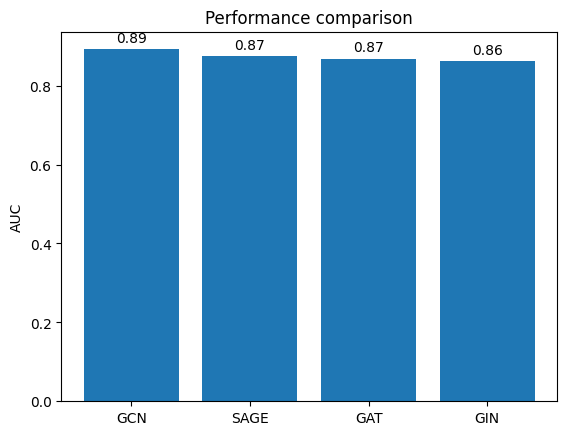

In [103]:
import matplotlib.pyplot as plt
AUC_list = [AUC_GCN, AUC_SAGE, AUC_GAT, AUC_GIN]
AUC_name = ['GCN',"SAGE","GAT",'GIN']

# create a bar plot
fig, ax = plt.subplots()
rects = ax.bar(range(len(AUC_list)), AUC_list)

# add labels to the top of each bar
for rect in rects:
    height = rect.get_height()
    ax.annotate(f'{height:.2f}', xy=(rect.get_x() + rect.get_width() / 2, height),
                xytext=(0, 3), textcoords='offset points', ha='center', va='bottom')

# set labels and title
ax.set_xticks(range(len(AUC_list)))
ax.set_xticklabels(AUC_name)
ax.set_ylabel('AUC')
ax.set_title('Performance comparison')

# display the plot
plt.show()

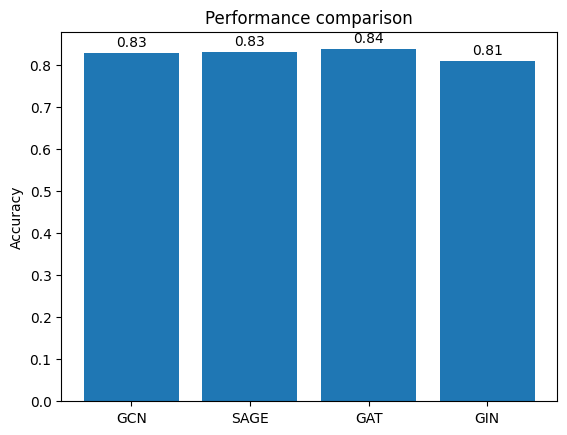

In [102]:
import matplotlib.pyplot as plt
Acc_list = [Acc_GCN, Acc_SAGE, Acc_GAT, Acc_GIN]
model_name = ['GCN',"SAGE","GAT",'GIN']

# create a bar plot
fig, ax = plt.subplots()
rects = ax.bar(range(len(Acc_list)), Acc_list)

# add labels to the top of each bar
for rect in rects:
    height = rect.get_height()
    ax.annotate(f'{height:.2f}', xy=(rect.get_x() + rect.get_width() / 2, height),
                xytext=(0, 3), textcoords='offset points', ha='center', va='bottom')

# set labels and title
ax.set_xticks(range(len(Acc_list)))
ax.set_xticklabels(model_name)
ax.set_ylabel('Accuracy')
ax.set_title('Performance comparison')

# display the plot
plt.show()

## Friend recommendation

After training our model, we can make friend suggestions to users. This involves calculating the dot product of embeddings between a specific user and all other users who are not currently friends with them. Then, we select the top 5 users with the highest dot product scores and suggest them as potential friends to the user.

In [ ]:
# --------- generate recommendation for user -------- #
def generate_rec(h, user_id=0):
    # `h` represents the node embeddings, with shape [num_nodes, hidden_size]

    # generate a graph with (num_nodes - num_friends_of_user) edges
    # one end of the edge is user_id
    # the other end is a user that's NOT friends with user_id
    user_friends = set()
    user_neg_u, user_neg_v = [], []
    for n1, n2 in zip(u, v):   # get all friends of user_id
        if int(n1) == user_id:
            user_friends.add(int(n2))
        if int(n2) == user_id:
            user_friends.add(int(n1))

    for i in range(num_nodes):  # generate "negative edges" for user_id
        if i != user_id and i not in user_friends:
            user_neg_u.append(user_id)
            user_neg_v.append(i)
            
    user_g = dgl.graph((user_neg_u, user_neg_v), num_nodes=g.number_of_nodes())

    pred = DotPredictor()

    # calculate the score of each user
    scores = [(i, score) for i, score in enumerate(pred(user_g, h))]

    # produce final ranked list
    scores.sort(key=lambda x: -x[1])

    # display results
    print(f"List of 5 suggested friends for user {user_id}:")
    for i in range(5):
        print(f'- User {scores[i][0]}, score = {scores[i][1]}')


The recommended users are shown as follows:

In [ ]:
generate_rec(h_GCN, user_id=0)

List of 5 suggested friends for user 0:
- User 236, score = 1.714005470275879
- User 169, score = 1.6533551216125488
- User 86, score = 1.5008655786514282
- User 241, score = 1.4760918617248535
- User 192, score = 1.4492229223251343


/usr/local/lib/python3.9/dist-packages/dgl/backend/pytorch/tensor.py:445: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  assert input.numel() == input.storage().size(), (


---